# Exloratory analysis of ML models <br>
The aim of this notebook is to have clear understanding of which machine learning models work well for the data set at hand. In this notebook, we will try different models with their hyperparameter tuning for the best performance. By the end of this notebook we will have models to compare based on the performance metric mean absolute error on the train data set using all of 130 features. This notebook will helps us to select best models which will then be used to for the final prediction task.

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import os
import gc
from tqdm.notebook import tqdm

## A) Prepare Data Frame for predictors and target variables <br>
Here we want to create two data frames, each for predictors and target feature (loss). While doing this we will use downcasting function which will cast columns of our data frame to appropriate data structures that will help save memory.

In [7]:
# load train data set
train=pd.read_csv('inputs/train.csv')
loss=train.loss
train.drop(['id','loss'],axis=1,inplace=True)

# load test data set
test=pd.read_csv('inputs/test.csv')
test_id=test.id
test.drop(['id'],axis=1,inplace=True)

# label-encode categorical features
cat_features=train.select_dtypes(include='object').columns
for feat in cat_features:
    train[feat],_=pd.factorize(train[feat])
    test[feat],_=pd.factorize(test[feat])
    
# Downcast data frame to save RAM. credit:https://www.kaggle.com/anshuls235/m5-forecasting-eda-fe-modelling
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df


train=downcast(train)
test=downcast(test)

## B) Create helper functions <br>
Note that we will use transformed (scaled+shift) target feature for better prediction results. Since, we are using scaling analysing the models based on the metric score calculated on the scaled target feature may mislead us in the model selection process. Hence, we define a custom metric function which will first unscale and unshift y_prediction, y_true (making values to the original scale) for calculating mean absolute error. <br>
Along with this, we define a funtion which can take in the estimator and parameter list as argument and perform k fold cross validation using sklearn gridserachcv function for optimal hyperparameter search.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import pickle

Using TensorFlow backend.


In [4]:
# Create a directory to save models
if not os.path.exists('.\models'):
    os.makedirs('.\models')

In [4]:
def custom_mae(y_true,y_pred):
    '''Returns mean absolute error of y_pred values in the original scale'''
    y_true=list(map(lambda val:(val**4)-1,y_true))
    y_pred=list(map(lambda val:(val**4)-1,y_pred))
    
    return mae(y_true,y_pred)

custom_metric=make_scorer(custom_mae,greater_is_better=False)

In [5]:
def model_fit(estimator,params,folds=3,epochs=False):
    '''Uses gridsearch to find best parameter fit for the estimator'''
    param_n=list(params.keys())[0]
    model=GridSearchCV(estimator=estimator,
                param_grid=params,
                scoring=custom_metric,
                cv=folds,
                return_train_score=True,
                n_jobs=-1)
    #model.fit(X_tr,y_tr)
    
    #pickle.dump(model,open('models/model_{0}_{1}.sav'.format(param_n,model.best_params_[param_n]),'wb'))
    
    print('Best params:',model.best_params_,'Best score:',(model.best_score_)*-1,'Mean train score:',-(model.cv_results_['mean_train_score'][model.best_index_]))

    fig,ax=plt.subplots(figsize=(10,7))
    ax.plot(params[param_n],list(map(lambda val:val*-1,model.cv_results_['mean_train_score'])), label='Train')
    ax.scatter(params[param_n],list(map(lambda val:val*-1,model.cv_results_['mean_train_score'])))
    ax.plot(params[param_n],list(map(lambda val:val*-1,model.cv_results_['mean_test_score'])), label='Hold out')
    ax.scatter(params[param_n],list(map(lambda val:val*-1,model.cv_results_['mean_test_score'])))
    
    ax.set_title('Mean errors plot '+param_n)
    ax.set_xlabel('Parameter values')
    ax.set_ylabel('Mean of MAE erros')
    ax.legend()

In [ ]:
path='submissions/first/'
if not os.path.exists(path):
    os.makedirs(path)

In [14]:
def kaggle_submission(pred,filename):
    y_pred=list(map(lambda val:(val**4)-1,pred))
    my_sub=pd.DataFrame({'id':test_id,'loss':y_pred})
    my_sub.to_csv(filename,index=False)
    
    print('File saved')

In [6]:
X_tr,X_cv,y_tr,y_cv=train_test_split(np.array(train),np.array((loss+1)**0.25),test_size=0.2,random_state=5)

## C) ML Models <br>
Here, we will use 8 different models to predict target values. We will also tune hyperparameters of each of the models to compare their best performances.
## 1. Random Guessing

In [9]:
y_cv_pred_uni=np.random.uniform(min(y_tr),max(y_tr),y_cv.shape[0])
y_cv_pred_uni=np.array(list(map(lambda val:(val**4)-1, y_cv_pred_uni)))
print('MAE on cv (uniform):',mae(y_cv,y_cv_pred_uni))

y_cv_pred_nor=np.random.normal(y_tr.mean(),y_tr.std(),y_cv.shape[0])
y_cv_pred_nor=np.array(list(map(lambda val:(val**4)-1, y_cv_pred_nor)))
print('MAE on cv (normal):',mae(y_cv,y_cv_pred_nor))

MAE on cv (uniform): 22480.871892548123
MAE on cv (normal): 2962.331607869361


In [73]:
y_pred=np.random.normal(y_tr.mean(),y_tr.std(),test.shape[0])
kaggle_submission(y_pred,path+'normal_guessing.csv')

File saved


#### Kaggle Submission <br>
<img src='submissions/first/normal_guessing.png'>

## 2. Ridge Regression

Best params: {'alpha': 0.1} Best score: 1297.4064857485353 Mean train score: 1295.3567370544886


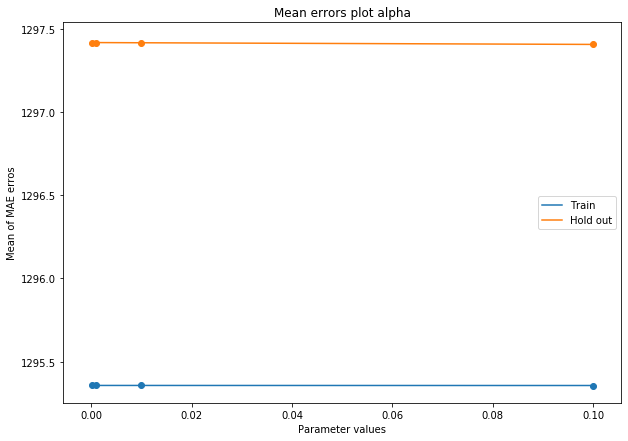

In [39]:
est=Ridge(random_state=16)
params={'alpha':[0.0001,0.001,0.01,0.1]}
model_fit(estimator=est,params=params,folds=3)

In [15]:
reg=Ridge(alpha=0.1)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'ridge_submission.csv')

File saved


Ridge regression: alpha=0.1 <br>
CV Error: 1297.406 <br>
#### Kaggle submission score
<img src='submissions/first/ridge_submission.png'>

## 3. Stochastic gradient descent (SGD) with Squared loss error <br>
### Paramter tuning<br>
## 3.1 Learning rate

Best params: {'eta0': 0.0001} Best score: 1577.702039453011 Mean train score: 1577.2111259889452


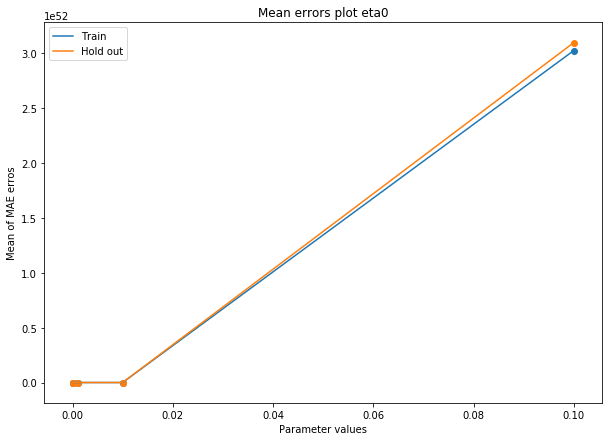

In [40]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.00001,0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=3)

Optimal eta0 is in the scale of 1/10000. Let's explore few values in that scale for optimal eat0.

Best params: {'eta0': 0.0005} Best score: 1433.942839129875 Mean train score: 1435.0725835897438


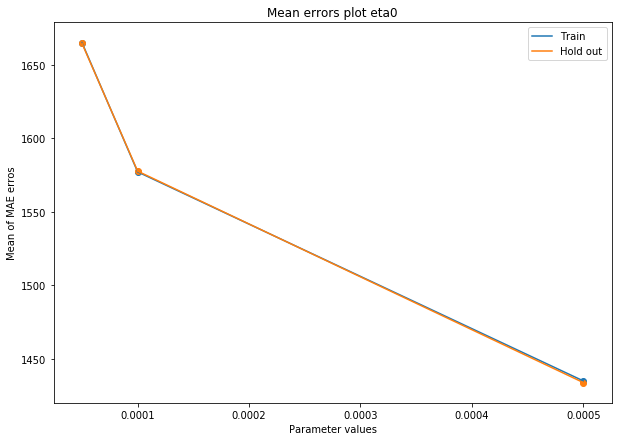

In [54]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.00005,0.0001,0.0005]}

model_fit(estimator=est,params=params,folds=3)

Current optimal values is 0.0005. But note that is the largest value in our grid and hence we need to explore values greater than that.

Best params: {'eta0': 0.0008} Best score: 1387.6730424845684 Mean train score: 1389.4073742031007


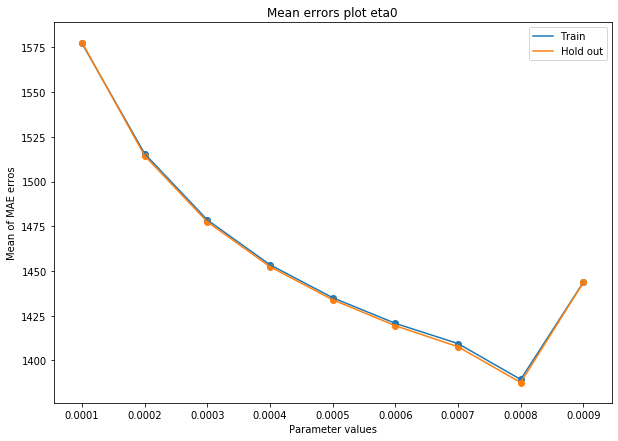

In [56]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/10000 for i in range(1,10)]}

model_fit(estimator=est,params=params,folds=3)

We have hit the minimal point in our grid. But we can find more optimal value by searching on more granular level.

Best params: {'eta0': 0.00083} Best score: 1378.553211072199 Mean train score: 1378.952715809665


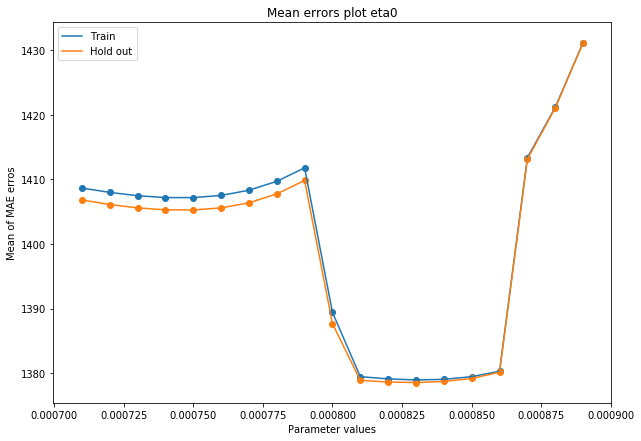

In [58]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/100000 for i in range(71,90)]}

model_fit(estimator=est,params=params,folds=3)

## 3.2 l1 ratio

Best params: {'l1_ratio': 0.1} Best score: 1378.553211072199 Mean train score: 1378.952715809665


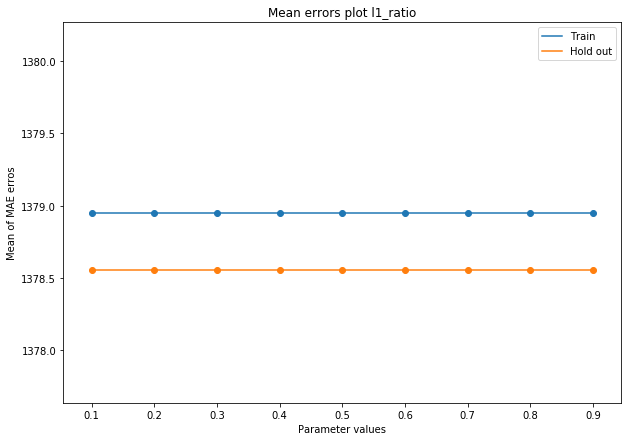

In [169]:
est=SGDRegressor(loss='squared_loss',
                eta0=0.00083,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(1,10)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'l1_ratio': 0} Best score: 1378.553211072199 Mean train score: 1378.952715809665


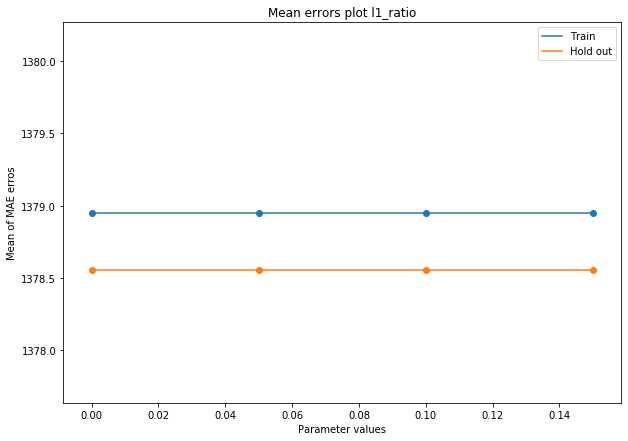

In [170]:
est=SGDRegressor(loss='squared_loss',
                eta0=0.00083,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[0,0.05,0.1,0.15]}

model_fit(estimator=est,params=params,folds=3)

In [16]:
reg=SGDRegressor(loss='squared_loss',
                eta0=0.00083,
                l1_ratio=0,
                early_stopping=True)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'SGD_sq_loss_submission.csv')

File saved


SGD with Squared loss: eta0=0.00083, l1_ratio=0 <br>
CV Error: 1378.55 <br>
#### Kaggle submission score
<img src='submissions/first/SGD_sq_loss_submission.png'>

## 4 SVR (Support Vector Regressor) with SGD <br>
According to <a href='https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html'>sklearn SVR page</a>, SVR fit time complexity is more than quadratic with the number of samples that makes it hard to use for data set that has couple of 10000 data samples. We have 188318 samples to train on. Hence, we are using SGD along with epsilon insensitive as objective function which is used in the SVR class.<br>
### Paramter tuning <br>
## 4.1 Learning rate

Best params: {'eta0': 0.001} Best score: 1424.8622288599292 Mean train score: 1426.2629462292814


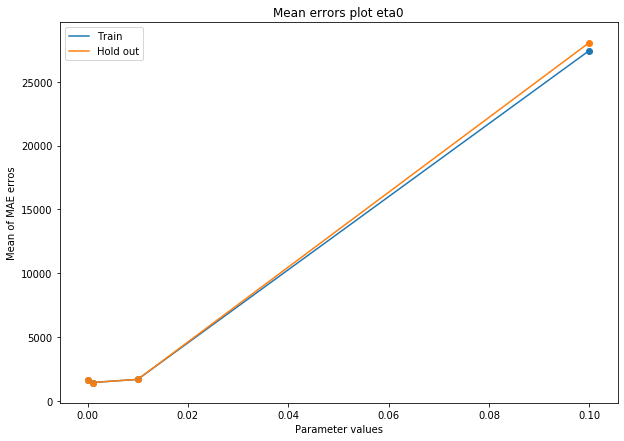

In [64]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'eta0': 0.002} Best score: 1378.0300699356912 Mean train score: 1376.8611008103517


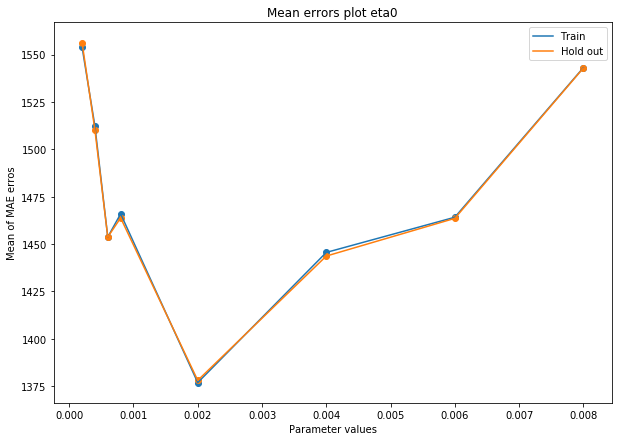

In [66]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[i/10000 for i in range(2,10,2)]+[i/1000 for i in range(2,10,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'eta0': 0.0025} Best score: 1346.9367653628342 Mean train score: 1347.7721658559333


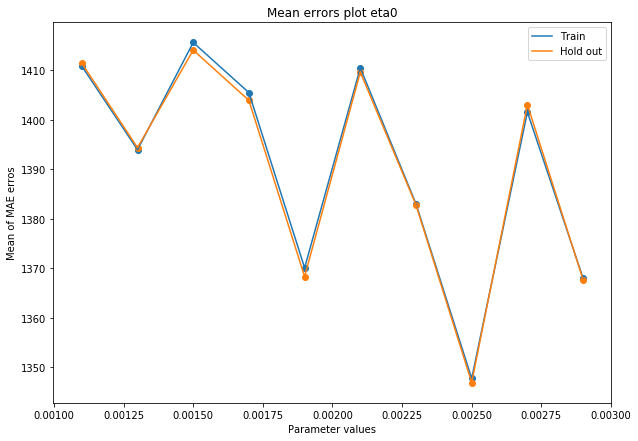

In [73]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[i/10000 for i in range(11,31,2)]}

model_fit(estimator=est,params=params,folds=3)

## 4.2 Epsilon

Best params: {'epsilon': 0.1} Best score: 1346.9367653628342 Mean train score: 1347.7721658559333


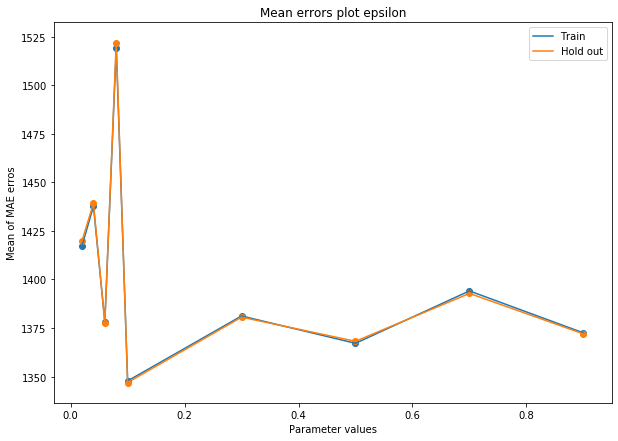

In [77]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0025,
                early_stopping=True,
                random_state=16)
params={'epsilon':[i/100 for i in range(2,10,2)]+[i/10 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'epsilon': 0.1} Best score: 1346.9367653628342 Mean train score: 1347.7721658559333


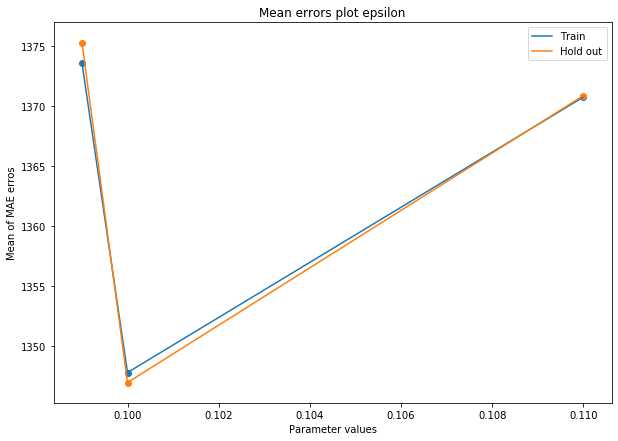

In [79]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0025,
                early_stopping=True,
                random_state=16)
params={'epsilon':[0.099,0.1,0.11]}

model_fit(estimator=est,params=params,folds=3)

## 4.3 l1 ratio

Best params: {'l1_ratio': 0.1} Best score: 1346.9367653628342 Mean train score: 1347.7721658559333


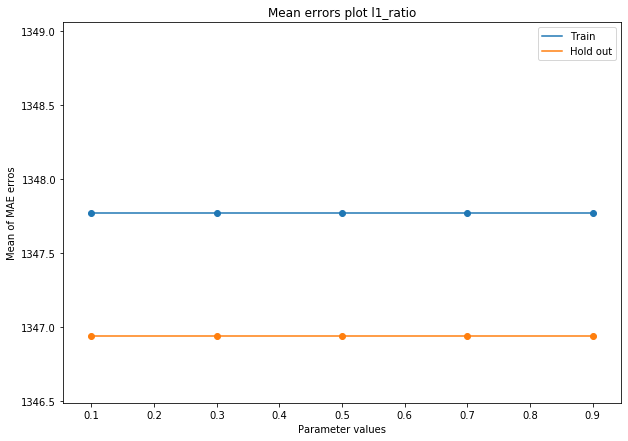

In [167]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0025,
                epsilon=0.1,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'l1_ratio': 0} Best score: 1346.9367653628342 Mean train score: 1347.7721658559333


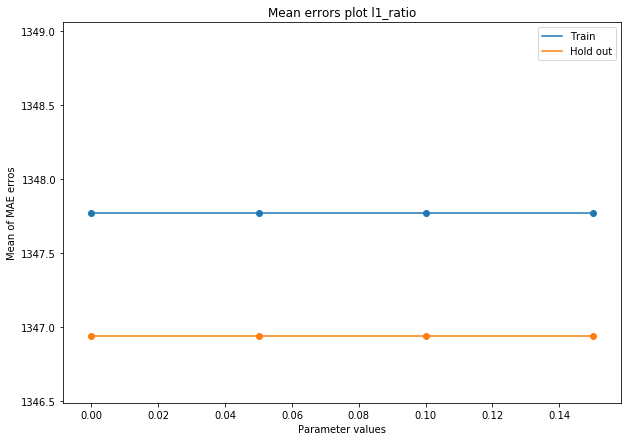

In [168]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0025,
                epsilon=0.1,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[0,0.05,0.1,0.15]}

model_fit(estimator=est,params=params,folds=3)

In [17]:
reg=SGDRegressor(loss='epsilon_insensitive',
                 eta0=0.0025,
                 epsilon=1,
                 l1_ratio=0,
                 early_stopping=True)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'SGD_svr_submission.csv')

File saved


SGD with epsilon_insensitive (SVR): eta0=0.0025, epsilon=1, l1_ratio=0 <br>
CV Error: 1346.937 <br>
#### Kaggle submission score<br>
<img src='submissions/first/SGD_svr_submission.png'>

## 5. Huber loss with SGD <br>
<img src="images/huberloss.png"> <br>
As we can see, Huber loss is a good approximation for the mean absolute error function, which is indefferenciable and hence can not be directly used as a objective function. Hence, we are using SGD with the Huber loss as objective function.<br>
### Paramter tuning<br>

## 5.1 learning rate

Best params: {'eta0': 0.01} Best score: 1424.9632598834958 Mean train score: 1425.0458857048222


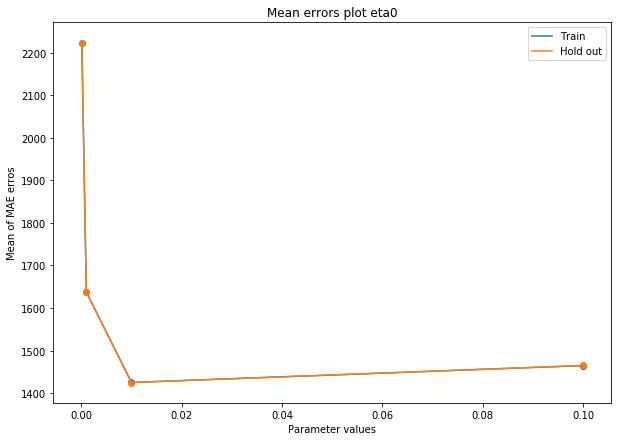

In [86]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'eta0': 0.05} Best score: 1418.92383329943 Mean train score: 1423.4841255779504


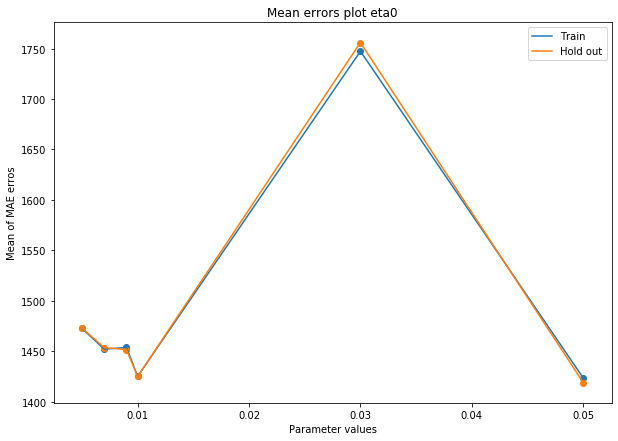

In [87]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/1000 for i in range(5,10,2)]+[i/100 for i in range(1,7,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'eta0': 0.048} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


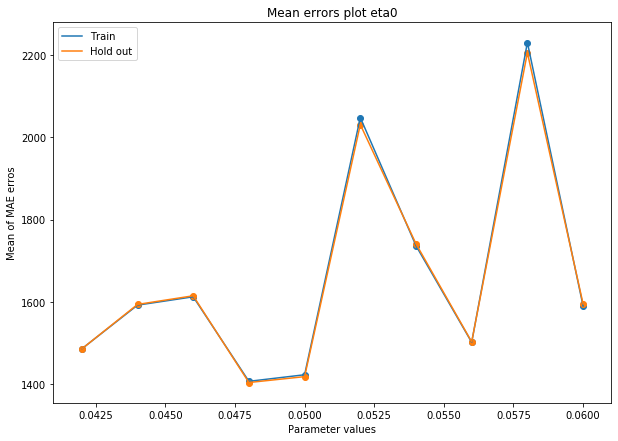

In [89]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/1000 for i in range(42,61,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'eta0': 0.048} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


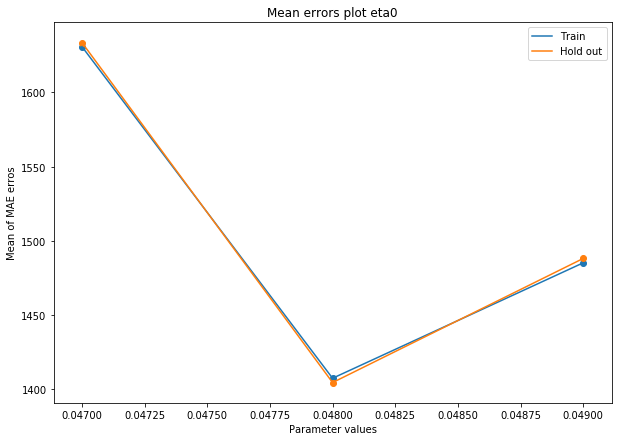

In [90]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.047,0.048,0.049]}

model_fit(estimator=est,params=params,folds=3)

## 5.2 epsilon

Best params: {'epsilon': 0.1} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


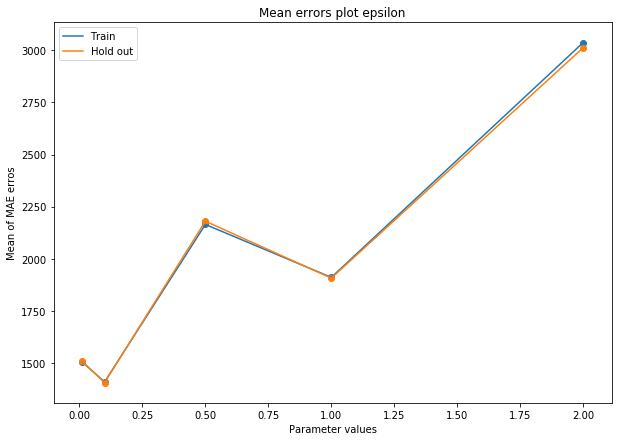

In [92]:
est=SGDRegressor(loss='huber',
                 eta0=0.048,
                early_stopping=True,
                random_state=16)
params={'epsilon':[0.01,0.1,0.5,1,2]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'epsilon': 0.1} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


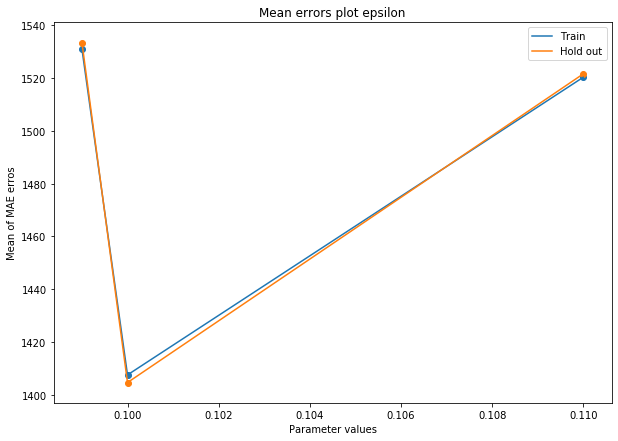

In [93]:
est=SGDRegressor(loss='huber',
                 eta0=0.048,
                early_stopping=True,
                random_state=16)
params={'epsilon':[0.099,0.1,0.11]}

model_fit(estimator=est,params=params,folds=3)

## 5.3 l1 ratio

Best params: {'l1_ratio': 0.1} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


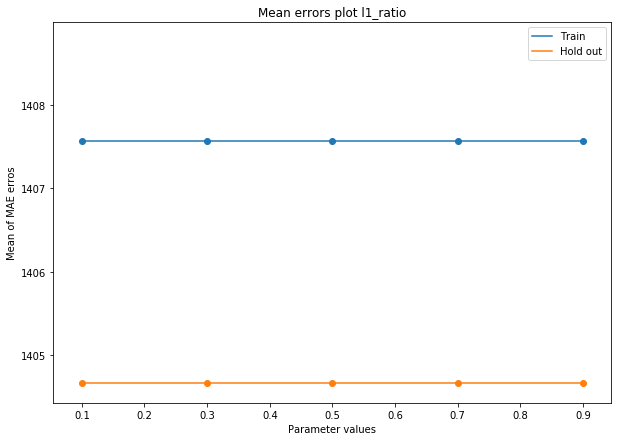

In [164]:
est=SGDRegressor(loss='huber',
                 eta0=0.048,
                 epsilon=0.1,
                 early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=3)

Best params: {'l1_ratio': 0} Best score: 1404.670923786539 Mean train score: 1407.5659877744374


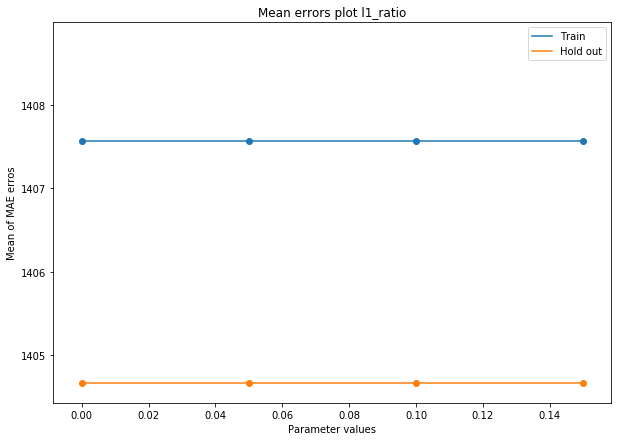

In [166]:
est=SGDRegressor(loss='huber',
                 eta0=0.048,
                 epsilon=0.1,
                 early_stopping=True,
                random_state=16)
params={'l1_ratio':[0,0.05,0.1,0.15]}

model_fit(estimator=est,params=params,folds=3)

In [18]:
reg=SGDRegressor(loss='huber',
                 eta0=0.048,
                 epsilon=0.1,
                 l1_ratio=0,
                 early_stopping=True)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'SGD_huber_submission.csv')

File saved


SGD with huber loss: eta0=0.048, epsilon=0.1, l1_ratio=0 <br>
CV error=1407.566 <br>
#### Kaggle Submission <br>
<img src='submissions/first/SGD_huber_submission.png'>

## 6. Random Forest <br>
## 6.1 Max depth

Best params: {'max_depth': 9} Best score: 1333.3543746399664 Mean train score: 1281.0099086896664


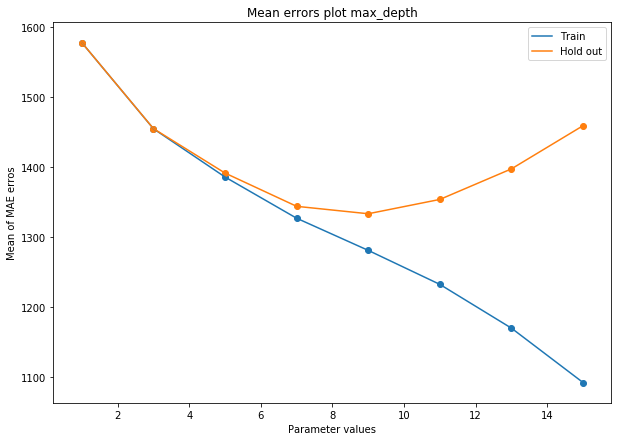

In [110]:
est=RandomForestRegressor(n_estimators=1,
                         random_state=16,
                         n_jobs=-1)
params={'max_depth':[i for i in range(1,16,2)]}

model_fit(estimator=est,params=params,folds=3)

We got 9 as best max_depth value. But we have explored only odd values hence we need to compare results from values one less than 9 and one greater than 9

Best params: {'max_depth': 9} Best score: 1333.3543746399664 Mean train score: 1281.0099086896664


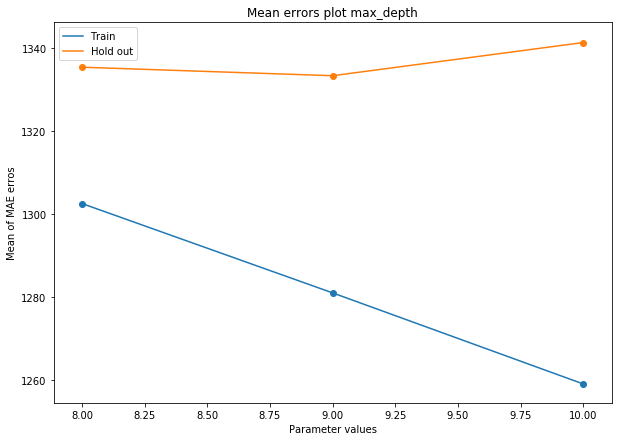

In [111]:
est=RandomForestRegressor(n_estimators=1,
                         random_state=16,
                         n_jobs=-1)
params={'max_depth':[8,9,10]}

model_fit(estimator=est,params=params,folds=3)

## 6.2 min samples split

Best params: {'min_samples_split': 19} Best score: 1329.4267959324243 Mean train score: 1286.671070061516


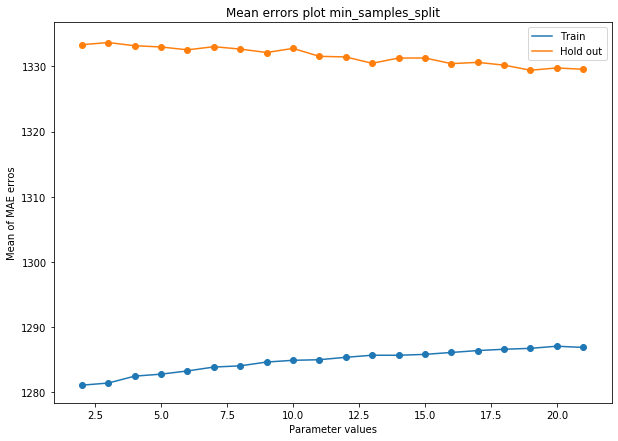

In [175]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          n_jobs=-1,
                         random_state=16)
params={'min_samples_split':[i for i in range(1,22)]}

model_fit(estimator=est,params=params,folds=3)

## 6.3 min samples leaf

Best params: {'min_samples_leaf': 9} Best score: 1326.7414066577487 Mean train score: 1287.7985139355676


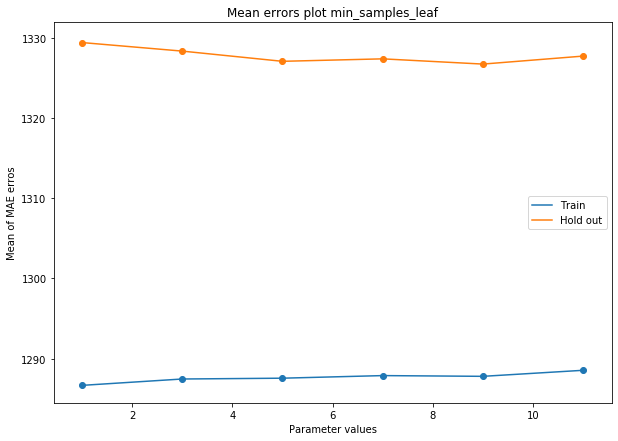

In [176]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          min_samples_split=19,
                          n_jobs=-1,
                         random_state=16)
params={'min_samples_leaf':[i for i in range(1,12,2)]}

model_fit(estimator=est,params=params,folds=3)

We have checked only odd values for min_samples_leaf and hence we must check for 8 and 10 as well

Best params: {'min_samples_leaf': 8} Best score: 1326.1714345170042 Mean train score: 1287.9549045470753


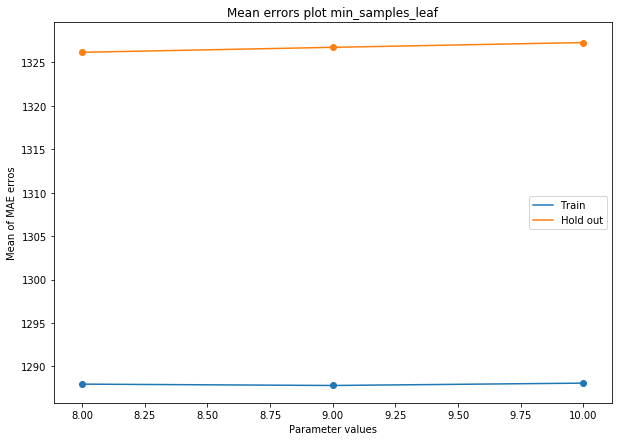

In [177]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          min_samples_split=19,
                          n_jobs=-1,
                         random_state=16)
params={'min_samples_leaf':[8,9,10]}

model_fit(estimator=est,params=params,folds=3)

## 6.4 number of estimators

Best params: {'n_estimators': 100} Best score: 1271.6634662748093 Mean train score: 1233.7983591059838


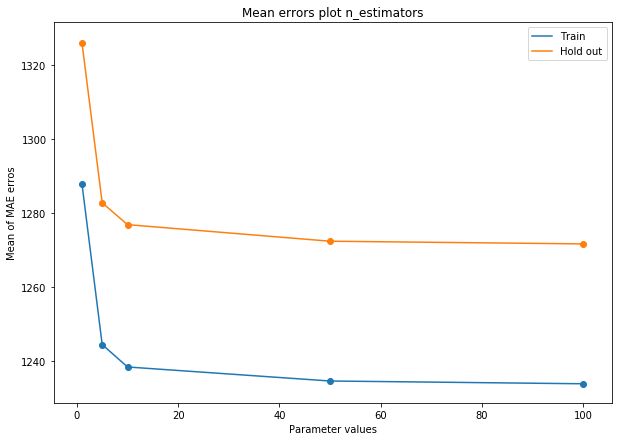

In [116]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'n_estimators':[1,5,10,50,100]}

model_fit(estimator=est,params=params,folds=3)

We have 100 as best value for number of estimators but we haven't checked values greater than 100. So let's do that now.

Best params: {'n_estimators': 200} Best score: 1271.3462001034939 Mean train score: 1233.295779235681


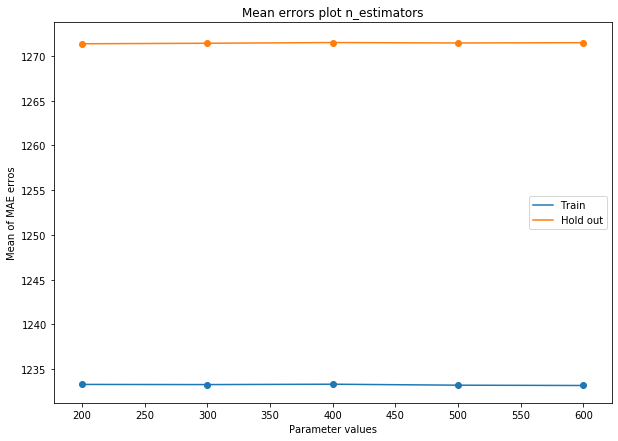

In [117]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'n_estimators':[200,300,400,500,600]}

model_fit(estimator=est,params=params,folds=3)

Let's see if any values in between 150,200, and 250 are good for fit, with the step size of 25

Best params: {'n_estimators': 200} Best score: 1271.3462001034939 Mean train score: 1233.295779235681


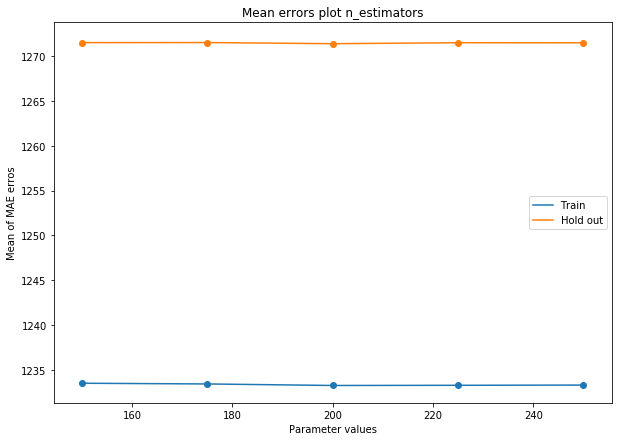

In [119]:
est=RandomForestRegressor(n_estimators=1,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'n_estimators':[150,175,200,225,250]}

model_fit(estimator=est,params=params,folds=3)

## 6.5 max samples

Best params: {'max_samples': 0.6} Best score: 1268.2982098411132 Mean train score: 1233.7036261342776


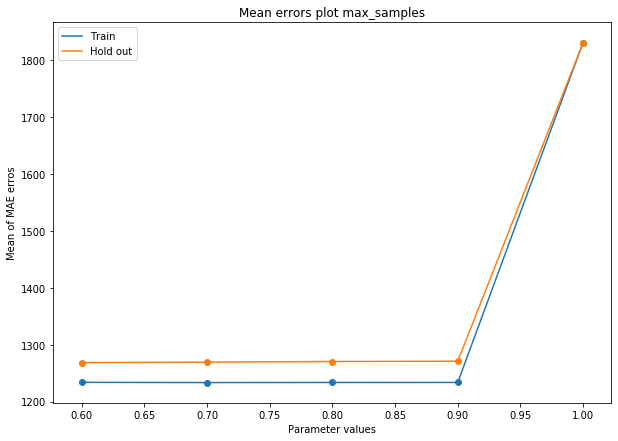

In [120]:
est=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'max_samples':[0.6,0.7,0.8,0.9,1]}

model_fit(estimator=est,params=params,folds=3)

We found 60% of samples for training is good fit for max_samples. But that the lowest values in our grid and we should check if lower values than 60% can improve model performance

Best params: {'max_samples': 0.3} Best score: 1264.8397329352583 Mean train score: 1236.0893618104822


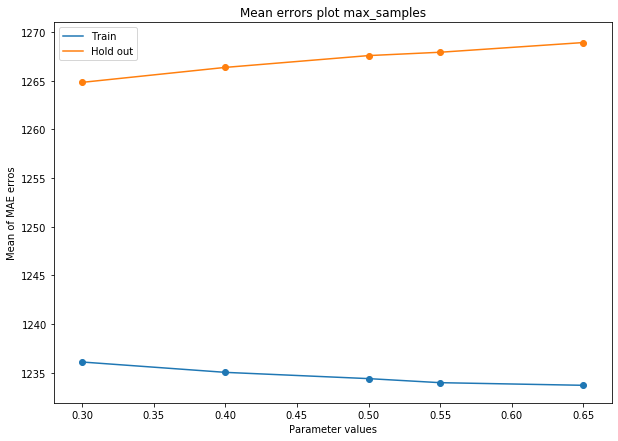

In [121]:
est=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'max_samples':[0.3,0.4,0.5,0.55,0.65]}

model_fit(estimator=est,params=params,folds=3)

Again, 30% is a boundary value and lower values than that need to be checked

Best params: {'max_samples': 0.2} Best score: 1263.3394473341925 Mean train score: 1238.296155251658


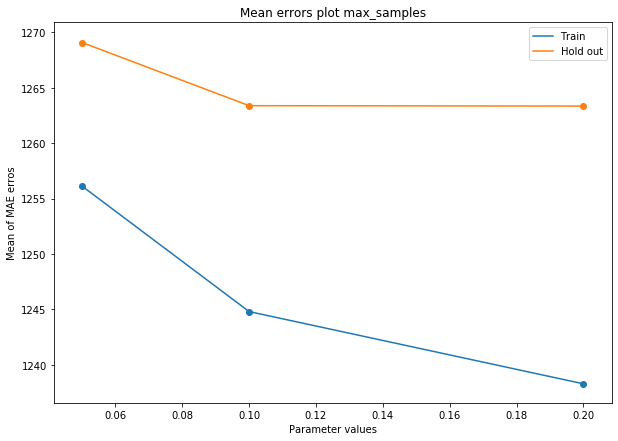

In [122]:
est=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'max_samples':[0.05,0.1,0.2]}

model_fit(estimator=est,params=params,folds=3)

Again, 20% is boundary value, but the performance improvement over the previous models is less drastic which could be a sign we are close the convergence.

Best params: {'max_samples': 0.15} Best score: 1262.700509238376 Mean train score: 1240.477819540897


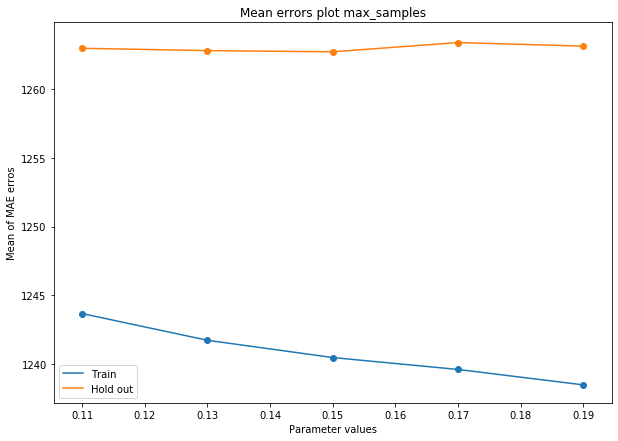

In [123]:
est=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'max_samples':[i/100 for i in range(11,20,2)]}

model_fit(estimator=est,params=params,folds=3)

Seems like we really close to optimal value as improvement is in 1/10ths. But let's give our best shot for finding best values.

Best params: {'max_samples': 0.145} Best score: 1262.7468907336295 Mean train score: 1240.6106987035926


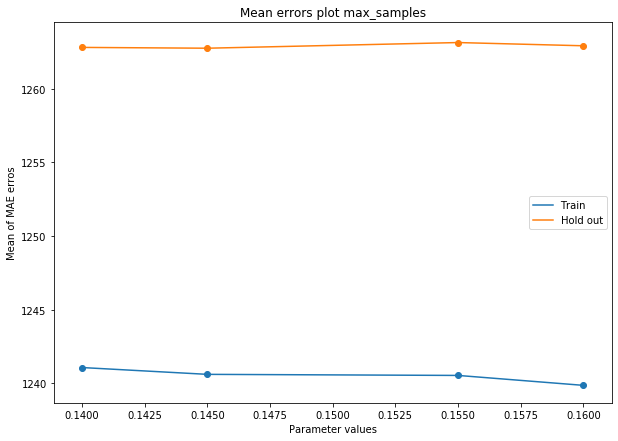

In [124]:
est=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          n_jobs=-1,
                         random_state=16)
params={'max_samples':[0.14,0.145,0.155,0.16]}

model_fit(estimator=est,params=params,folds=3)

In [20]:
reg=RandomForestRegressor(n_estimators=200,
                          max_depth=9,
                          min_samples_split=19,
                          min_samples_leaf=8,
                          max_samples=0.145,
                          n_jobs=-1)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'rfr_submission.csv')

File saved


Random Forest: n_estimators=200, max_depth=9, min_samples_split=19, min_samples_leaf=8, max_samples=0.145 <br>
CV Error: 1262.747 <br>
#### Kaggle Submission <br>
<img src='submissions/first/rfr_submission.png'>

## 7. xgboost <br>
### Parameter tuning <br>
### Helper function for XGB model <br>
XGBoost has different requirements than the sklearn for defining custom metric and hence new custom metric function needs to be defined for xgboost models. Along with that, xgboost model has be recalibrated for the number of boosting rounds every time the hyper-parameter of a model is updated. We define a function that takes in estimator as the argument and performs cross validation using xgb.cv function.

In [123]:
def custom_eval(predt: np.ndarray, dtrain: xgb.DMatrix):
    """Find absolute mean error of predicted values in the original scale"""
    y=dtrain.get_label()
    y=list(map(lambda val:(val**4)-1,y))
    predt=list(map(lambda val:(val**4)-1,predt))
    error=mae(y,predt)
    return 'Error', error

In [124]:
def xgb_cv_fit(estimator,cv=3,stopping_rounds=3):
    '''Uses K fold cross validation to cross validate xgboost estimator parameter.'''
    params=estimator.get_xgb_params()
    Dtrain=xgb.DMatrix(data=np.array(X_tr),label=np.array(y_tr))
    n_rounds=params['n_estimators']
    
    cvresults=xgb.cv(params=params,
            num_boost_round=n_rounds,
            nfold=cv,
            dtrain=Dtrain,
            feval=custom_eval,
            early_stopping_rounds=stopping_rounds,
            verbose_eval=True)
    
    n_rounds=cvresults.shape[0]
    
    estimator.set_params(n_estimators=n_rounds)
    estimator.fit(X=X_tr,
                  y=y_tr,
                  eval_set=[(X_cv,y_cv)],
                 eval_metric=custom_eval)
    pickle.dump(estimator,open('models/model_rounds_{0}'.format(n_rounds),'wb'))
    
    
    pred=estimator.predict(X_cv)
    pred=list(map(lambda val:(val**4)-1,pred))
    
    y=list(map(lambda val:(val**4)-1,y_cv))
    
    print('MAE:',mae(y,pred),'Number of estimators:',n_rounds)

## 7.1 Number of boosting rounds (number of trees)

In [33]:
est=xgb.XGBRegressor(n_estimators=10000,
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:2832.54+2.24473	train-rmse:3.48803+0.00108012	test-Error:2832.54+5.20883	test-rmse:3.48803+0.00611881
[1]	train-Error:2208.08+1.95045	train-rmse:2.0446+0.000872495	test-Error:2208.07+6.14762	test-rmse:2.0446+0.00615452
[2]	train-Error:1751.23+1.44245	train-rmse:1.46008+0.000756272	test-Error:1751.25+5.92273	test-rmse:1.46009+0.00562229
[3]	train-Error:1566.59+1.29146	train-rmse:1.25999+0.000899659	test-Error:1566.62+4.09335	test-rmse:1.26001+0.00392781
[4]	train-Error:1499.59+1.51783	train-rmse:1.1931+0.00100231	test-Error:1499.63+3.31697	test-rmse:1.19313+0.00284886
[5]	train-Error:1461.53+2.10022	train-rmse:1.16422+0.00140233	test-Error:1461.61+2.43721	test-rmse:1.16427+0.00238889
[6]	train-Error:1441.69+1.98048	train-rmse:1.15085+0.00128787	test-Error:1441.76+2.35417	test-rmse:1.1509+0.00207193
[7]	train-Error:1428.43+2.21293	train-rmse:1.13993+0.00165046	test-Error:1428.52+1.93884	test-rmse:1.14+0.00221384
[8]	train-Error:1417.02+2.16089	train-rmse:1.13166+0.0016735

[70]	train-Error:1254.71+2.08502	train-rmse:1.00357+0.00131921	test-Error:1256.58+1.81695	test-rmse:1.0052+0.0022549
[71]	train-Error:1254.29+2.01841	train-rmse:1.00318+0.00131485	test-Error:1256.19+2.14095	test-rmse:1.00482+0.00250921
[72]	train-Error:1253.74+1.95869	train-rmse:1.00281+0.001317	test-Error:1255.82+2.1852	test-rmse:1.00457+0.00244414
[73]	train-Error:1253.33+1.94004	train-rmse:1.00246+0.0013105	test-Error:1255.45+2.19182	test-rmse:1.00418+0.0024282
[74]	train-Error:1252.8+1.89771	train-rmse:1.0021+0.00130748	test-Error:1255.07+2.19264	test-rmse:1.0039+0.00243531
[75]	train-Error:1252.38+1.82545	train-rmse:1.00172+0.00131553	test-Error:1254.47+2.37743	test-rmse:1.00346+0.00247833
[76]	train-Error:1251.99+1.81734	train-rmse:1.00136+0.00130876	test-Error:1254.12+2.45181	test-rmse:1.00309+0.00248294
[77]	train-Error:1251.54+1.73597	train-rmse:1.00099+0.00127208	test-Error:1253.68+2.57728	test-rmse:1.00271+0.0025114
[78]	train-Error:1251.04+1.80237	train-rmse:1.00062+0.00126

[139]	train-Error:1236.57+1.50254	train-rmse:0.988947+0.00128307	test-Error:1239.8+2.74569	test-rmse:0.991426+0.00245791
[140]	train-Error:1236.42+1.50631	train-rmse:0.988839+0.00128291	test-Error:1239.77+2.62232	test-rmse:0.991354+0.00239206
[141]	train-Error:1236.35+1.48642	train-rmse:0.988735+0.00128583	test-Error:1239.68+2.64528	test-rmse:0.991282+0.00238386
[142]	train-Error:1236.19+1.49252	train-rmse:0.98861+0.0012752	test-Error:1239.57+2.60003	test-rmse:0.991178+0.00238545
[143]	train-Error:1236.04+1.49203	train-rmse:0.988501+0.0012863	test-Error:1239.46+2.53908	test-rmse:0.991049+0.00234272
[144]	train-Error:1235.95+1.53014	train-rmse:0.988401+0.00128723	test-Error:1239.38+2.60933	test-rmse:0.990962+0.00234912
[145]	train-Error:1235.81+1.49302	train-rmse:0.988294+0.00128001	test-Error:1239.25+2.71445	test-rmse:0.990846+0.00238754
[146]	train-Error:1235.61+1.50631	train-rmse:0.98817+0.00126108	test-Error:1239.1+2.69113	test-rmse:0.990772+0.00243079
[147]	train-Error:1235.47+1.48

[207]	train-Error:1229.64+1.48435	train-rmse:0.983196+0.00124681	test-Error:1233.26+2.73604	test-rmse:0.986118+0.00261195
[208]	train-Error:1229.5+1.48328	train-rmse:0.983138+0.00124698	test-Error:1233.2+2.7374	test-rmse:0.986102+0.00261351
[209]	train-Error:1229.44+1.5018	train-rmse:0.983082+0.00124931	test-Error:1233.16+2.73748	test-rmse:0.986076+0.00261917
[210]	train-Error:1229.33+1.47671	train-rmse:0.983022+0.00125293	test-Error:1233.09+2.83355	test-rmse:0.986016+0.00267885
[211]	train-Error:1229.3+1.42959	train-rmse:0.982968+0.00125451	test-Error:1233.08+2.85318	test-rmse:0.985979+0.00265723
[212]	train-Error:1229.25+1.49621	train-rmse:0.98291+0.00125573	test-Error:1233.01+2.76417	test-rmse:0.985931+0.00263391
[213]	train-Error:1229.21+1.46233	train-rmse:0.982856+0.00125439	test-Error:1232.95+2.78071	test-rmse:0.985867+0.00262824
[214]	train-Error:1229.12+1.45459	train-rmse:0.982803+0.00125364	test-Error:1232.85+2.78997	test-rmse:0.9858+0.00263103
[215]	train-Error:1229.07+1.4640

[275]	train-Error:1225.58+1.20698	train-rmse:0.979735+0.0011903	test-Error:1229.83+2.70551	test-rmse:0.983096+0.00258173
[276]	train-Error:1225.49+1.22396	train-rmse:0.979686+0.00119014	test-Error:1229.78+2.69548	test-rmse:0.983056+0.00258658
[277]	train-Error:1225.45+1.19566	train-rmse:0.979645+0.00118644	test-Error:1229.68+2.74699	test-rmse:0.982983+0.00260435
[278]	train-Error:1225.38+1.2189	train-rmse:0.979592+0.0011832	test-Error:1229.66+2.68275	test-rmse:0.982955+0.00258353
[279]	train-Error:1225.35+1.18584	train-rmse:0.979545+0.00118213	test-Error:1229.6+2.73923	test-rmse:0.982888+0.00260313
[280]	train-Error:1225.3+1.21395	train-rmse:0.979497+0.00117642	test-Error:1229.58+2.68717	test-rmse:0.982861+0.00259065
[281]	train-Error:1225.26+1.1811	train-rmse:0.979452+0.00117214	test-Error:1229.52+2.74345	test-rmse:0.982796+0.00261217
[282]	train-Error:1225.2+1.21897	train-rmse:0.979408+0.00116985	test-Error:1229.5+2.69745	test-rmse:0.982775+0.00260537
[283]	train-Error:1225.17+1.2020

[343]	train-Error:1222.74+1.09956	train-rmse:0.977261+0.00110747	test-Error:1227.29+2.53457	test-rmse:0.980913+0.00259202
[344]	train-Error:1222.7+1.12248	train-rmse:0.977229+0.00110683	test-Error:1227.28+2.50467	test-rmse:0.980896+0.00258704
[345]	train-Error:1222.69+1.10385	train-rmse:0.977197+0.00111084	test-Error:1227.24+2.52615	test-rmse:0.980844+0.00258935
[346]	train-Error:1222.64+1.10877	train-rmse:0.977168+0.00111114	test-Error:1227.23+2.49934	test-rmse:0.980816+0.00259081
[347]	train-Error:1222.61+1.08103	train-rmse:0.977137+0.00111021	test-Error:1227.19+2.51025	test-rmse:0.980787+0.00258563
[348]	train-Error:1222.58+1.10558	train-rmse:0.977109+0.00111006	test-Error:1227.18+2.47846	test-rmse:0.980776+0.00257235
[349]	train-Error:1222.55+1.07494	train-rmse:0.977078+0.00111099	test-Error:1227.13+2.52331	test-rmse:0.980739+0.00257857
[350]	train-Error:1222.51+1.07718	train-rmse:0.977049+0.00111098	test-Error:1227.09+2.51962	test-rmse:0.980716+0.00257898
[351]	train-Error:1222.42

[56]	validation_0-rmse:1.01292	validation_0-Error:1268.46
[57]	validation_0-rmse:1.01208	validation_0-Error:1267.45
[58]	validation_0-rmse:1.01141	validation_0-Error:1266.73
[59]	validation_0-rmse:1.01099	validation_0-Error:1265.72
[60]	validation_0-rmse:1.0103	validation_0-Error:1264.9
[61]	validation_0-rmse:1.00978	validation_0-Error:1264.41
[62]	validation_0-rmse:1.00941	validation_0-Error:1263.67
[63]	validation_0-rmse:1.00885	validation_0-Error:1262.98
[64]	validation_0-rmse:1.00822	validation_0-Error:1262.23
[65]	validation_0-rmse:1.00748	validation_0-Error:1261.6
[66]	validation_0-rmse:1.00688	validation_0-Error:1261.05
[67]	validation_0-rmse:1.00638	validation_0-Error:1260.56
[68]	validation_0-rmse:1.00581	validation_0-Error:1259.96
[69]	validation_0-rmse:1.00534	validation_0-Error:1259.17
[70]	validation_0-rmse:1.00482	validation_0-Error:1258.62
[71]	validation_0-rmse:1.0044	validation_0-Error:1258.23
[72]	validation_0-rmse:1.00412	validation_0-Error:1257.93
[73]	validation_0-

[195]	validation_0-rmse:0.985092	validation_0-Error:1235.01
[196]	validation_0-rmse:0.985026	validation_0-Error:1234.92
[197]	validation_0-rmse:0.984986	validation_0-Error:1234.9
[198]	validation_0-rmse:0.984878	validation_0-Error:1234.77
[199]	validation_0-rmse:0.984844	validation_0-Error:1234.76
[200]	validation_0-rmse:0.984788	validation_0-Error:1234.68
[201]	validation_0-rmse:0.984687	validation_0-Error:1234.58
[202]	validation_0-rmse:0.984636	validation_0-Error:1234.51
[203]	validation_0-rmse:0.98462	validation_0-Error:1234.43
[204]	validation_0-rmse:0.984535	validation_0-Error:1234.36
[205]	validation_0-rmse:0.984464	validation_0-Error:1234.27
[206]	validation_0-rmse:0.984406	validation_0-Error:1234.09
[207]	validation_0-rmse:0.984327	validation_0-Error:1233.99
[208]	validation_0-rmse:0.984273	validation_0-Error:1233.92
[209]	validation_0-rmse:0.984214	validation_0-Error:1233.91
[210]	validation_0-rmse:0.984131	validation_0-Error:1233.81
[211]	validation_0-rmse:0.984065	validatio

[333]	validation_0-rmse:0.979103	validation_0-Error:1228.04
[334]	validation_0-rmse:0.979088	validation_0-Error:1228.02
[335]	validation_0-rmse:0.979053	validation_0-Error:1227.99
[336]	validation_0-rmse:0.979013	validation_0-Error:1227.9
[337]	validation_0-rmse:0.978983	validation_0-Error:1227.91
[338]	validation_0-rmse:0.978944	validation_0-Error:1227.85
[339]	validation_0-rmse:0.978915	validation_0-Error:1227.77
[340]	validation_0-rmse:0.978884	validation_0-Error:1227.85
[341]	validation_0-rmse:0.978836	validation_0-Error:1227.79
[342]	validation_0-rmse:0.978843	validation_0-Error:1227.76
[343]	validation_0-rmse:0.978784	validation_0-Error:1227.72
[344]	validation_0-rmse:0.978719	validation_0-Error:1227.69
[345]	validation_0-rmse:0.978697	validation_0-Error:1227.64
[346]	validation_0-rmse:0.978671	validation_0-Error:1227.62
[347]	validation_0-rmse:0.978632	validation_0-Error:1227.59
[348]	validation_0-rmse:0.978593	validation_0-Error:1227.49
[349]	validation_0-rmse:0.978575	validati

## 7.2 Max depth

Best params: {'max_depth': 2} Best score: 1169.2862395936988 Mean train score: 1143.2737356948592


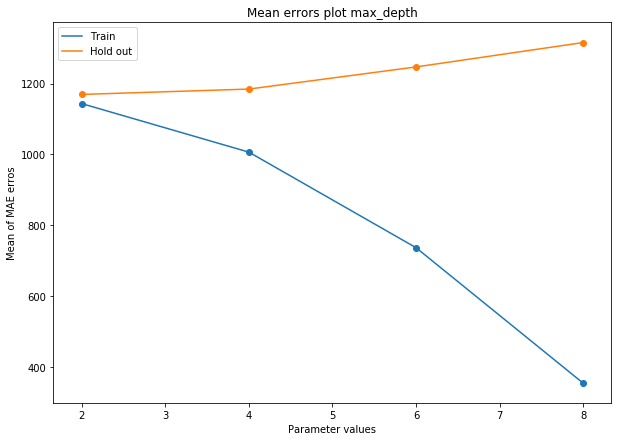

In [35]:
est=xgb.XGBRegressor(n_estimators=382, # Obtained from previous step
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'max_depth':[i for i in range(2,10,2)]}
model_fit(estimator=est,params=params,folds=3)

We have parameter values in grid with step size two so we need to check max_depth equal to 1,2,3 as well. 

Best params: {'max_depth': 2} Best score: 1169.2862395936988 Mean train score: 1143.2737356948592


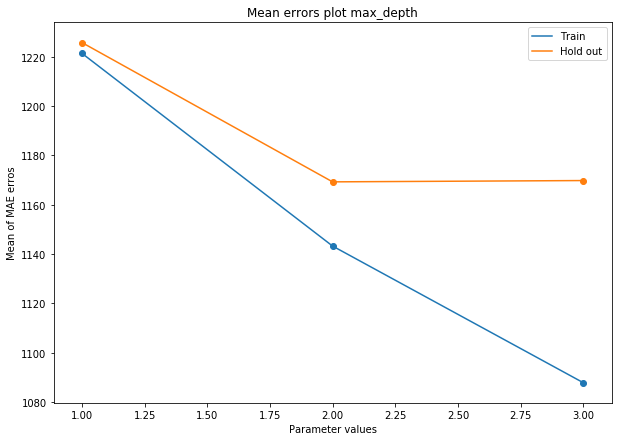

In [36]:
est=xgb.XGBRegressor(n_estimators=382,
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'max_depth':[1,2,3]}
model_fit(estimator=est,params=params,folds=3)

Since we have found max_depth 2 as our best value which is different than the previous one we need to recalibrate boosting rounds<br>
### Recalibrate boosting rounds

In [ ]:
est=xgb.XGBRegressor(n_estimators=10000,
                     max_depth=2,
                     min_child_weight=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

## 7.3 Min child weight

Best params: {'min_child_weight': 2} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


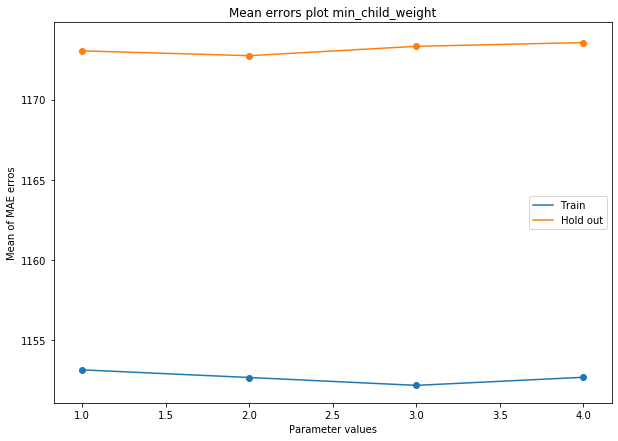

In [36]:
est=xgb.XGBRegressor(n_estimators=273,
                     max_depth=2,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'min_child_weight':[1,2,3,4]}
model_fit(estimator=est,params=params,folds=3)

Since we found min_child_weight=2 which is differnt than the previous value we need to calibrate boosting rounds
### Recalibrate number of trees or boosting rounds with max_depth=2, min_child_weight=1

In [39]:
est=xgb.XGBRegressor(n_estimators=10000,
                     max_depth=2,
                     min_child_weight=2,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:2829.78+2.21596	train-rmse:3.47527+0.000959604	test-Error:2829.78+5.1319	test-rmse:3.47527+0.0063228
[1]	train-Error:2186.03+1.82457	train-rmse:2.01577+0.000752094	test-Error:2186.5+6.61406	test-rmse:2.01642+0.00709411
[2]	train-Error:1707.12+3.5697	train-rmse:1.41807+0.00145669	test-Error:1707.13+4.60785	test-rmse:1.41834+0.0050574
[3]	train-Error:1500.98+2.69368	train-rmse:1.21009+0.000811811	test-Error:1500.45+5.24431	test-rmse:1.21001+0.00468384
[4]	train-Error:1424.24+2.68633	train-rmse:1.1398+0.000690615	test-Error:1424.09+5.20187	test-rmse:1.13992+0.00348019
[5]	train-Error:1392.74+4.77631	train-rmse:1.11088+0.00135135	test-Error:1394.09+2.44194	test-rmse:1.1117+0.00208616
[6]	train-Error:1370.13+1.97485	train-rmse:1.0943+0.000966016	test-Error:1370.82+5.23938	test-rmse:1.09479+0.00217352
[7]	train-Error:1353.07+3.40205	train-rmse:1.0819+0.00239376	test-Error:1353.55+4.43501	test-rmse:1.08244+0.00123625
[8]	train-Error:1339.99+1.98979	train-rmse:1.07209+0.0019319

[69]	train-Error:1196.28+1.71981	train-rmse:0.963983+0.00199058	test-Error:1203.7+4.93527	test-rmse:0.969735+0.00375165
[70]	train-Error:1195.75+1.57168	train-rmse:0.96353+0.00187788	test-Error:1202.97+4.87356	test-rmse:0.969215+0.00373052
[71]	train-Error:1194.97+1.52435	train-rmse:0.963106+0.0017253	test-Error:1202.28+5.1947	test-rmse:0.968803+0.0038852
[72]	train-Error:1194.49+1.62323	train-rmse:0.96279+0.00170607	test-Error:1202.04+5.41984	test-rmse:0.968556+0.00405418
[73]	train-Error:1194.13+1.46164	train-rmse:0.96243+0.00164168	test-Error:1201.81+5.57191	test-rmse:0.968354+0.00419254
[74]	train-Error:1193.64+1.44155	train-rmse:0.962128+0.00159982	test-Error:1201.52+5.86594	test-rmse:0.968124+0.0043803
[75]	train-Error:1193.34+1.40416	train-rmse:0.961863+0.00163505	test-Error:1201.23+5.80545	test-rmse:0.967892+0.00431885
[76]	train-Error:1193+1.42935	train-rmse:0.961618+0.00165916	test-Error:1200.99+5.77105	test-rmse:0.967775+0.00430827
[77]	train-Error:1192.74+1.27825	train-rmse

[137]	train-Error:1173.91+0.493438	train-rmse:0.9477+0.00105347	test-Error:1186.4+5.67035	test-rmse:0.957122+0.00456645
[138]	train-Error:1173.72+0.517524	train-rmse:0.947545+0.00110633	test-Error:1186.26+5.63267	test-rmse:0.957036+0.00454811
[139]	train-Error:1173.41+0.598935	train-rmse:0.94737+0.00113957	test-Error:1186.04+5.58471	test-rmse:0.956914+0.00451282
[140]	train-Error:1173.18+0.643148	train-rmse:0.947242+0.00115881	test-Error:1185.73+5.52536	test-rmse:0.956767+0.00450098
[141]	train-Error:1173+0.632573	train-rmse:0.947123+0.00115931	test-Error:1185.66+5.47681	test-rmse:0.956712+0.0044705
[142]	train-Error:1172.8+0.637072	train-rmse:0.946991+0.00115295	test-Error:1185.38+5.38569	test-rmse:0.956611+0.00451043
[143]	train-Error:1172.55+0.645314	train-rmse:0.946833+0.001172	test-Error:1185.23+5.17117	test-rmse:0.956483+0.00442744
[144]	train-Error:1172.32+0.727404	train-rmse:0.946694+0.00117195	test-Error:1185.02+5.0287	test-rmse:0.956381+0.00438714
[145]	train-Error:1172.13+0.

[205]	train-Error:1162.05+0.754503	train-rmse:0.939399+0.00111424	test-Error:1179.01+5.59413	test-rmse:0.95222+0.00481231
[206]	train-Error:1161.95+0.709222	train-rmse:0.93932+0.00108676	test-Error:1178.97+5.60904	test-rmse:0.952185+0.00482685
[207]	train-Error:1161.81+0.775951	train-rmse:0.939197+0.00109384	test-Error:1178.91+5.56033	test-rmse:0.952127+0.00483172
[208]	train-Error:1161.63+0.765688	train-rmse:0.93911+0.00110806	test-Error:1178.8+5.53515	test-rmse:0.952052+0.0048075
[209]	train-Error:1161.5+0.776608	train-rmse:0.939019+0.00111346	test-Error:1178.76+5.54971	test-rmse:0.952034+0.00478425
[210]	train-Error:1161.23+0.726664	train-rmse:0.938895+0.00112391	test-Error:1178.69+5.54994	test-rmse:0.951998+0.00480514
[211]	train-Error:1161.01+0.62218	train-rmse:0.938774+0.00108951	test-Error:1178.54+5.60383	test-rmse:0.951929+0.00481017
[212]	train-Error:1160.86+0.665646	train-rmse:0.938673+0.00108785	test-Error:1178.4+5.57385	test-rmse:0.951868+0.0048323
[213]	train-Error:1160.7+

[273]	train-Error:1154+1.31666	train-rmse:0.93319+0.00151467	test-Error:1174.68+4.8961	test-rmse:0.94899+0.00419564
[274]	train-Error:1153.85+1.30939	train-rmse:0.933118+0.00150223	test-Error:1174.61+4.94328	test-rmse:0.948939+0.00424904
[275]	train-Error:1153.74+1.32177	train-rmse:0.933051+0.00150089	test-Error:1174.59+4.99907	test-rmse:0.94891+0.00427481
[276]	train-Error:1153.63+1.28991	train-rmse:0.932975+0.00148712	test-Error:1174.54+5.03027	test-rmse:0.948908+0.00427103
[277]	train-Error:1153.55+1.28803	train-rmse:0.932912+0.0014832	test-Error:1174.51+5.02315	test-rmse:0.948889+0.00428031
[278]	train-Error:1153.43+1.28405	train-rmse:0.932846+0.00148985	test-Error:1174.48+5.09207	test-rmse:0.948855+0.00427756
[279]	train-Error:1153.35+1.27491	train-rmse:0.932784+0.00150327	test-Error:1174.46+5.12665	test-rmse:0.948818+0.00429755
[280]	train-Error:1153.24+1.28692	train-rmse:0.932708+0.0014995	test-Error:1174.48+5.05537	test-rmse:0.94883+0.00426938
[281]	train-Error:1153.18+1.28099	

[122]	validation_0-rmse:0.956982	validation_0-Error:1189.04
[123]	validation_0-rmse:0.956922	validation_0-Error:1189.05
[124]	validation_0-rmse:0.956912	validation_0-Error:1189
[125]	validation_0-rmse:0.956762	validation_0-Error:1188.77
[126]	validation_0-rmse:0.956801	validation_0-Error:1188.76
[127]	validation_0-rmse:0.95662	validation_0-Error:1188.66
[128]	validation_0-rmse:0.95654	validation_0-Error:1188.46
[129]	validation_0-rmse:0.956366	validation_0-Error:1188.24
[130]	validation_0-rmse:0.956	validation_0-Error:1187.38
[131]	validation_0-rmse:0.955904	validation_0-Error:1187.25
[132]	validation_0-rmse:0.955823	validation_0-Error:1187.08
[133]	validation_0-rmse:0.955757	validation_0-Error:1186.93
[134]	validation_0-rmse:0.955477	validation_0-Error:1186.75
[135]	validation_0-rmse:0.955312	validation_0-Error:1186.55
[136]	validation_0-rmse:0.955054	validation_0-Error:1186.49
[137]	validation_0-rmse:0.954858	validation_0-Error:1186.37
[138]	validation_0-rmse:0.954591	validation_0-Er

[260]	validation_0-rmse:0.94619	validation_0-Error:1174.21
[261]	validation_0-rmse:0.94618	validation_0-Error:1174.21
[262]	validation_0-rmse:0.946173	validation_0-Error:1174.2
[263]	validation_0-rmse:0.946189	validation_0-Error:1174.09
[264]	validation_0-rmse:0.946193	validation_0-Error:1174.12
[265]	validation_0-rmse:0.946114	validation_0-Error:1173.9
[266]	validation_0-rmse:0.946022	validation_0-Error:1173.9
[267]	validation_0-rmse:0.945925	validation_0-Error:1173.88
[268]	validation_0-rmse:0.94596	validation_0-Error:1173.93
[269]	validation_0-rmse:0.945942	validation_0-Error:1173.91
[270]	validation_0-rmse:0.945773	validation_0-Error:1173.64
[271]	validation_0-rmse:0.945564	validation_0-Error:1173.3
[272]	validation_0-rmse:0.945513	validation_0-Error:1173.08
[273]	validation_0-rmse:0.945421	validation_0-Error:1173.13
[274]	validation_0-rmse:0.945413	validation_0-Error:1173.06
[275]	validation_0-rmse:0.94535	validation_0-Error:1173.01
[276]	validation_0-rmse:0.945307	validation_0-Er

## 7.4 gamma

Best params: {'gamma': 0.0} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


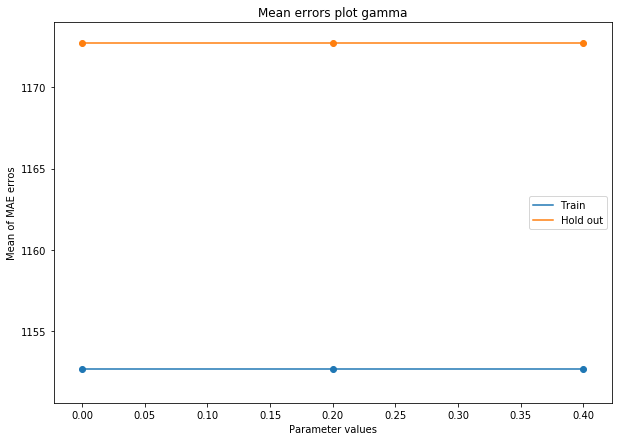

In [41]:
est=xgb.XGBRegressor(n_estimators=280,
                     max_depth=2,
                     min_child_weight=2,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'gamma':[i/10 for i in range(0,6,2)]}
model_fit(estimator=est,params=params,folds=3)

## 7.5 Column sample by tree

Best params: {'colsample_bytree': 1.0} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


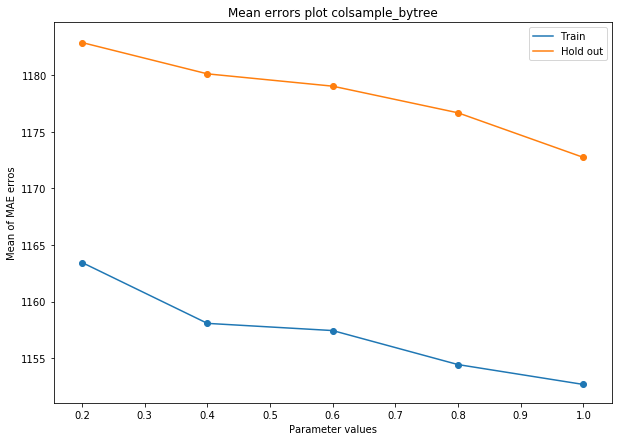

In [42]:
est=xgb.XGBRegressor(n_estimators=280,
                     max_depth=2,
                     min_child_weight=2,
                     gamma=0,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'colsample_bytree':[i/10 for i in range(2,11,2)]}
model_fit(estimator=est,params=params,folds=3)

Best params: {'colsample_bytree': 1.0} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


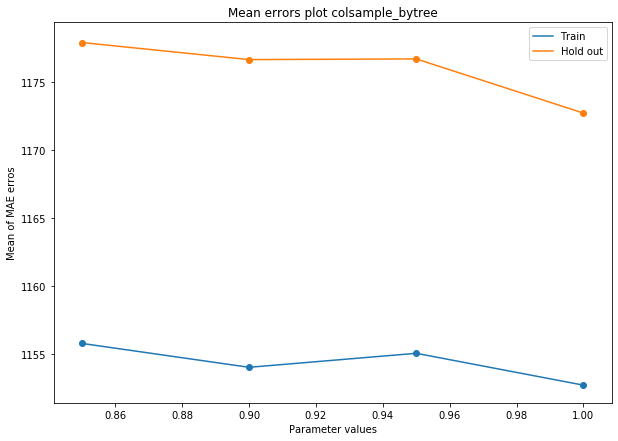

In [44]:
est=xgb.XGBRegressor(n_estimators=280,
                     max_depth=2,
                     min_child_weight=2,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'colsample_bytree':[i/100 for i in range(85,101,5)]}
model_fit(estimator=est,params=params,folds=3)

## 7.6 Colsample by level

Best params: {'colsample_bylevel': 1.0} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


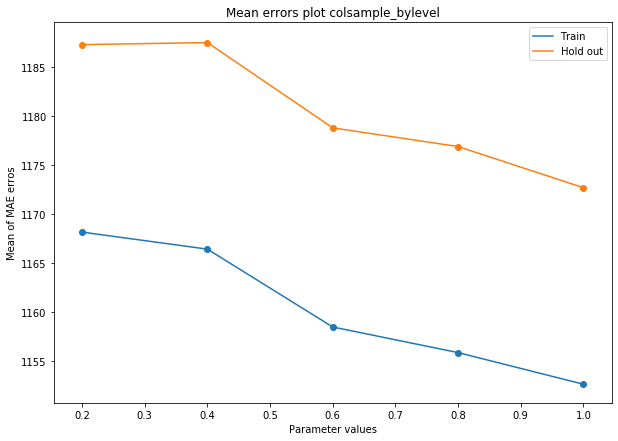

In [45]:
est=xgb.XGBRegressor(n_estimators=280,
                     max_depth=2,
                     min_child_weight=2,
                     colsample_bytree=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'colsample_bylevel':[i/10 for i in range(2,11,2)]}
model_fit(estimator=est,params=params,folds=3)

## 7.7 alpha

Best params: {'reg_alpha': 1.0} Best score: 1172.734952833957 Mean train score: 1152.6798531215038


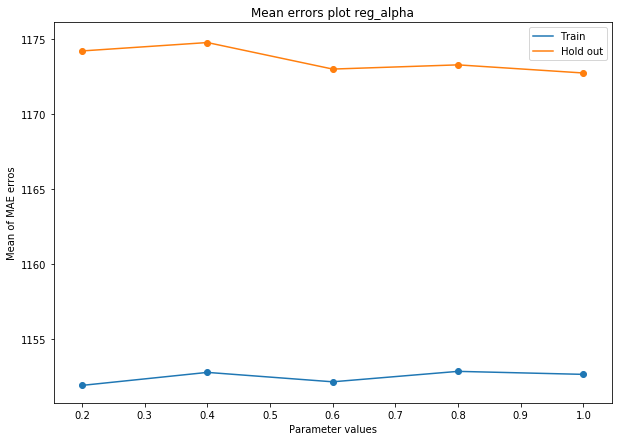

In [46]:
est=xgb.XGBRegressor(n_estimators=280,
                     max_depth=2,
                     min_child_weight=2,
                     colsample_bytree=1,
                     colsample_level=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'reg_alpha':[i/10 for i in range(2,11,2)]}
model_fit(estimator=est,params=params,folds=3)

Now that we have fixed all hyper-parameter we cab reduce learning rate for more robust values and so we have to recalibrate boosting rounds<br>
## 7.8 Reducing learning rate and recalculating boosting rounds

In [126]:
est=xgb.XGBRegressor(n_estimators=10000,
                     max_depth=2,
                     min_child_weight=2,
                     colsample_bytree=1,
                     colsample_bylevel=1,
                     learning_rate=0.01,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:3038.8+2.4206	train-rmse:6.56849+0.00199339	test-Error:3038.8+4.84124	test-rmse:6.56848+0.00402766
[1]	train-Error:3038.74+2.42058	train-rmse:6.505+0.00197244	test-Error:3038.74+4.84126	test-rmse:6.505+0.0040263
[2]	train-Error:3038.67+2.42054	train-rmse:6.44217+0.00195282	test-Error:3038.67+4.84129	test-rmse:6.44217+0.00403326
[3]	train-Error:3038.57+2.42043	train-rmse:6.38+0.00193342	test-Error:3038.57+4.84139	test-rmse:6.38+0.00404698
[4]	train-Error:3038.44+2.42033	train-rmse:6.31846+0.00191382	test-Error:3038.44+4.84147	test-rmse:6.31847+0.00405609
[5]	train-Error:3038.29+2.42013	train-rmse:6.25757+0.00189589	test-Error:3038.29+4.84166	test-rmse:6.25758+0.00407762
[6]	train-Error:3038.1+2.41993	train-rmse:6.19731+0.00187555	test-Error:3038.1+4.84183	test-rmse:6.19732+0.00408794
[7]	train-Error:3037.87+2.4196	train-rmse:6.13766+0.00185826	test-Error:3037.87+4.84214	test-rmse:6.13768+0.00411165
[8]	train-Error:3037.6+2.41941	train-rmse:6.07864+0.00183989	test-Error:3

[70]	train-Error:2816.08+2.21556	train-rmse:3.41077+0.00114057	test-Error:2816.09+5.16346	test-rmse:3.41083+0.00611593
[71]	train-Error:2808.53+2.21683	train-rmse:3.38077+0.00113399	test-Error:2808.53+5.17147	test-rmse:3.38082+0.00613536
[72]	train-Error:2800.87+2.20093	train-rmse:3.3511+0.00112862	test-Error:2800.88+5.19971	test-rmse:3.35116+0.0061692
[73]	train-Error:2793.1+2.20011	train-rmse:3.32176+0.00112246	test-Error:2793.11+5.21253	test-rmse:3.32181+0.00619197
[74]	train-Error:2785.24+2.19497	train-rmse:3.29275+0.00111657	test-Error:2785.25+5.22422	test-rmse:3.29281+0.00620976
[75]	train-Error:2777.25+2.18353	train-rmse:3.26407+0.0011103	test-Error:2777.26+5.25251	test-rmse:3.26412+0.00623998
[76]	train-Error:2769.18+2.16766	train-rmse:3.23571+0.00110517	test-Error:2769.19+5.27874	test-rmse:3.23578+0.00626596
[77]	train-Error:2760.99+2.16846	train-rmse:3.20766+0.00110072	test-Error:2761+5.28978	test-rmse:3.20773+0.00629209
[78]	train-Error:2752.72+2.16206	train-rmse:3.17993+0.0

[139]	train-Error:2168.44+1.87848	train-rmse:1.97877+0.00106516	test-Error:2168.53+6.85167	test-rmse:1.97895+0.00677922
[140]	train-Error:2159.13+1.88483	train-rmse:1.96566+0.00106948	test-Error:2159.23+6.85658	test-rmse:1.96583+0.00676427
[141]	train-Error:2149.88+1.92284	train-rmse:1.95272+0.00106854	test-Error:2149.99+6.81337	test-rmse:1.95291+0.00675546
[142]	train-Error:2140.71+1.87661	train-rmse:1.93995+0.00106913	test-Error:2140.82+6.87606	test-rmse:1.94014+0.00676168
[143]	train-Error:2131.53+1.87807	train-rmse:1.92731+0.00107482	test-Error:2131.63+6.87929	test-rmse:1.9275+0.00676183
[144]	train-Error:2122.45+1.91139	train-rmse:1.91488+0.0010813	test-Error:2122.56+6.82824	test-rmse:1.91507+0.00674378
[145]	train-Error:2113.41+1.92303	train-rmse:1.90258+0.00108545	test-Error:2113.52+6.83907	test-rmse:1.90277+0.00674316
[146]	train-Error:2104.45+1.93002	train-rmse:1.89046+0.00107966	test-Error:2104.56+6.87011	test-rmse:1.89065+0.00675599
[147]	train-Error:2095.56+1.88615	train-rm

[208]	train-Error:1688.16+2.22915	train-rmse:1.39314+0.00137176	test-Error:1688.42+6.47517	test-rmse:1.39346+0.00583267
[209]	train-Error:1683.66+2.29079	train-rmse:1.38832+0.00137708	test-Error:1683.93+6.37127	test-rmse:1.38865+0.00580052
[210]	train-Error:1679.21+2.23773	train-rmse:1.38355+0.00137991	test-Error:1679.49+6.3961	test-rmse:1.38388+0.00578184
[211]	train-Error:1674.76+2.25641	train-rmse:1.37884+0.00138863	test-Error:1675.05+6.34396	test-rmse:1.37918+0.00575785
[212]	train-Error:1670.43+2.2127	train-rmse:1.37421+0.00138841	test-Error:1670.71+6.36878	test-rmse:1.37455+0.00572864
[213]	train-Error:1666.17+2.24523	train-rmse:1.36967+0.00138717	test-Error:1666.46+6.28154	test-rmse:1.37002+0.0056922
[214]	train-Error:1661.86+2.20648	train-rmse:1.36516+0.00138741	test-Error:1662.16+6.30012	test-rmse:1.36552+0.0056727
[215]	train-Error:1657.59+2.22661	train-rmse:1.36074+0.00139713	test-Error:1657.88+6.27785	test-rmse:1.3611+0.00566064
[216]	train-Error:1653.46+2.21386	train-rmse:

[277]	train-Error:1483.69+2.57302	train-rmse:1.18749+0.00146044	test-Error:1484.39+5.1199	test-rmse:1.18813+0.00427534
[278]	train-Error:1481.95+2.51051	train-rmse:1.18587+0.00146302	test-Error:1482.64+5.1679	test-rmse:1.18651+0.00426812
[279]	train-Error:1480.2+2.53356	train-rmse:1.18424+0.00148488	test-Error:1480.89+5.13791	test-rmse:1.18489+0.00423876
[280]	train-Error:1478.49+2.53865	train-rmse:1.18268+0.0014713	test-Error:1479.19+5.10117	test-rmse:1.18333+0.00421971
[281]	train-Error:1476.82+2.59888	train-rmse:1.18111+0.00147475	test-Error:1477.52+5.02225	test-rmse:1.18176+0.00418408
[282]	train-Error:1475.12+2.59848	train-rmse:1.17958+0.00147287	test-Error:1475.84+5.03139	test-rmse:1.18023+0.0041725
[283]	train-Error:1473.51+2.5735	train-rmse:1.17806+0.00145339	test-Error:1474.23+5.07359	test-rmse:1.17871+0.00418683
[284]	train-Error:1471.81+2.62613	train-rmse:1.17658+0.00147797	test-Error:1472.54+5.01028	test-rmse:1.17723+0.00413494
[285]	train-Error:1470.28+2.58917	train-rmse:1

[346]	train-Error:1403.18+2.68572	train-rmse:1.11659+0.0015327	test-Error:1404.23+4.30685	test-rmse:1.11745+0.00319532
[347]	train-Error:1402.43+2.71105	train-rmse:1.11598+0.00153611	test-Error:1403.5+4.32663	test-rmse:1.11685+0.00319408
[348]	train-Error:1401.69+2.67052	train-rmse:1.11538+0.00152317	test-Error:1402.75+4.34408	test-rmse:1.11624+0.00321026
[349]	train-Error:1400.98+2.70602	train-rmse:1.11478+0.00152282	test-Error:1402.04+4.28005	test-rmse:1.11565+0.00317842
[350]	train-Error:1400.28+2.72469	train-rmse:1.11422+0.00151226	test-Error:1401.36+4.28656	test-rmse:1.1151+0.00317603
[351]	train-Error:1399.62+2.67872	train-rmse:1.11365+0.00150749	test-Error:1400.7+4.29345	test-rmse:1.11453+0.00316436
[352]	train-Error:1398.87+2.67384	train-rmse:1.11306+0.00152504	test-Error:1399.95+4.3232	test-rmse:1.11395+0.00315185
[353]	train-Error:1398.16+2.7018	train-rmse:1.1125+0.00152925	test-Error:1399.27+4.29608	test-rmse:1.1134+0.00313409
[354]	train-Error:1397.49+2.70616	train-rmse:1.1

[415]	train-Error:1365.49+2.6102	train-rmse:1.08711+0.00150615	test-Error:1366.73+4.04863	test-rmse:1.08816+0.0026929
[416]	train-Error:1365.11+2.60911	train-rmse:1.08682+0.00151326	test-Error:1366.36+4.07469	test-rmse:1.08787+0.00267499
[417]	train-Error:1364.71+2.61123	train-rmse:1.08652+0.00151373	test-Error:1365.96+4.07084	test-rmse:1.08757+0.00266008
[418]	train-Error:1364.26+2.6375	train-rmse:1.0862+0.00152348	test-Error:1365.51+4.06453	test-rmse:1.08725+0.00264175
[419]	train-Error:1363.91+2.60059	train-rmse:1.08591+0.00152247	test-Error:1365.15+4.07623	test-rmse:1.08696+0.00264079
[420]	train-Error:1363.5+2.59394	train-rmse:1.08562+0.0015145	test-Error:1364.76+4.02949	test-rmse:1.08668+0.00263199
[421]	train-Error:1363.09+2.56036	train-rmse:1.08533+0.00150527	test-Error:1364.36+4.07398	test-rmse:1.08639+0.00264368
[422]	train-Error:1362.68+2.58573	train-rmse:1.08504+0.00150836	test-Error:1363.96+4.0597	test-rmse:1.0861+0.00263803
[423]	train-Error:1362.32+2.60982	train-rmse:1.0

[484]	train-Error:1342.05+2.53719	train-rmse:1.07013+0.00151015	test-Error:1343.52+3.89181	test-rmse:1.07132+0.00242258
[485]	train-Error:1341.76+2.52632	train-rmse:1.06993+0.00150544	test-Error:1343.24+3.89289	test-rmse:1.07112+0.002425
[486]	train-Error:1341.48+2.539	train-rmse:1.06971+0.00152688	test-Error:1342.96+3.89759	test-rmse:1.07091+0.00241764
[487]	train-Error:1341.26+2.57731	train-rmse:1.06953+0.00152476	test-Error:1342.76+3.86985	test-rmse:1.07074+0.0024161
[488]	train-Error:1340.92+2.54522	train-rmse:1.06933+0.0015144	test-Error:1342.43+3.86711	test-rmse:1.07054+0.00240944
[489]	train-Error:1340.62+2.54886	train-rmse:1.06912+0.00149567	test-Error:1342.12+3.83347	test-rmse:1.07034+0.00239924
[490]	train-Error:1340.31+2.56192	train-rmse:1.06893+0.0015038	test-Error:1341.84+3.83987	test-rmse:1.07015+0.00238733
[491]	train-Error:1340.07+2.52415	train-rmse:1.06872+0.00149404	test-Error:1341.58+3.8556	test-rmse:1.06994+0.00238826
[492]	train-Error:1339.81+2.54611	train-rmse:1.0

[553]	train-Error:1324.68+2.52028	train-rmse:1.05762+0.00154336	test-Error:1326.35+3.67028	test-rmse:1.05893+0.00221484
[554]	train-Error:1324.45+2.51232	train-rmse:1.05746+0.00154634	test-Error:1326.12+3.67716	test-rmse:1.05878+0.00221273
[555]	train-Error:1324.21+2.50504	train-rmse:1.05731+0.00154878	test-Error:1325.88+3.67767	test-rmse:1.05863+0.00221199
[556]	train-Error:1323.97+2.54111	train-rmse:1.05714+0.00156461	test-Error:1325.65+3.64732	test-rmse:1.05847+0.0021905
[557]	train-Error:1323.75+2.54409	train-rmse:1.05697+0.00157201	test-Error:1325.44+3.64894	test-rmse:1.0583+0.00219432
[558]	train-Error:1323.51+2.55196	train-rmse:1.05683+0.00157044	test-Error:1325.21+3.65262	test-rmse:1.05816+0.00219144
[559]	train-Error:1323.29+2.56272	train-rmse:1.05666+0.00156912	test-Error:1324.98+3.63014	test-rmse:1.05799+0.00218403
[560]	train-Error:1323.05+2.54294	train-rmse:1.05651+0.00156608	test-Error:1324.74+3.6471	test-rmse:1.05785+0.00219757
[561]	train-Error:1322.89+2.53714	train-rms

[622]	train-Error:1310.56+2.47581	train-rmse:1.04749+0.00160312	test-Error:1312.41+3.47222	test-rmse:1.04897+0.00211034
[623]	train-Error:1310.35+2.47751	train-rmse:1.04735+0.00160421	test-Error:1312.21+3.45662	test-rmse:1.04883+0.00211343
[624]	train-Error:1310.15+2.50764	train-rmse:1.04722+0.00159915	test-Error:1312+3.42016	test-rmse:1.04869+0.00210118
[625]	train-Error:1309.94+2.49001	train-rmse:1.04707+0.00159286	test-Error:1311.8+3.42919	test-rmse:1.04855+0.00210935
[626]	train-Error:1309.76+2.48644	train-rmse:1.04695+0.00159999	test-Error:1311.62+3.44188	test-rmse:1.04842+0.00210183
[627]	train-Error:1309.6+2.46298	train-rmse:1.04682+0.00159977	test-Error:1311.46+3.47752	test-rmse:1.0483+0.00210533
[628]	train-Error:1309.38+2.45429	train-rmse:1.04668+0.00158119	test-Error:1311.24+3.46773	test-rmse:1.04815+0.00211084
[629]	train-Error:1309.18+2.46523	train-rmse:1.04654+0.00159782	test-Error:1311.05+3.46218	test-rmse:1.04802+0.00209845
[630]	train-Error:1309+2.47539	train-rmse:1.04

[691]	train-Error:1298.56+2.38117	train-rmse:1.03892+0.00159065	test-Error:1300.58+3.30211	test-rmse:1.04052+0.00206686
[692]	train-Error:1298.37+2.36722	train-rmse:1.03879+0.00159061	test-Error:1300.41+3.33888	test-rmse:1.04041+0.00207818
[693]	train-Error:1298.22+2.38027	train-rmse:1.03868+0.00159234	test-Error:1300.26+3.35592	test-rmse:1.04029+0.00208807
[694]	train-Error:1298.05+2.38179	train-rmse:1.03856+0.00159268	test-Error:1300.08+3.33859	test-rmse:1.04018+0.00209214
[695]	train-Error:1297.86+2.36346	train-rmse:1.03844+0.00158564	test-Error:1299.9+3.34092	test-rmse:1.04005+0.00208037
[696]	train-Error:1297.71+2.3657	train-rmse:1.03832+0.00158761	test-Error:1299.75+3.32794	test-rmse:1.03995+0.00207126
[697]	train-Error:1297.53+2.38764	train-rmse:1.03821+0.00158499	test-Error:1299.58+3.30963	test-rmse:1.03983+0.00207339
[698]	train-Error:1297.37+2.37385	train-rmse:1.03809+0.00158846	test-Error:1299.42+3.31935	test-rmse:1.03972+0.0020755
[699]	train-Error:1297.25+2.36902	train-rms

[760]	train-Error:1288.23+2.26035	train-rmse:1.03157+0.0015913	test-Error:1290.43+3.22135	test-rmse:1.03334+0.00204655
[761]	train-Error:1288.09+2.23595	train-rmse:1.03148+0.00158855	test-Error:1290.31+3.24463	test-rmse:1.03325+0.0020481
[762]	train-Error:1287.95+2.23235	train-rmse:1.03138+0.00159217	test-Error:1290.17+3.23265	test-rmse:1.03316+0.00204326
[763]	train-Error:1287.84+2.23151	train-rmse:1.03129+0.00159159	test-Error:1290.06+3.23597	test-rmse:1.03307+0.00204515
[764]	train-Error:1287.7+2.22429	train-rmse:1.0312+0.00159054	test-Error:1289.93+3.24828	test-rmse:1.03298+0.00205495
[765]	train-Error:1287.56+2.22964	train-rmse:1.0311+0.00159586	test-Error:1289.81+3.25597	test-rmse:1.03288+0.00205637
[766]	train-Error:1287.44+2.2356	train-rmse:1.031+0.00159363	test-Error:1289.68+3.23194	test-rmse:1.03279+0.00204845
[767]	train-Error:1287.29+2.23888	train-rmse:1.0309+0.00158704	test-Error:1289.53+3.23666	test-rmse:1.03269+0.00205991
[768]	train-Error:1287.17+2.23244	train-rmse:1.03

[829]	train-Error:1279.38+2.15764	train-rmse:1.02521+0.00162116	test-Error:1281.81+3.24128	test-rmse:1.02715+0.00205816
[830]	train-Error:1279.27+2.14455	train-rmse:1.02512+0.00160874	test-Error:1281.7+3.25252	test-rmse:1.02706+0.00206977
[831]	train-Error:1279.16+2.15486	train-rmse:1.02503+0.00161434	test-Error:1281.59+3.24909	test-rmse:1.02698+0.0020729
[832]	train-Error:1279.03+2.13963	train-rmse:1.02495+0.00161779	test-Error:1281.46+3.24242	test-rmse:1.02689+0.00206799
[833]	train-Error:1278.92+2.13333	train-rmse:1.02487+0.00161556	test-Error:1281.35+3.23985	test-rmse:1.02682+0.00206932
[834]	train-Error:1278.79+2.14686	train-rmse:1.02479+0.00161328	test-Error:1281.23+3.22695	test-rmse:1.02674+0.00206986
[835]	train-Error:1278.67+2.15801	train-rmse:1.0247+0.00161655	test-Error:1281.11+3.23376	test-rmse:1.02666+0.00207354
[836]	train-Error:1278.55+2.18574	train-rmse:1.02462+0.00161929	test-Error:1280.98+3.20945	test-rmse:1.02657+0.00207176
[837]	train-Error:1278.42+2.17292	train-rms

[898]	train-Error:1271.62+2.13728	train-rmse:1.01969+0.00164578	test-Error:1274.21+3.2468	test-rmse:1.02178+0.00207514
[899]	train-Error:1271.5+2.14074	train-rmse:1.01961+0.00164148	test-Error:1274.09+3.25174	test-rmse:1.0217+0.00208715
[900]	train-Error:1271.39+2.13584	train-rmse:1.01954+0.00164457	test-Error:1273.98+3.25646	test-rmse:1.02162+0.00208565
[901]	train-Error:1271.29+2.12941	train-rmse:1.01946+0.00164201	test-Error:1273.88+3.25411	test-rmse:1.02155+0.00208592
[902]	train-Error:1271.19+2.1443	train-rmse:1.01938+0.00164807	test-Error:1273.8+3.2428	test-rmse:1.02149+0.00208266
[903]	train-Error:1271.09+2.14454	train-rmse:1.01931+0.00164322	test-Error:1273.7+3.23899	test-rmse:1.02142+0.00208546
[904]	train-Error:1270.99+2.12925	train-rmse:1.01924+0.00164182	test-Error:1273.6+3.25361	test-rmse:1.02134+0.00208537
[905]	train-Error:1270.9+2.15	train-rmse:1.01917+0.00164224	test-Error:1273.5+3.23352	test-rmse:1.02128+0.00208279
[906]	train-Error:1270.79+2.15489	train-rmse:1.01909+

[967]	train-Error:1264.8+2.08304	train-rmse:1.01481+0.00163691	test-Error:1267.58+3.33875	test-rmse:1.01707+0.00216726
[968]	train-Error:1264.7+2.09112	train-rmse:1.01475+0.00163552	test-Error:1267.49+3.34432	test-rmse:1.01701+0.00216723
[969]	train-Error:1264.6+2.07498	train-rmse:1.01469+0.0016356	test-Error:1267.39+3.35564	test-rmse:1.01695+0.00217332
[970]	train-Error:1264.5+2.0657	train-rmse:1.01462+0.00163951	test-Error:1267.3+3.35472	test-rmse:1.01688+0.00216591
[971]	train-Error:1264.4+2.06433	train-rmse:1.01454+0.00163633	test-Error:1267.21+3.34658	test-rmse:1.01681+0.00216739
[972]	train-Error:1264.31+2.06202	train-rmse:1.01448+0.00163265	test-Error:1267.12+3.34494	test-rmse:1.01675+0.00216836
[973]	train-Error:1264.22+2.06232	train-rmse:1.01441+0.00163436	test-Error:1267.03+3.35036	test-rmse:1.01669+0.00217026
[974]	train-Error:1264.14+2.05936	train-rmse:1.01435+0.00163078	test-Error:1266.95+3.3573	test-rmse:1.01662+0.00217388
[975]	train-Error:1264.06+2.0486	train-rmse:1.014

[1036]	train-Error:1258.74+2.02406	train-rmse:1.01049+0.00161377	test-Error:1261.72+3.4319	test-rmse:1.01291+0.00227513
[1037]	train-Error:1258.66+2.02417	train-rmse:1.01043+0.00161978	test-Error:1261.64+3.43711	test-rmse:1.01285+0.00227204
[1038]	train-Error:1258.59+2.03258	train-rmse:1.01037+0.0016222	test-Error:1261.57+3.4301	test-rmse:1.0128+0.00227338
[1039]	train-Error:1258.49+2.01772	train-rmse:1.01031+0.00161732	test-Error:1261.48+3.43991	test-rmse:1.01273+0.00227773
[1040]	train-Error:1258.4+2.00266	train-rmse:1.01025+0.0016163	test-Error:1261.39+3.4585	test-rmse:1.01268+0.00227786
[1041]	train-Error:1258.33+2.00207	train-rmse:1.01019+0.0016157	test-Error:1261.32+3.45002	test-rmse:1.01262+0.00227809
[1042]	train-Error:1258.24+2.00126	train-rmse:1.01014+0.0016176	test-Error:1261.23+3.45547	test-rmse:1.01257+0.00227521
[1043]	train-Error:1258.17+2.00312	train-rmse:1.01008+0.0016182	test-Error:1261.16+3.44791	test-rmse:1.01252+0.00227437
[1044]	train-Error:1258.08+2.01282	train-r

[1105]	train-Error:1253.29+2.06242	train-rmse:1.00661+0.00169534	test-Error:1256.45+3.41848	test-rmse:1.00918+0.0022777
[1106]	train-Error:1253.21+2.05537	train-rmse:1.00656+0.0016947	test-Error:1256.37+3.42948	test-rmse:1.00913+0.00227405
[1107]	train-Error:1253.13+2.06662	train-rmse:1.00651+0.00169634	test-Error:1256.29+3.41947	test-rmse:1.00907+0.00227389
[1108]	train-Error:1253.05+2.06312	train-rmse:1.00645+0.0016982	test-Error:1256.21+3.42053	test-rmse:1.00902+0.00227353
[1109]	train-Error:1252.96+2.07742	train-rmse:1.0064+0.00169506	test-Error:1256.12+3.41812	test-rmse:1.00897+0.00228387
[1110]	train-Error:1252.89+2.0764	train-rmse:1.00635+0.00169797	test-Error:1256.05+3.41311	test-rmse:1.00891+0.00227888
[1111]	train-Error:1252.8+2.10217	train-rmse:1.00628+0.00171209	test-Error:1255.95+3.3772	test-rmse:1.00884+0.00225908
[1112]	train-Error:1252.72+2.10114	train-rmse:1.00622+0.00171285	test-Error:1255.88+3.38413	test-rmse:1.0088+0.0022629
[1113]	train-Error:1252.63+2.09512	train-

[1174]	train-Error:1248.28+2.13099	train-rmse:1.00308+0.00177759	test-Error:1251.58+3.37596	test-rmse:1.00576+0.00228303
[1175]	train-Error:1248.22+2.13691	train-rmse:1.00304+0.00177788	test-Error:1251.53+3.36558	test-rmse:1.00572+0.00228204
[1176]	train-Error:1248.15+2.15394	train-rmse:1.00299+0.00177634	test-Error:1251.46+3.35461	test-rmse:1.00568+0.00228577
[1177]	train-Error:1248.08+2.15583	train-rmse:1.00295+0.00177777	test-Error:1251.4+3.35335	test-rmse:1.00563+0.00228625
[1178]	train-Error:1248.02+2.15866	train-rmse:1.0029+0.00177917	test-Error:1251.34+3.35864	test-rmse:1.00558+0.00229102
[1179]	train-Error:1247.96+2.16075	train-rmse:1.00285+0.00177961	test-Error:1251.27+3.35485	test-rmse:1.00553+0.00228898
[1180]	train-Error:1247.9+2.16416	train-rmse:1.00281+0.00178065	test-Error:1251.21+3.34967	test-rmse:1.00549+0.00228886
[1181]	train-Error:1247.8+2.17873	train-rmse:1.00275+0.00179484	test-Error:1251.11+3.34145	test-rmse:1.00543+0.00227882
[1182]	train-Error:1247.72+2.16768	t

[1243]	train-Error:1243.77+2.18087	train-rmse:0.99989+0.00179543	test-Error:1247.25+3.43612	test-rmse:1.00269+0.00238979
[1244]	train-Error:1243.71+2.1698	train-rmse:0.999842+0.00179609	test-Error:1247.17+3.444	test-rmse:1.00265+0.00238979
[1245]	train-Error:1243.65+2.16645	train-rmse:0.999801+0.00179393	test-Error:1247.11+3.44791	test-rmse:1.00261+0.00239417
[1246]	train-Error:1243.6+2.16419	train-rmse:0.999761+0.0017938	test-Error:1247.06+3.44826	test-rmse:1.00257+0.00239349
[1247]	train-Error:1243.54+2.16758	train-rmse:0.99972+0.00179496	test-Error:1247.01+3.43927	test-rmse:1.00253+0.00239128
[1248]	train-Error:1243.48+2.15672	train-rmse:0.999679+0.0017939	test-Error:1246.95+3.45701	test-rmse:1.00249+0.00239523
[1249]	train-Error:1243.42+2.15576	train-rmse:0.999641+0.00179436	test-Error:1246.9+3.45937	test-rmse:1.00245+0.00239619
[1250]	train-Error:1243.34+2.1631	train-rmse:0.999584+0.00180503	test-Error:1246.81+3.45539	test-rmse:1.00239+0.00239132
[1251]	train-Error:1243.29+2.15956

[1311]	train-Error:1239.77+2.1253	train-rmse:0.997044+0.00181237	test-Error:1243.38+3.54729	test-rmse:0.999975+0.00249552
[1312]	train-Error:1239.72+2.12137	train-rmse:0.997007+0.00181107	test-Error:1243.33+3.55857	test-rmse:0.999936+0.00250345
[1313]	train-Error:1239.67+2.11917	train-rmse:0.996971+0.00181113	test-Error:1243.29+3.56667	test-rmse:0.999902+0.00251013
[1314]	train-Error:1239.63+2.12135	train-rmse:0.996934+0.00181038	test-Error:1243.25+3.56249	test-rmse:0.999866+0.0025079
[1315]	train-Error:1239.58+2.11605	train-rmse:0.996896+0.00180822	test-Error:1243.2+3.56577	test-rmse:0.999832+0.00250906
[1316]	train-Error:1239.53+2.1209	train-rmse:0.996861+0.00180961	test-Error:1243.15+3.56095	test-rmse:0.9998+0.0025054
[1317]	train-Error:1239.48+2.12371	train-rmse:0.996824+0.00181318	test-Error:1243.09+3.56247	test-rmse:0.999764+0.002507
[1318]	train-Error:1239.39+2.12314	train-rmse:0.996772+0.00181206	test-Error:1243.01+3.57184	test-rmse:0.999714+0.00251453
[1319]	train-Error:1239.3

[1379]	train-Error:1236.07+2.0435	train-rmse:0.994439+0.00179193	test-Error:1239.86+3.63396	test-rmse:0.9975+0.00258182
[1380]	train-Error:1236.01+2.05159	train-rmse:0.994401+0.00179414	test-Error:1239.8+3.61681	test-rmse:0.997466+0.00257563
[1381]	train-Error:1235.96+2.05315	train-rmse:0.994367+0.00179428	test-Error:1239.76+3.61398	test-rmse:0.997434+0.00257408
[1382]	train-Error:1235.92+2.05431	train-rmse:0.994334+0.00179392	test-Error:1239.72+3.61222	test-rmse:0.997405+0.0025696
[1383]	train-Error:1235.87+2.05469	train-rmse:0.9943+0.0017959	test-Error:1239.67+3.60734	test-rmse:0.997374+0.00257029
[1384]	train-Error:1235.82+2.0541	train-rmse:0.994266+0.00179598	test-Error:1239.63+3.60576	test-rmse:0.997339+0.00257059
[1385]	train-Error:1235.76+2.03565	train-rmse:0.994221+0.00178421	test-Error:1239.57+3.61163	test-rmse:0.997299+0.00257739
[1386]	train-Error:1235.71+2.03133	train-rmse:0.994187+0.0017823	test-Error:1239.52+3.62111	test-rmse:0.997262+0.00258316
[1387]	train-Error:1235.67

[1447]	train-Error:1232.8+2.0218	train-rmse:0.99209+0.00179237	test-Error:1236.71+3.61199	test-rmse:0.995257+0.00263368
[1448]	train-Error:1232.76+2.01878	train-rmse:0.99206+0.001791	test-Error:1236.67+3.61858	test-rmse:0.995226+0.00263403
[1449]	train-Error:1232.71+2.02391	train-rmse:0.992027+0.0017925	test-Error:1236.63+3.61247	test-rmse:0.995199+0.00263413
[1450]	train-Error:1232.63+1.99652	train-rmse:0.99198+0.00177838	test-Error:1236.56+3.63767	test-rmse:0.995155+0.00264799
[1451]	train-Error:1232.59+2.00257	train-rmse:0.991947+0.00178577	test-Error:1236.52+3.62972	test-rmse:0.995123+0.00263903
[1452]	train-Error:1232.55+2.00198	train-rmse:0.991914+0.00178474	test-Error:1236.48+3.63425	test-rmse:0.995091+0.00264251
[1453]	train-Error:1232.5+2.01261	train-rmse:0.991882+0.00178989	test-Error:1236.43+3.62117	test-rmse:0.995061+0.00263811
[1454]	train-Error:1232.46+2.01759	train-rmse:0.991848+0.00179049	test-Error:1236.38+3.62012	test-rmse:0.995025+0.00264215
[1455]	train-Error:1232.4

[1515]	train-Error:1229.79+1.96237	train-rmse:0.989923+0.00177792	test-Error:1233.82+3.62307	test-rmse:0.993197+0.0026778
[1516]	train-Error:1229.76+1.96196	train-rmse:0.989898+0.00177812	test-Error:1233.79+3.62066	test-rmse:0.993174+0.00267406
[1517]	train-Error:1229.71+1.97278	train-rmse:0.989869+0.00178107	test-Error:1233.75+3.60108	test-rmse:0.993147+0.00266612
[1518]	train-Error:1229.68+1.98024	train-rmse:0.989842+0.00178427	test-Error:1233.71+3.59189	test-rmse:0.993122+0.00266296
[1519]	train-Error:1229.64+1.9812	train-rmse:0.989811+0.00178283	test-Error:1233.67+3.5954	test-rmse:0.993092+0.0026658
[1520]	train-Error:1229.58+1.96942	train-rmse:0.989776+0.00177868	test-Error:1233.62+3.61654	test-rmse:0.99306+0.00267876
[1521]	train-Error:1229.53+1.95442	train-rmse:0.989738+0.00176995	test-Error:1233.57+3.62022	test-rmse:0.993022+0.0026816
[1522]	train-Error:1229.49+1.95289	train-rmse:0.98971+0.00176871	test-Error:1233.54+3.61686	test-rmse:0.992997+0.00267889
[1523]	train-Error:1229

[1583]	train-Error:1227.13+1.92691	train-rmse:0.988003+0.00177852	test-Error:1231.28+3.57584	test-rmse:0.991392+0.00269857
[1584]	train-Error:1227.1+1.93571	train-rmse:0.987977+0.00177996	test-Error:1231.25+3.56418	test-rmse:0.991366+0.00269785
[1585]	train-Error:1227.07+1.93684	train-rmse:0.987953+0.0017797	test-Error:1231.22+3.56251	test-rmse:0.991345+0.0027001
[1586]	train-Error:1227.02+1.92732	train-rmse:0.987919+0.00177806	test-Error:1231.17+3.57924	test-rmse:0.991312+0.00270828
[1587]	train-Error:1226.99+1.92755	train-rmse:0.987893+0.00177701	test-Error:1231.14+3.57619	test-rmse:0.991289+0.00270982
[1588]	train-Error:1226.94+1.91107	train-rmse:0.98786+0.00176747	test-Error:1231.1+3.58264	test-rmse:0.991257+0.0027135
[1589]	train-Error:1226.9+1.91054	train-rmse:0.987832+0.00176779	test-Error:1231.06+3.58593	test-rmse:0.991232+0.00271606
[1590]	train-Error:1226.87+1.90813	train-rmse:0.987805+0.00176623	test-Error:1231.03+3.58853	test-rmse:0.991206+0.00271771
[1591]	train-Error:1226

[1651]	train-Error:1224.75+1.88891	train-rmse:0.986248+0.00177225	test-Error:1229.03+3.53213	test-rmse:0.989744+0.00272376
[1652]	train-Error:1224.71+1.89897	train-rmse:0.986222+0.00177684	test-Error:1228.99+3.52025	test-rmse:0.98972+0.0027205
[1653]	train-Error:1224.67+1.89327	train-rmse:0.986198+0.0017772	test-Error:1228.96+3.52117	test-rmse:0.989698+0.00271812
[1654]	train-Error:1224.64+1.89343	train-rmse:0.986173+0.00177708	test-Error:1228.93+3.5238	test-rmse:0.989677+0.00272179
[1655]	train-Error:1224.61+1.89017	train-rmse:0.986151+0.001778	test-Error:1228.9+3.5284	test-rmse:0.989656+0.00272055
[1656]	train-Error:1224.57+1.8862	train-rmse:0.986123+0.0017749	test-Error:1228.87+3.52885	test-rmse:0.989631+0.00272204
[1657]	train-Error:1224.54+1.88839	train-rmse:0.986101+0.00177517	test-Error:1228.84+3.52778	test-rmse:0.989608+0.00272256
[1658]	train-Error:1224.51+1.88008	train-rmse:0.986076+0.00177325	test-Error:1228.81+3.54117	test-rmse:0.989587+0.0027304
[1659]	train-Error:1224.48+

[1719]	train-Error:1222.55+1.88715	train-rmse:0.984622+0.00177769	test-Error:1226.96+3.47405	test-rmse:0.988232+0.00275115
[1720]	train-Error:1222.51+1.90179	train-rmse:0.984598+0.00178292	test-Error:1226.92+3.46204	test-rmse:0.988208+0.00274791
[1721]	train-Error:1222.48+1.90308	train-rmse:0.984578+0.00178403	test-Error:1226.9+3.46047	test-rmse:0.988193+0.00274726
[1722]	train-Error:1222.46+1.89882	train-rmse:0.984557+0.00178421	test-Error:1226.87+3.4626	test-rmse:0.988173+0.00274828
[1723]	train-Error:1222.43+1.89843	train-rmse:0.984536+0.00178577	test-Error:1226.85+3.46124	test-rmse:0.988152+0.00274839
[1724]	train-Error:1222.41+1.89962	train-rmse:0.984516+0.00178706	test-Error:1226.82+3.45957	test-rmse:0.988129+0.00274753
[1725]	train-Error:1222.37+1.89086	train-rmse:0.984492+0.00178476	test-Error:1226.79+3.45857	test-rmse:0.988105+0.00274378
[1726]	train-Error:1222.34+1.88803	train-rmse:0.984467+0.00178582	test-Error:1226.77+3.46574	test-rmse:0.988087+0.00274909
[1727]	train-Error

[1786]	train-Error:1220.58+1.87296	train-rmse:0.983146+0.00177995	test-Error:1225.1+3.42608	test-rmse:0.986843+0.00275814
[1787]	train-Error:1220.54+1.86744	train-rmse:0.983123+0.00177849	test-Error:1225.07+3.42908	test-rmse:0.98682+0.00276016
[1788]	train-Error:1220.5+1.87444	train-rmse:0.983098+0.0017805	test-Error:1225.03+3.415	test-rmse:0.986796+0.00275632
[1789]	train-Error:1220.48+1.8716	train-rmse:0.983077+0.00177922	test-Error:1225+3.41562	test-rmse:0.986775+0.00275756
[1790]	train-Error:1220.46+1.87116	train-rmse:0.983059+0.00178046	test-Error:1224.99+3.41362	test-rmse:0.986758+0.00275728
[1791]	train-Error:1220.41+1.8588	train-rmse:0.98303+0.00177392	test-Error:1224.93+3.41805	test-rmse:0.986729+0.00276276
[1792]	train-Error:1220.38+1.85869	train-rmse:0.983009+0.00177333	test-Error:1224.91+3.41999	test-rmse:0.98671+0.00276415
[1793]	train-Error:1220.35+1.8591	train-rmse:0.982989+0.00177268	test-Error:1224.89+3.42316	test-rmse:0.986694+0.00276846
[1794]	train-Error:1220.33+1.8

[1854]	train-Error:1218.71+1.8293	train-rmse:0.981754+0.00175714	test-Error:1223.34+3.3708	test-rmse:0.985537+0.00277564
[1855]	train-Error:1218.68+1.83081	train-rmse:0.981735+0.00175639	test-Error:1223.32+3.36988	test-rmse:0.985521+0.00277703
[1856]	train-Error:1218.66+1.83207	train-rmse:0.981717+0.00175558	test-Error:1223.31+3.37112	test-rmse:0.985505+0.00278011
[1857]	train-Error:1218.64+1.83195	train-rmse:0.981698+0.00175377	test-Error:1223.29+3.37178	test-rmse:0.985487+0.00278288
[1858]	train-Error:1218.62+1.82851	train-rmse:0.981677+0.00175104	test-Error:1223.26+3.37424	test-rmse:0.985469+0.00278442
[1859]	train-Error:1218.6+1.82814	train-rmse:0.981659+0.0017503	test-Error:1223.24+3.37366	test-rmse:0.985451+0.00278472
[1860]	train-Error:1218.57+1.83034	train-rmse:0.981641+0.00175119	test-Error:1223.22+3.37443	test-rmse:0.985433+0.0027858
[1861]	train-Error:1218.55+1.83004	train-rmse:0.98162+0.0017503	test-Error:1223.19+3.37615	test-rmse:0.985412+0.00278689
[1862]	train-Error:1218

[1922]	train-Error:1216.94+1.80397	train-rmse:0.980428+0.00173672	test-Error:1221.69+3.35144	test-rmse:0.984296+0.00282301
[1923]	train-Error:1216.91+1.80417	train-rmse:0.980406+0.00173674	test-Error:1221.66+3.35631	test-rmse:0.984277+0.00282574
[1924]	train-Error:1216.88+1.81488	train-rmse:0.980388+0.00174103	test-Error:1221.63+3.34243	test-rmse:0.984261+0.00282081
[1925]	train-Error:1216.86+1.81301	train-rmse:0.980369+0.00173799	test-Error:1221.61+3.34403	test-rmse:0.984245+0.00282285
[1926]	train-Error:1216.83+1.81364	train-rmse:0.98035+0.00174125	test-Error:1221.59+3.34652	test-rmse:0.984226+0.00282142
[1927]	train-Error:1216.81+1.81469	train-rmse:0.980331+0.00174079	test-Error:1221.57+3.34608	test-rmse:0.984208+0.00282251
[1928]	train-Error:1216.78+1.81215	train-rmse:0.980315+0.00174107	test-Error:1221.54+3.34473	test-rmse:0.984191+0.00282269
[1929]	train-Error:1216.76+1.8125	train-rmse:0.980298+0.00174228	test-Error:1221.52+3.34163	test-rmse:0.984176+0.00282025
[1930]	train-Error

[1990]	train-Error:1215.23+1.79984	train-rmse:0.979164+0.00173272	test-Error:1220.08+3.33049	test-rmse:0.983102+0.00284715
[1991]	train-Error:1215.21+1.79709	train-rmse:0.979146+0.00173309	test-Error:1220.06+3.3354	test-rmse:0.983083+0.00285036
[1992]	train-Error:1215.18+1.79561	train-rmse:0.97913+0.00173126	test-Error:1220.03+3.33548	test-rmse:0.983067+0.00285206
[1993]	train-Error:1215.16+1.79539	train-rmse:0.979114+0.00173236	test-Error:1220.02+3.33736	test-rmse:0.983055+0.00285236
[1994]	train-Error:1215.13+1.78878	train-rmse:0.97909+0.00172793	test-Error:1219.99+3.35072	test-rmse:0.983032+0.00286051
[1995]	train-Error:1215.11+1.78646	train-rmse:0.979073+0.00172674	test-Error:1219.96+3.3546	test-rmse:0.983016+0.00286499
[1996]	train-Error:1215.09+1.78744	train-rmse:0.979058+0.00172628	test-Error:1219.95+3.35197	test-rmse:0.983004+0.0028647
[1997]	train-Error:1215.07+1.78468	train-rmse:0.979038+0.001725	test-Error:1219.93+3.3624	test-rmse:0.982988+0.00287036
[1998]	train-Error:1215.

[2057]	train-Error:1213.61+1.79991	train-rmse:0.977954+0.00173184	test-Error:1218.57+3.32742	test-rmse:0.981986+0.0028891
[2058]	train-Error:1213.59+1.80019	train-rmse:0.97794+0.00173118	test-Error:1218.55+3.32618	test-rmse:0.981971+0.00288965
[2059]	train-Error:1213.57+1.79942	train-rmse:0.977926+0.00173118	test-Error:1218.54+3.33093	test-rmse:0.981956+0.00289186
[2060]	train-Error:1213.55+1.79902	train-rmse:0.97791+0.00173184	test-Error:1218.52+3.3324	test-rmse:0.981942+0.00289323
[2061]	train-Error:1213.53+1.79909	train-rmse:0.977893+0.00173164	test-Error:1218.5+3.33013	test-rmse:0.981927+0.00289214
[2062]	train-Error:1213.5+1.79476	train-rmse:0.977876+0.00172968	test-Error:1218.47+3.3393	test-rmse:0.981911+0.00289658
[2063]	train-Error:1213.48+1.78783	train-rmse:0.977855+0.00172406	test-Error:1218.45+3.34077	test-rmse:0.981894+0.00289765
[2064]	train-Error:1213.45+1.78612	train-rmse:0.977836+0.00172164	test-Error:1218.43+3.34685	test-rmse:0.981876+0.00290241
[2065]	train-Error:1213

[2125]	train-Error:1212.06+1.81803	train-rmse:0.976793+0.00174549	test-Error:1217.15+3.30672	test-rmse:0.980915+0.00289711
[2126]	train-Error:1212.04+1.81824	train-rmse:0.976778+0.00174425	test-Error:1217.13+3.309	test-rmse:0.980902+0.00289927
[2127]	train-Error:1212.03+1.81814	train-rmse:0.976764+0.00174352	test-Error:1217.12+3.31048	test-rmse:0.980892+0.00290063
[2128]	train-Error:1211.99+1.82375	train-rmse:0.976744+0.00174408	test-Error:1217.09+3.30883	test-rmse:0.980871+0.00290374
[2129]	train-Error:1211.97+1.82489	train-rmse:0.976725+0.00174847	test-Error:1217.07+3.30926	test-rmse:0.980853+0.00290095
[2130]	train-Error:1211.96+1.82523	train-rmse:0.976712+0.00174893	test-Error:1217.05+3.30612	test-rmse:0.980841+0.00289955
[2131]	train-Error:1211.94+1.8257	train-rmse:0.976698+0.00174899	test-Error:1217.04+3.31604	test-rmse:0.980831+0.00290663
[2132]	train-Error:1211.92+1.82359	train-rmse:0.976684+0.00174925	test-Error:1217.02+3.31479	test-rmse:0.980817+0.00290793
[2133]	train-Error:

[2193]	train-Error:1210.58+1.88907	train-rmse:0.975677+0.00180236	test-Error:1215.81+3.22837	test-rmse:0.9799+0.00286009
[2194]	train-Error:1210.56+1.89043	train-rmse:0.975662+0.0018019	test-Error:1215.79+3.2303	test-rmse:0.979886+0.00286272
[2195]	train-Error:1210.54+1.88957	train-rmse:0.975648+0.00180042	test-Error:1215.78+3.23361	test-rmse:0.979874+0.00286432
[2196]	train-Error:1210.52+1.8976	train-rmse:0.975631+0.00180373	test-Error:1215.75+3.22621	test-rmse:0.979857+0.00286272
[2197]	train-Error:1210.49+1.89808	train-rmse:0.975615+0.00180369	test-Error:1215.73+3.22922	test-rmse:0.979841+0.0028642
[2198]	train-Error:1210.47+1.89313	train-rmse:0.975599+0.00180182	test-Error:1215.71+3.23609	test-rmse:0.979827+0.00286848
[2199]	train-Error:1210.44+1.89422	train-rmse:0.975578+0.00180599	test-Error:1215.68+3.23351	test-rmse:0.979806+0.00286174
[2200]	train-Error:1210.42+1.89663	train-rmse:0.975561+0.00180552	test-Error:1215.66+3.22718	test-rmse:0.979788+0.00286191
[2201]	train-Error:121

[2261]	train-Error:1209.18+1.91248	train-rmse:0.974621+0.00182487	test-Error:1214.54+3.18223	test-rmse:0.978943+0.00284643
[2262]	train-Error:1209.16+1.91218	train-rmse:0.974607+0.00182412	test-Error:1214.53+3.18191	test-rmse:0.97893+0.0028473
[2263]	train-Error:1209.14+1.91245	train-rmse:0.974596+0.00182429	test-Error:1214.51+3.18455	test-rmse:0.97892+0.00284783
[2264]	train-Error:1209.13+1.91244	train-rmse:0.974584+0.00182354	test-Error:1214.5+3.1817	test-rmse:0.978908+0.0028476
[2265]	train-Error:1209.1+1.91681	train-rmse:0.974565+0.00182553	test-Error:1214.47+3.17939	test-rmse:0.978889+0.00284744
[2266]	train-Error:1209.08+1.92253	train-rmse:0.974547+0.00182766	test-Error:1214.45+3.17247	test-rmse:0.978875+0.00284383
[2267]	train-Error:1209.06+1.91869	train-rmse:0.974534+0.00182766	test-Error:1214.44+3.17467	test-rmse:0.978862+0.00284523
[2268]	train-Error:1209.04+1.92375	train-rmse:0.974515+0.00183339	test-Error:1214.41+3.17139	test-rmse:0.978842+0.00283814
[2269]	train-Error:1209

[2329]	train-Error:1207.8+2.0034	train-rmse:0.973583+0.00188043	test-Error:1213.29+3.09402	test-rmse:0.978006+0.0028043
[2330]	train-Error:1207.78+2.00009	train-rmse:0.973567+0.00187823	test-Error:1213.27+3.10184	test-rmse:0.977991+0.0028084
[2331]	train-Error:1207.76+1.99871	train-rmse:0.973551+0.00187747	test-Error:1213.25+3.1041	test-rmse:0.977975+0.00281191
[2332]	train-Error:1207.74+1.99228	train-rmse:0.973531+0.00187231	test-Error:1213.23+3.11234	test-rmse:0.977957+0.00281691
[2333]	train-Error:1207.72+1.98558	train-rmse:0.973517+0.00187002	test-Error:1213.21+3.11476	test-rmse:0.977944+0.00281843
[2334]	train-Error:1207.69+1.98731	train-rmse:0.973501+0.00187159	test-Error:1213.19+3.11022	test-rmse:0.977928+0.00281644
[2335]	train-Error:1207.67+2.00076	train-rmse:0.973484+0.00187927	test-Error:1213.17+3.09702	test-rmse:0.977912+0.00281094
[2336]	train-Error:1207.66+1.99967	train-rmse:0.97347+0.00187829	test-Error:1213.16+3.10756	test-rmse:0.977902+0.00281758
[2337]	train-Error:120

[2397]	train-Error:1206.46+2.01806	train-rmse:0.972575+0.00190037	test-Error:1212.1+3.08288	test-rmse:0.977097+0.0028045
[2398]	train-Error:1206.43+1.9995	train-rmse:0.972551+0.00188825	test-Error:1212.07+3.10165	test-rmse:0.977076+0.00281823
[2399]	train-Error:1206.41+1.9928	train-rmse:0.972534+0.00188189	test-Error:1212.05+3.10238	test-rmse:0.977061+0.00282077
[2400]	train-Error:1206.39+1.99099	train-rmse:0.972519+0.00188107	test-Error:1212.04+3.10549	test-rmse:0.977049+0.00282188
[2401]	train-Error:1206.36+1.99348	train-rmse:0.9725+0.00188372	test-Error:1212.01+3.10357	test-rmse:0.977029+0.00281705
[2402]	train-Error:1206.34+1.99022	train-rmse:0.97248+0.00188589	test-Error:1211.99+3.09963	test-rmse:0.977009+0.00281173
[2403]	train-Error:1206.32+1.9888	train-rmse:0.972469+0.00188635	test-Error:1211.98+3.1005	test-rmse:0.977+0.00281109
[2404]	train-Error:1206.31+1.98976	train-rmse:0.972458+0.00188649	test-Error:1211.96+3.09844	test-rmse:0.976988+0.00281039
[2405]	train-Error:1206.29+1

[2465]	train-Error:1205.17+1.97927	train-rmse:0.971591+0.00187845	test-Error:1210.92+3.11179	test-rmse:0.976197+0.00282146
[2466]	train-Error:1205.15+1.97886	train-rmse:0.971579+0.00187735	test-Error:1210.91+3.11265	test-rmse:0.976186+0.00282216
[2467]	train-Error:1205.14+1.98499	train-rmse:0.971567+0.00188135	test-Error:1210.89+3.10471	test-rmse:0.976176+0.00281686
[2468]	train-Error:1205.12+1.9854	train-rmse:0.971556+0.00188181	test-Error:1210.88+3.10578	test-rmse:0.976167+0.00281785
[2469]	train-Error:1205.09+1.97999	train-rmse:0.971536+0.00187843	test-Error:1210.86+3.10707	test-rmse:0.97615+0.00281949
[2470]	train-Error:1205.08+1.98489	train-rmse:0.971523+0.00188352	test-Error:1210.84+3.10187	test-rmse:0.976136+0.00281325
[2471]	train-Error:1205.06+1.98494	train-rmse:0.971511+0.0018826	test-Error:1210.84+3.10904	test-rmse:0.976131+0.00281733
[2472]	train-Error:1205.04+1.99282	train-rmse:0.971498+0.00188565	test-Error:1210.82+3.0977	test-rmse:0.97612+0.0028129
[2473]	train-Error:120

[2533]	train-Error:1203.96+2.04452	train-rmse:0.970676+0.0019171	test-Error:1209.86+3.06896	test-rmse:0.975389+0.00279838
[2534]	train-Error:1203.95+2.04485	train-rmse:0.970668+0.00191756	test-Error:1209.86+3.06814	test-rmse:0.97538+0.00279978
[2535]	train-Error:1203.93+2.04822	train-rmse:0.970654+0.00191937	test-Error:1209.84+3.06203	test-rmse:0.975368+0.00279534
[2536]	train-Error:1203.92+2.04356	train-rmse:0.970641+0.00191639	test-Error:1209.83+3.06124	test-rmse:0.975358+0.00279563
[2537]	train-Error:1203.9+2.04581	train-rmse:0.970623+0.00191969	test-Error:1209.81+3.06191	test-rmse:0.97534+0.00279493
[2538]	train-Error:1203.86+2.0472	train-rmse:0.970604+0.00192291	test-Error:1209.77+3.05371	test-rmse:0.975322+0.00279225
[2539]	train-Error:1203.84+2.03903	train-rmse:0.97059+0.00192043	test-Error:1209.75+3.05797	test-rmse:0.975308+0.00279452
[2540]	train-Error:1203.82+2.0378	train-rmse:0.970575+0.00192103	test-Error:1209.73+3.06031	test-rmse:0.975291+0.00279499
[2541]	train-Error:1203

[2601]	train-Error:1202.79+2.02887	train-rmse:0.969807+0.00191175	test-Error:1208.79+3.07266	test-rmse:0.97459+0.00280642
[2602]	train-Error:1202.78+2.02788	train-rmse:0.969797+0.00191049	test-Error:1208.78+3.06934	test-rmse:0.974582+0.00280484
[2603]	train-Error:1202.76+2.02401	train-rmse:0.969781+0.0019049	test-Error:1208.77+3.07787	test-rmse:0.974569+0.00281045
[2604]	train-Error:1202.74+2.02357	train-rmse:0.96977+0.0019043	test-Error:1208.75+3.08065	test-rmse:0.974559+0.00281113
[2605]	train-Error:1202.72+2.0379	train-rmse:0.969756+0.00190983	test-Error:1208.73+3.06366	test-rmse:0.974547+0.00280473
[2606]	train-Error:1202.71+2.03831	train-rmse:0.969745+0.00191075	test-Error:1208.72+3.06378	test-rmse:0.974538+0.00280247
[2607]	train-Error:1202.69+2.03318	train-rmse:0.969729+0.00190637	test-Error:1208.71+3.06602	test-rmse:0.974524+0.00280498
[2608]	train-Error:1202.68+2.03421	train-rmse:0.96972+0.00190576	test-Error:1208.7+3.06391	test-rmse:0.974516+0.00280376
[2609]	train-Error:1202

[2669]	train-Error:1201.68+2.0656	train-rmse:0.968958+0.00193299	test-Error:1207.81+3.05559	test-rmse:0.973831+0.00280025
[2670]	train-Error:1201.66+2.05695	train-rmse:0.968943+0.00192743	test-Error:1207.79+3.05881	test-rmse:0.973816+0.00280499
[2671]	train-Error:1201.64+2.06169	train-rmse:0.968932+0.0019302	test-Error:1207.77+3.0544	test-rmse:0.973806+0.00280281
[2672]	train-Error:1201.63+2.06091	train-rmse:0.968922+0.00193038	test-Error:1207.76+3.05511	test-rmse:0.973798+0.0028027
[2673]	train-Error:1201.61+2.06782	train-rmse:0.968909+0.00193319	test-Error:1207.74+3.05273	test-rmse:0.973786+0.00280323
[2674]	train-Error:1201.59+2.06576	train-rmse:0.968897+0.00193304	test-Error:1207.73+3.05459	test-rmse:0.973773+0.00280438
[2675]	train-Error:1201.58+2.06805	train-rmse:0.96888+0.0019368	test-Error:1207.71+3.05738	test-rmse:0.973757+0.00280416
[2676]	train-Error:1201.56+2.06167	train-rmse:0.968866+0.00193208	test-Error:1207.7+3.05882	test-rmse:0.973745+0.00280658
[2677]	train-Error:1201

[2737]	train-Error:1200.57+2.07737	train-rmse:0.968112+0.00195394	test-Error:1206.83+3.04488	test-rmse:0.973069+0.00279937
[2738]	train-Error:1200.55+2.07716	train-rmse:0.968101+0.00195348	test-Error:1206.81+3.04761	test-rmse:0.973057+0.00280087
[2739]	train-Error:1200.54+2.08128	train-rmse:0.968088+0.00195688	test-Error:1206.8+3.03988	test-rmse:0.973046+0.00279562
[2740]	train-Error:1200.52+2.08852	train-rmse:0.968076+0.00195919	test-Error:1206.78+3.0346	test-rmse:0.973038+0.00279291
[2741]	train-Error:1200.51+2.09135	train-rmse:0.968067+0.00195919	test-Error:1206.78+3.03322	test-rmse:0.97303+0.00279244
[2742]	train-Error:1200.5+2.09059	train-rmse:0.968058+0.00195888	test-Error:1206.76+3.03548	test-rmse:0.973021+0.00279416
[2743]	train-Error:1200.48+2.09469	train-rmse:0.968046+0.00196089	test-Error:1206.75+3.0342	test-rmse:0.97301+0.0027936
[2744]	train-Error:1200.46+2.09273	train-rmse:0.968032+0.00195996	test-Error:1206.73+3.02899	test-rmse:0.972999+0.00279255
[2745]	train-Error:1200

[2805]	train-Error:1199.51+2.09487	train-rmse:0.967315+0.00196809	test-Error:1205.89+2.99565	test-rmse:0.972356+0.00278051
[2806]	train-Error:1199.5+2.09669	train-rmse:0.967308+0.00196885	test-Error:1205.89+2.99975	test-rmse:0.972354+0.0027835
[2807]	train-Error:1199.48+2.09326	train-rmse:0.967296+0.00196669	test-Error:1205.87+3.00093	test-rmse:0.972341+0.00278444
[2808]	train-Error:1199.46+2.09381	train-rmse:0.967281+0.00196624	test-Error:1205.85+3.00269	test-rmse:0.972327+0.0027865
[2809]	train-Error:1199.45+2.09299	train-rmse:0.967272+0.00196561	test-Error:1205.84+3.00484	test-rmse:0.972318+0.00278874
[2810]	train-Error:1199.44+2.09113	train-rmse:0.967262+0.00196453	test-Error:1205.83+3.00366	test-rmse:0.972309+0.00278903
[2811]	train-Error:1199.42+2.08906	train-rmse:0.967251+0.00196256	test-Error:1205.82+3.00197	test-rmse:0.972299+0.00278823
[2812]	train-Error:1199.41+2.08726	train-rmse:0.96724+0.00196101	test-Error:1205.81+3.00116	test-rmse:0.972291+0.00278907
[2813]	train-Error:1

[2873]	train-Error:1198.45+2.08781	train-rmse:0.966526+0.00195835	test-Error:1204.96+2.98222	test-rmse:0.971647+0.00279954
[2874]	train-Error:1198.44+2.09196	train-rmse:0.966513+0.00196022	test-Error:1204.95+2.97683	test-rmse:0.971635+0.00279794
[2875]	train-Error:1198.43+2.09013	train-rmse:0.966503+0.00195916	test-Error:1204.94+2.97849	test-rmse:0.971628+0.00279853
[2876]	train-Error:1198.41+2.09087	train-rmse:0.966494+0.00195853	test-Error:1204.93+2.97817	test-rmse:0.971621+0.0028
[2877]	train-Error:1198.4+2.08714	train-rmse:0.966483+0.00195611	test-Error:1204.92+2.98369	test-rmse:0.97161+0.00280611
[2878]	train-Error:1198.39+2.08314	train-rmse:0.966474+0.00195488	test-Error:1204.9+2.98422	test-rmse:0.971601+0.00280671
[2879]	train-Error:1198.36+2.072	train-rmse:0.966457+0.00194683	test-Error:1204.89+2.98984	test-rmse:0.971585+0.00281242
[2880]	train-Error:1198.34+2.05821	train-rmse:0.966441+0.0019384	test-Error:1204.86+2.99644	test-rmse:0.971567+0.00281787
[2881]	train-Error:1198.33

[2941]	train-Error:1197.47+2.04108	train-rmse:0.965789+0.00193047	test-Error:1204.1+2.99154	test-rmse:0.970981+0.00283043
[2942]	train-Error:1197.46+2.04162	train-rmse:0.965781+0.00193005	test-Error:1204.1+3.0006	test-rmse:0.970975+0.00283507
[2943]	train-Error:1197.44+2.03968	train-rmse:0.965766+0.00192781	test-Error:1204.08+2.99901	test-rmse:0.970964+0.0028362
[2944]	train-Error:1197.43+2.03965	train-rmse:0.965759+0.00192669	test-Error:1204.07+3.00442	test-rmse:0.970959+0.00283745
[2945]	train-Error:1197.42+2.04108	train-rmse:0.965747+0.00192743	test-Error:1204.06+3.00393	test-rmse:0.970948+0.00283726
[2946]	train-Error:1197.41+2.04291	train-rmse:0.96574+0.00192836	test-Error:1204.06+3.00492	test-rmse:0.970944+0.00283653
[2947]	train-Error:1197.4+2.0484	train-rmse:0.965731+0.00193174	test-Error:1204.05+2.99859	test-rmse:0.970939+0.00283255
[2948]	train-Error:1197.39+2.04406	train-rmse:0.965722+0.00193017	test-Error:1204.04+2.99985	test-rmse:0.970929+0.00283401
[2949]	train-Error:1197

[3009]	train-Error:1196.54+1.99899	train-rmse:0.965077+0.00190658	test-Error:1203.28+3.03127	test-rmse:0.970327+0.00285862
[3010]	train-Error:1196.52+1.9957	train-rmse:0.965066+0.00190332	test-Error:1203.27+3.03632	test-rmse:0.970315+0.00286398
[3011]	train-Error:1196.51+2.00055	train-rmse:0.965057+0.00190613	test-Error:1203.26+3.03081	test-rmse:0.970309+0.00286207
[3012]	train-Error:1196.49+1.99722	train-rmse:0.965046+0.00190408	test-Error:1203.25+3.03357	test-rmse:0.970301+0.00286364
[3013]	train-Error:1196.48+1.998	train-rmse:0.965034+0.00190283	test-Error:1203.23+3.03379	test-rmse:0.970288+0.00286589
[3014]	train-Error:1196.47+1.99903	train-rmse:0.965022+0.00190224	test-Error:1203.22+3.03396	test-rmse:0.970277+0.0028669
[3015]	train-Error:1196.45+2.00144	train-rmse:0.965012+0.00190326	test-Error:1203.2+3.03568	test-rmse:0.970267+0.00286836
[3016]	train-Error:1196.44+2.00373	train-rmse:0.965003+0.00190626	test-Error:1203.19+3.03221	test-rmse:0.970259+0.00286321
[3017]	train-Error:11

[3076]	train-Error:1195.66+1.93959	train-rmse:0.964405+0.00185755	test-Error:1202.54+3.09392	test-rmse:0.969734+0.00291964
[3077]	train-Error:1195.65+1.94294	train-rmse:0.964396+0.00185962	test-Error:1202.53+3.0898	test-rmse:0.969725+0.00291562
[3078]	train-Error:1195.63+1.94551	train-rmse:0.964385+0.00186172	test-Error:1202.52+3.08683	test-rmse:0.969713+0.00291213
[3079]	train-Error:1195.62+1.94877	train-rmse:0.964376+0.00186454	test-Error:1202.51+3.08516	test-rmse:0.969704+0.00290931
[3080]	train-Error:1195.61+1.94612	train-rmse:0.964366+0.00186323	test-Error:1202.49+3.08472	test-rmse:0.969695+0.00291122
[3081]	train-Error:1195.59+1.94301	train-rmse:0.964355+0.00186167	test-Error:1202.48+3.08837	test-rmse:0.969684+0.00291334
[3082]	train-Error:1195.58+1.94233	train-rmse:0.964347+0.0018612	test-Error:1202.47+3.08687	test-rmse:0.969678+0.00291355
[3083]	train-Error:1195.57+1.94435	train-rmse:0.964339+0.0018632	test-Error:1202.46+3.08395	test-rmse:0.969672+0.0029107
[3084]	train-Error:1

[3144]	train-Error:1194.84+1.91611	train-rmse:0.963779+0.00185141	test-Error:1201.83+3.11042	test-rmse:0.969166+0.00292699
[3145]	train-Error:1194.83+1.91278	train-rmse:0.96377+0.00185047	test-Error:1201.81+3.11256	test-rmse:0.969157+0.00292863
[3146]	train-Error:1194.81+1.90797	train-rmse:0.963754+0.00184742	test-Error:1201.79+3.11561	test-rmse:0.969139+0.00293002
[3147]	train-Error:1194.8+1.90491	train-rmse:0.963744+0.00184488	test-Error:1201.78+3.11752	test-rmse:0.96913+0.00293168
[3148]	train-Error:1194.78+1.9088	train-rmse:0.963734+0.0018475	test-Error:1201.77+3.1118	test-rmse:0.969123+0.00292767
[3149]	train-Error:1194.77+1.91304	train-rmse:0.963723+0.00185152	test-Error:1201.76+3.10893	test-rmse:0.969112+0.00292578
[3150]	train-Error:1194.75+1.91383	train-rmse:0.963711+0.00184958	test-Error:1201.74+3.1109	test-rmse:0.969102+0.0029298
[3151]	train-Error:1194.74+1.92124	train-rmse:0.963701+0.00185454	test-Error:1201.73+3.10413	test-rmse:0.969092+0.00292485
[3152]	train-Error:1194.

[3212]	train-Error:1193.99+1.8811	train-rmse:0.963133+0.00181811	test-Error:1201.09+3.15121	test-rmse:0.96859+0.00297144
[3213]	train-Error:1193.97+1.87476	train-rmse:0.96312+0.00181464	test-Error:1201.07+3.15368	test-rmse:0.968579+0.00297425
[3214]	train-Error:1193.95+1.87882	train-rmse:0.963111+0.00181635	test-Error:1201.06+3.14961	test-rmse:0.968571+0.00297422
[3215]	train-Error:1193.95+1.87839	train-rmse:0.963104+0.00181533	test-Error:1201.06+3.15387	test-rmse:0.968567+0.00297493
[3216]	train-Error:1193.94+1.87751	train-rmse:0.963097+0.00181478	test-Error:1201.05+3.15257	test-rmse:0.968563+0.00297445
[3217]	train-Error:1193.92+1.88028	train-rmse:0.963088+0.0018165	test-Error:1201.04+3.14713	test-rmse:0.968555+0.00297161
[3218]	train-Error:1193.92+1.8808	train-rmse:0.963082+0.00181669	test-Error:1201.04+3.14562	test-rmse:0.96855+0.00296927
[3219]	train-Error:1193.9+1.88143	train-rmse:0.963073+0.00181783	test-Error:1201.02+3.14297	test-rmse:0.968541+0.00296785
[3220]	train-Error:1193

[3280]	train-Error:1193.17+1.83002	train-rmse:0.962512+0.00177441	test-Error:1200.38+3.19116	test-rmse:0.96803+0.00301065
[3281]	train-Error:1193.16+1.82906	train-rmse:0.962506+0.00177434	test-Error:1200.38+3.1909	test-rmse:0.968025+0.00300995
[3282]	train-Error:1193.15+1.8285	train-rmse:0.962494+0.00177581	test-Error:1200.36+3.19171	test-rmse:0.968014+0.0030102
[3283]	train-Error:1193.14+1.82718	train-rmse:0.962486+0.00177461	test-Error:1200.36+3.19218	test-rmse:0.968009+0.00301114
[3284]	train-Error:1193.13+1.82686	train-rmse:0.962478+0.00177367	test-Error:1200.35+3.19601	test-rmse:0.968002+0.00301372
[3285]	train-Error:1193.12+1.82679	train-rmse:0.962472+0.0017728	test-Error:1200.34+3.19867	test-rmse:0.967997+0.00301584
[3286]	train-Error:1193.11+1.82639	train-rmse:0.962466+0.00177253	test-Error:1200.34+3.19963	test-rmse:0.967992+0.00301609
[3287]	train-Error:1193.1+1.82311	train-rmse:0.962454+0.00177226	test-Error:1200.32+3.20108	test-rmse:0.96798+0.00301516
[3288]	train-Error:1193

[3348]	train-Error:1192.39+1.79528	train-rmse:0.961921+0.00174216	test-Error:1199.71+3.22403	test-rmse:0.967503+0.00304221
[3349]	train-Error:1192.39+1.79805	train-rmse:0.961914+0.00174365	test-Error:1199.7+3.21945	test-rmse:0.967497+0.00303938
[3350]	train-Error:1192.38+1.79717	train-rmse:0.961906+0.00174314	test-Error:1199.69+3.21992	test-rmse:0.96749+0.00304174
[3351]	train-Error:1192.36+1.7951	train-rmse:0.961898+0.00174251	test-Error:1199.68+3.2186	test-rmse:0.967484+0.00304197
[3352]	train-Error:1192.35+1.7967	train-rmse:0.96189+0.00174427	test-Error:1199.67+3.21695	test-rmse:0.967476+0.00303867
[3353]	train-Error:1192.35+1.79726	train-rmse:0.961883+0.00174333	test-Error:1199.67+3.21556	test-rmse:0.96747+0.00303891
[3354]	train-Error:1192.33+1.79293	train-rmse:0.961874+0.00174073	test-Error:1199.66+3.21957	test-rmse:0.967463+0.00304127
[3355]	train-Error:1192.32+1.79379	train-rmse:0.961867+0.00174033	test-Error:1199.65+3.21696	test-rmse:0.967459+0.0030408
[3356]	train-Error:1192.

[3416]	train-Error:1191.63+1.79021	train-rmse:0.961342+0.00173065	test-Error:1199.07+3.23954	test-rmse:0.967002+0.00304887
[3417]	train-Error:1191.62+1.79369	train-rmse:0.961334+0.00173244	test-Error:1199.07+3.23468	test-rmse:0.966995+0.00304464
[3418]	train-Error:1191.6+1.78703	train-rmse:0.961325+0.00173168	test-Error:1199.05+3.23678	test-rmse:0.966988+0.00304414
[3419]	train-Error:1191.58+1.78109	train-rmse:0.96131+0.00172591	test-Error:1199.03+3.24832	test-rmse:0.966972+0.00305166
[3420]	train-Error:1191.57+1.77664	train-rmse:0.961301+0.00172324	test-Error:1199.02+3.24889	test-rmse:0.966964+0.00305229
[3421]	train-Error:1191.56+1.7776	train-rmse:0.961291+0.00172456	test-Error:1199.01+3.24758	test-rmse:0.966955+0.00305091
[3422]	train-Error:1191.55+1.77801	train-rmse:0.961282+0.00172661	test-Error:1199+3.24505	test-rmse:0.966945+0.00304736
[3423]	train-Error:1191.54+1.77803	train-rmse:0.961273+0.00172517	test-Error:1198.99+3.24289	test-rmse:0.966937+0.00304825
[3424]	train-Error:119

[3484]	train-Error:1190.89+1.75782	train-rmse:0.960803+0.00171527	test-Error:1198.46+3.29109	test-rmse:0.966536+0.00307443
[3485]	train-Error:1190.87+1.77324	train-rmse:0.960787+0.0017236	test-Error:1198.44+3.27502	test-rmse:0.966522+0.00306634
[3486]	train-Error:1190.85+1.77561	train-rmse:0.960779+0.00172554	test-Error:1198.43+3.27203	test-rmse:0.966514+0.00306442
[3487]	train-Error:1190.84+1.77477	train-rmse:0.960772+0.00172443	test-Error:1198.42+3.27201	test-rmse:0.966509+0.00306466
[3488]	train-Error:1190.83+1.77525	train-rmse:0.960762+0.00172407	test-Error:1198.41+3.2723	test-rmse:0.9665+0.00306632
[3489]	train-Error:1190.82+1.7754	train-rmse:0.960754+0.00172489	test-Error:1198.4+3.27137	test-rmse:0.966493+0.00306678
[3490]	train-Error:1190.81+1.77696	train-rmse:0.960748+0.00172601	test-Error:1198.39+3.26669	test-rmse:0.966488+0.00306348
[3491]	train-Error:1190.81+1.77904	train-rmse:0.960739+0.00172939	test-Error:1198.38+3.26613	test-rmse:0.966482+0.00306114
[3492]	train-Error:119

[3552]	train-Error:1190.11+1.75058	train-rmse:0.960221+0.00170663	test-Error:1197.78+3.31744	test-rmse:0.96602+0.00308644
[3553]	train-Error:1190.1+1.75084	train-rmse:0.96021+0.00170575	test-Error:1197.77+3.31494	test-rmse:0.96601+0.00308528
[3554]	train-Error:1190.09+1.75002	train-rmse:0.960205+0.00170575	test-Error:1197.77+3.31438	test-rmse:0.966007+0.00308413
[3555]	train-Error:1190.07+1.74652	train-rmse:0.960189+0.00170008	test-Error:1197.75+3.32668	test-rmse:0.965992+0.00309367
[3556]	train-Error:1190.05+1.75573	train-rmse:0.960176+0.00170556	test-Error:1197.73+3.31814	test-rmse:0.965982+0.00308903
[3557]	train-Error:1190.04+1.75588	train-rmse:0.96017+0.00170573	test-Error:1197.73+3.31565	test-rmse:0.965979+0.00308767
[3558]	train-Error:1190.03+1.75466	train-rmse:0.960163+0.00170516	test-Error:1197.72+3.31775	test-rmse:0.965973+0.00308842
[3559]	train-Error:1190.03+1.75768	train-rmse:0.960157+0.00170719	test-Error:1197.71+3.31294	test-rmse:0.965968+0.00308603
[3560]	train-Error:11

[3620]	train-Error:1189.4+1.75139	train-rmse:0.959698+0.00170451	test-Error:1197.18+3.33274	test-rmse:0.965574+0.00309684
[3621]	train-Error:1189.4+1.75232	train-rmse:0.959691+0.00170666	test-Error:1197.18+3.331	test-rmse:0.965568+0.00309332
[3622]	train-Error:1189.39+1.75174	train-rmse:0.959686+0.0017065	test-Error:1197.17+3.33194	test-rmse:0.965565+0.00309405
[3623]	train-Error:1189.38+1.74784	train-rmse:0.95968+0.00170574	test-Error:1197.16+3.33351	test-rmse:0.965561+0.00309441
[3624]	train-Error:1189.37+1.746	train-rmse:0.959673+0.00170417	test-Error:1197.16+3.33603	test-rmse:0.965553+0.0030972
[3625]	train-Error:1189.37+1.74518	train-rmse:0.959668+0.00170354	test-Error:1197.15+3.33523	test-rmse:0.965549+0.00309694
[3626]	train-Error:1189.36+1.74805	train-rmse:0.95966+0.0017054	test-Error:1197.14+3.33185	test-rmse:0.965544+0.00309524
[3627]	train-Error:1189.35+1.74915	train-rmse:0.959653+0.00170462	test-Error:1197.13+3.33109	test-rmse:0.965538+0.00309625
[3628]	train-Error:1189.34+

[3688]	train-Error:1188.72+1.75299	train-rmse:0.959184+0.00169692	test-Error:1196.61+3.34469	test-rmse:0.96514+0.00311312
[3689]	train-Error:1188.71+1.75491	train-rmse:0.959177+0.00169801	test-Error:1196.6+3.33867	test-rmse:0.965135+0.00311032
[3690]	train-Error:1188.7+1.75237	train-rmse:0.959168+0.00169729	test-Error:1196.59+3.33799	test-rmse:0.965127+0.00310929
[3691]	train-Error:1188.69+1.75028	train-rmse:0.959162+0.00169685	test-Error:1196.58+3.33891	test-rmse:0.965121+0.00310923
[3692]	train-Error:1188.67+1.74774	train-rmse:0.959154+0.00169473	test-Error:1196.57+3.33857	test-rmse:0.965114+0.00311056
[3693]	train-Error:1188.66+1.74356	train-rmse:0.959141+0.00169002	test-Error:1196.56+3.34716	test-rmse:0.965104+0.00311589
[3694]	train-Error:1188.65+1.74039	train-rmse:0.959134+0.00168752	test-Error:1196.55+3.3493	test-rmse:0.965099+0.00311774
[3695]	train-Error:1188.64+1.73956	train-rmse:0.959127+0.00168816	test-Error:1196.55+3.34851	test-rmse:0.965092+0.00311655
[3696]	train-Error:1

[3756]	train-Error:1187.98+1.76504	train-rmse:0.958645+0.00170136	test-Error:1196+3.34844	test-rmse:0.964688+0.00312578
[3757]	train-Error:1187.97+1.76741	train-rmse:0.958637+0.00170336	test-Error:1195.99+3.34698	test-rmse:0.96468+0.00312349
[3758]	train-Error:1187.95+1.77597	train-rmse:0.958624+0.00171263	test-Error:1195.97+3.33448	test-rmse:0.964667+0.0031131
[3759]	train-Error:1187.93+1.79223	train-rmse:0.958611+0.00172144	test-Error:1195.95+3.32003	test-rmse:0.964657+0.00310534
[3760]	train-Error:1187.92+1.78905	train-rmse:0.9586+0.00171864	test-Error:1195.94+3.32337	test-rmse:0.964647+0.00310904
[3761]	train-Error:1187.9+1.80089	train-rmse:0.958586+0.00172697	test-Error:1195.92+3.31427	test-rmse:0.964636+0.00310252
[3762]	train-Error:1187.89+1.80438	train-rmse:0.95858+0.00172712	test-Error:1195.92+3.3199	test-rmse:0.964634+0.00310611
[3763]	train-Error:1187.88+1.80673	train-rmse:0.958572+0.00172866	test-Error:1195.91+3.31934	test-rmse:0.964625+0.00310532
[3764]	train-Error:1187.86

[3824]	train-Error:1187.16+1.97316	train-rmse:0.958027+0.00185508	test-Error:1195.3+3.15441	test-rmse:0.964158+0.00298696
[3825]	train-Error:1187.15+1.97771	train-rmse:0.95802+0.00185751	test-Error:1195.28+3.14854	test-rmse:0.964151+0.00298498
[3826]	train-Error:1187.14+1.97541	train-rmse:0.958015+0.00185814	test-Error:1195.28+3.14782	test-rmse:0.964147+0.00298602
[3827]	train-Error:1187.13+1.97396	train-rmse:0.95801+0.00185737	test-Error:1195.27+3.14875	test-rmse:0.964143+0.00298598
[3828]	train-Error:1187.12+1.97255	train-rmse:0.958003+0.00185649	test-Error:1195.26+3.15048	test-rmse:0.964135+0.00298703
[3829]	train-Error:1187.11+1.9723	train-rmse:0.957995+0.00185666	test-Error:1195.25+3.15181	test-rmse:0.964126+0.00298605
[3830]	train-Error:1187.1+1.97243	train-rmse:0.957988+0.0018577	test-Error:1195.24+3.15354	test-rmse:0.96412+0.00298595
[3831]	train-Error:1187.09+1.97456	train-rmse:0.957981+0.00186032	test-Error:1195.24+3.1516	test-rmse:0.964114+0.00298432
[3832]	train-Error:1187.

[3892]	train-Error:1186.53+1.96471	train-rmse:0.95756+0.00185025	test-Error:1194.78+3.17635	test-rmse:0.963769+0.00300138
[3893]	train-Error:1186.52+1.96553	train-rmse:0.957553+0.00185056	test-Error:1194.77+3.17577	test-rmse:0.963762+0.00299907
[3894]	train-Error:1186.51+1.96602	train-rmse:0.957547+0.00185148	test-Error:1194.77+3.17311	test-rmse:0.963758+0.00299778
[3895]	train-Error:1186.5+1.97023	train-rmse:0.957542+0.00185304	test-Error:1194.76+3.1667	test-rmse:0.963752+0.00299582
[3896]	train-Error:1186.48+1.96068	train-rmse:0.957522+0.00184355	test-Error:1194.73+3.18037	test-rmse:0.963735+0.00300617
[3897]	train-Error:1186.47+1.96106	train-rmse:0.957517+0.00184479	test-Error:1194.73+3.17942	test-rmse:0.963732+0.00300574
[3898]	train-Error:1186.46+1.95874	train-rmse:0.957503+0.00184194	test-Error:1194.71+3.18641	test-rmse:0.963719+0.00301007
[3899]	train-Error:1186.44+1.95967	train-rmse:0.957486+0.00183899	test-Error:1194.69+3.19002	test-rmse:0.963705+0.00301529
[3900]	train-Error:

[3960]	train-Error:1185.82+1.96499	train-rmse:0.957034+0.00183946	test-Error:1194.17+3.17739	test-rmse:0.963314+0.00301496
[3961]	train-Error:1185.82+1.96378	train-rmse:0.957028+0.00183822	test-Error:1194.17+3.17889	test-rmse:0.963309+0.0030168
[3962]	train-Error:1185.8+1.96339	train-rmse:0.957018+0.00183667	test-Error:1194.16+3.17993	test-rmse:0.963301+0.00301873
[3963]	train-Error:1185.8+1.96253	train-rmse:0.957013+0.00183667	test-Error:1194.15+3.17933	test-rmse:0.963296+0.00301864
[3964]	train-Error:1185.78+1.95516	train-rmse:0.957002+0.00183189	test-Error:1194.14+3.18371	test-rmse:0.963286+0.00302124
[3965]	train-Error:1185.77+1.95495	train-rmse:0.956995+0.00183097	test-Error:1194.13+3.18585	test-rmse:0.963279+0.00302222
[3966]	train-Error:1185.76+1.95357	train-rmse:0.956989+0.00182974	test-Error:1194.12+3.18439	test-rmse:0.963274+0.00302213
[3967]	train-Error:1185.76+1.95415	train-rmse:0.956985+0.00182974	test-Error:1194.12+3.18483	test-rmse:0.963273+0.00302303
[3968]	train-Error:

[4028]	train-Error:1185.18+1.98817	train-rmse:0.956562+0.00184672	test-Error:1193.63+3.15901	test-rmse:0.962914+0.00300887
[4029]	train-Error:1185.18+1.98621	train-rmse:0.956557+0.00184626	test-Error:1193.63+3.15859	test-rmse:0.962912+0.00300844
[4030]	train-Error:1185.16+1.98179	train-rmse:0.956551+0.00184473	test-Error:1193.63+3.16316	test-rmse:0.962909+0.00300861
[4031]	train-Error:1185.16+1.98135	train-rmse:0.956545+0.00184597	test-Error:1193.62+3.1623	test-rmse:0.962902+0.00300762
[4032]	train-Error:1185.15+1.97917	train-rmse:0.956539+0.00184458	test-Error:1193.61+3.16721	test-rmse:0.962897+0.00301002
[4033]	train-Error:1185.14+1.98026	train-rmse:0.956533+0.00184473	test-Error:1193.61+3.16529	test-rmse:0.962893+0.00300899
[4034]	train-Error:1185.13+1.97479	train-rmse:0.956522+0.00184059	test-Error:1193.59+3.16728	test-rmse:0.962883+0.003012
[4035]	train-Error:1185.12+1.97428	train-rmse:0.956517+0.00184058	test-Error:1193.59+3.16874	test-rmse:0.962878+0.00301208
[4036]	train-Error:

[4096]	train-Error:1184.44+1.94504	train-rmse:0.956007+0.00179639	test-Error:1192.98+3.23882	test-rmse:0.962429+0.00307928
[4097]	train-Error:1184.44+1.94594	train-rmse:0.956+0.00179593	test-Error:1192.98+3.23728	test-rmse:0.962422+0.00307954
[4098]	train-Error:1184.42+1.93661	train-rmse:0.955989+0.00179151	test-Error:1192.96+3.24301	test-rmse:0.96241+0.00308149
[4099]	train-Error:1184.41+1.93577	train-rmse:0.955983+0.00179087	test-Error:1192.95+3.24463	test-rmse:0.962407+0.00308216
[4100]	train-Error:1184.4+1.93611	train-rmse:0.955976+0.00179015	test-Error:1192.94+3.24839	test-rmse:0.962398+0.0030846
[4101]	train-Error:1184.39+1.93599	train-rmse:0.955971+0.0017895	test-Error:1192.94+3.24803	test-rmse:0.962396+0.00308474
[4102]	train-Error:1184.38+1.93504	train-rmse:0.955965+0.0017884	test-Error:1192.93+3.25399	test-rmse:0.962392+0.00308883
[4103]	train-Error:1184.37+1.94067	train-rmse:0.955958+0.00179175	test-Error:1192.92+3.24585	test-rmse:0.962386+0.00308433
[4104]	train-Error:1184.

[4164]	train-Error:1183.83+2.00021	train-rmse:0.955558+0.00183123	test-Error:1192.48+3.16476	test-rmse:0.962055+0.00303652
[4165]	train-Error:1183.82+2.00144	train-rmse:0.95555+0.00183095	test-Error:1192.47+3.1629	test-rmse:0.962048+0.00303689
[4166]	train-Error:1183.81+1.99944	train-rmse:0.955545+0.00183003	test-Error:1192.46+3.16688	test-rmse:0.962043+0.00303862
[4167]	train-Error:1183.81+2.00092	train-rmse:0.95554+0.00183038	test-Error:1192.46+3.17147	test-rmse:0.962041+0.00304114
[4168]	train-Error:1183.8+2.00053	train-rmse:0.955535+0.00182995	test-Error:1192.45+3.17095	test-rmse:0.962036+0.00304239
[4169]	train-Error:1183.79+1.99999	train-rmse:0.95553+0.00182949	test-Error:1192.45+3.17124	test-rmse:0.962032+0.00304345
[4170]	train-Error:1183.78+1.9983	train-rmse:0.955523+0.00182698	test-Error:1192.44+3.17416	test-rmse:0.962027+0.00304469
[4171]	train-Error:1183.78+1.99999	train-rmse:0.955518+0.00182945	test-Error:1192.43+3.172	test-rmse:0.962023+0.00304145
[4172]	train-Error:1183.

[4232]	train-Error:1183.24+1.98216	train-rmse:0.955114+0.00180981	test-Error:1191.98+3.17753	test-rmse:0.961681+0.00306051
[4233]	train-Error:1183.23+1.98077	train-rmse:0.955108+0.00180995	test-Error:1191.97+3.17721	test-rmse:0.961677+0.00305947
[4234]	train-Error:1183.22+1.97832	train-rmse:0.955098+0.00180603	test-Error:1191.96+3.17994	test-rmse:0.961667+0.00306266
[4235]	train-Error:1183.21+1.97717	train-rmse:0.955094+0.00180635	test-Error:1191.96+3.18121	test-rmse:0.961665+0.0030637
[4236]	train-Error:1183.21+1.9777	train-rmse:0.95509+0.00180695	test-Error:1191.96+3.18148	test-rmse:0.961662+0.00306391
[4237]	train-Error:1183.2+1.97641	train-rmse:0.955084+0.00180479	test-Error:1191.96+3.18235	test-rmse:0.961658+0.00306511
[4238]	train-Error:1183.19+1.97503	train-rmse:0.955077+0.00180459	test-Error:1191.95+3.18242	test-rmse:0.961652+0.00306501
[4239]	train-Error:1183.18+1.97773	train-rmse:0.955071+0.00180626	test-Error:1191.94+3.18027	test-rmse:0.961646+0.00306287
[4240]	train-Error:1

[4300]	train-Error:1182.46+1.95065	train-rmse:0.954522+0.00175832	test-Error:1191.29+3.32342	test-rmse:0.961159+0.00316966
[4301]	train-Error:1182.44+1.95126	train-rmse:0.954512+0.00175796	test-Error:1191.28+3.32698	test-rmse:0.961151+0.00317317
[4302]	train-Error:1182.43+1.95129	train-rmse:0.954505+0.00175807	test-Error:1191.27+3.33167	test-rmse:0.961145+0.00317548
[4303]	train-Error:1182.42+1.95202	train-rmse:0.954498+0.00175773	test-Error:1191.26+3.33401	test-rmse:0.961139+0.0031778
[4304]	train-Error:1182.41+1.94962	train-rmse:0.954487+0.00175503	test-Error:1191.25+3.34153	test-rmse:0.961129+0.00318236
[4305]	train-Error:1182.4+1.94985	train-rmse:0.954478+0.00175306	test-Error:1191.24+3.3459	test-rmse:0.96112+0.00318693
[4306]	train-Error:1182.39+1.94909	train-rmse:0.954469+0.00175179	test-Error:1191.23+3.34729	test-rmse:0.961112+0.00318721
[4307]	train-Error:1182.38+1.9465	train-rmse:0.95446+0.00174964	test-Error:1191.22+3.3516	test-rmse:0.961103+0.00318917
[4308]	train-Error:1182

[4368]	train-Error:1181.7+1.96189	train-rmse:0.953946+0.00172113	test-Error:1190.64+3.53089	test-rmse:0.960664+0.00332249
[4369]	train-Error:1181.69+1.96349	train-rmse:0.953938+0.00172297	test-Error:1190.62+3.53526	test-rmse:0.960656+0.00332456
[4370]	train-Error:1181.68+1.96446	train-rmse:0.95393+0.0017226	test-Error:1190.62+3.53873	test-rmse:0.96065+0.00332787
[4371]	train-Error:1181.67+1.96576	train-rmse:0.953922+0.00172263	test-Error:1190.61+3.54395	test-rmse:0.960645+0.00333178
[4372]	train-Error:1181.66+1.96702	train-rmse:0.953917+0.00172326	test-Error:1190.6+3.54752	test-rmse:0.960641+0.00333326
[4373]	train-Error:1181.65+1.96748	train-rmse:0.95391+0.00172268	test-Error:1190.6+3.55032	test-rmse:0.960635+0.0033361
[4374]	train-Error:1181.65+1.96725	train-rmse:0.953905+0.00172253	test-Error:1190.6+3.55313	test-rmse:0.960633+0.00333777
[4375]	train-Error:1181.64+1.96988	train-rmse:0.953899+0.00172416	test-Error:1190.59+3.55286	test-rmse:0.960629+0.00333696
[4376]	train-Error:1181.6

[4436]	train-Error:1181.08+1.97344	train-rmse:0.953472+0.00171803	test-Error:1190.1+3.64172	test-rmse:0.96026+0.00340332
[4437]	train-Error:1181.07+1.97407	train-rmse:0.953467+0.00171764	test-Error:1190.1+3.64055	test-rmse:0.960256+0.00340178
[4438]	train-Error:1181.06+1.97787	train-rmse:0.953456+0.00172136	test-Error:1190.09+3.63522	test-rmse:0.960246+0.00339869
[4439]	train-Error:1181.05+1.98119	train-rmse:0.953445+0.00172589	test-Error:1190.07+3.62889	test-rmse:0.960234+0.00339329
[4440]	train-Error:1181.04+1.98137	train-rmse:0.953442+0.00172548	test-Error:1190.07+3.62776	test-rmse:0.960231+0.00339175
[4441]	train-Error:1181.03+1.98205	train-rmse:0.953435+0.00172583	test-Error:1190.06+3.63035	test-rmse:0.960227+0.00339376
[4442]	train-Error:1181.03+1.98267	train-rmse:0.953431+0.00172665	test-Error:1190.06+3.62984	test-rmse:0.960224+0.00339361
[4443]	train-Error:1181.02+1.97948	train-rmse:0.953423+0.00172177	test-Error:1190.05+3.6305	test-rmse:0.960218+0.00339483
[4444]	train-Error:1

[4504]	train-Error:1180.51+1.99652	train-rmse:0.953042+0.00172567	test-Error:1189.64+3.65517	test-rmse:0.959902+0.0034158
[4505]	train-Error:1180.5+1.99659	train-rmse:0.953036+0.00172607	test-Error:1189.63+3.65296	test-rmse:0.959896+0.00341472
[4506]	train-Error:1180.5+1.9951	train-rmse:0.953031+0.00172526	test-Error:1189.62+3.65387	test-rmse:0.959891+0.00341472
[4507]	train-Error:1180.48+1.98838	train-rmse:0.953022+0.00172077	test-Error:1189.61+3.65713	test-rmse:0.959884+0.003417
[4508]	train-Error:1180.48+1.98801	train-rmse:0.953018+0.00172118	test-Error:1189.61+3.65435	test-rmse:0.959881+0.003415
[4509]	train-Error:1180.47+1.98969	train-rmse:0.95301+0.00172159	test-Error:1189.6+3.65137	test-rmse:0.959873+0.00341406
[4510]	train-Error:1180.46+1.9915	train-rmse:0.953006+0.001722	test-Error:1189.59+3.65022	test-rmse:0.959869+0.00341531
[4511]	train-Error:1180.45+1.99863	train-rmse:0.952997+0.00172649	test-Error:1189.58+3.64482	test-rmse:0.959862+0.00341008
[4512]	train-Error:1180.44+1.

[4572]	train-Error:1179.95+1.97641	train-rmse:0.952619+0.001707	test-Error:1189.16+3.64903	test-rmse:0.95954+0.00341998
[4573]	train-Error:1179.95+1.97654	train-rmse:0.952615+0.0017074	test-Error:1189.15+3.64951	test-rmse:0.959538+0.00342014
[4574]	train-Error:1179.94+1.97661	train-rmse:0.952612+0.00170699	test-Error:1189.15+3.65098	test-rmse:0.959535+0.00342106
[4575]	train-Error:1179.93+1.9781	train-rmse:0.952605+0.001709	test-Error:1189.14+3.65565	test-rmse:0.959529+0.00342245
[4576]	train-Error:1179.93+1.97697	train-rmse:0.952601+0.00170737	test-Error:1189.14+3.65603	test-rmse:0.959526+0.00342276
[4577]	train-Error:1179.92+1.97868	train-rmse:0.952596+0.00170861	test-Error:1189.13+3.65476	test-rmse:0.95952+0.00342106
[4578]	train-Error:1179.92+1.97911	train-rmse:0.952592+0.00170902	test-Error:1189.12+3.65434	test-rmse:0.959517+0.00342137
[4579]	train-Error:1179.91+1.97911	train-rmse:0.952588+0.00170821	test-Error:1189.12+3.65396	test-rmse:0.959514+0.00342106
[4580]	train-Error:1179.

[4640]	train-Error:1179.48+1.99052	train-rmse:0.952254+0.00170754	test-Error:1188.77+3.64955	test-rmse:0.959239+0.00342555
[4641]	train-Error:1179.47+1.99026	train-rmse:0.952251+0.00170794	test-Error:1188.76+3.64892	test-rmse:0.959236+0.00342632
[4642]	train-Error:1179.47+1.99048	train-rmse:0.952248+0.00170753	test-Error:1188.76+3.64854	test-rmse:0.959234+0.00342571
[4643]	train-Error:1179.46+1.99096	train-rmse:0.952244+0.00170835	test-Error:1188.75+3.64881	test-rmse:0.959231+0.00342601
[4644]	train-Error:1179.46+1.99174	train-rmse:0.95224+0.00170957	test-Error:1188.75+3.64723	test-rmse:0.959227+0.00342446
[4645]	train-Error:1179.45+1.99186	train-rmse:0.952236+0.00170999	test-Error:1188.75+3.64512	test-rmse:0.959225+0.00342446
[4646]	train-Error:1179.44+1.99692	train-rmse:0.952231+0.00171204	test-Error:1188.74+3.63973	test-rmse:0.959221+0.00342168
[4647]	train-Error:1179.44+1.99575	train-rmse:0.952228+0.00171123	test-Error:1188.73+3.64082	test-rmse:0.959218+0.00342184
[4648]	train-Erro

[4707]	train-Error:1178.98+1.97339	train-rmse:0.951891+0.00169529	test-Error:1188.36+3.65119	test-rmse:0.95894+0.00343256
[4708]	train-Error:1178.97+1.97492	train-rmse:0.951883+0.00169644	test-Error:1188.35+3.65137	test-rmse:0.958932+0.00343284
[4709]	train-Error:1178.97+1.97447	train-rmse:0.951879+0.00169682	test-Error:1188.35+3.65428	test-rmse:0.958929+0.00343391
[4710]	train-Error:1178.95+1.96583	train-rmse:0.95187+0.00169273	test-Error:1188.33+3.66056	test-rmse:0.95892+0.00343827
[4711]	train-Error:1178.94+1.96851	train-rmse:0.951862+0.0016935	test-Error:1188.32+3.65784	test-rmse:0.958912+0.00343733
[4712]	train-Error:1178.94+1.96726	train-rmse:0.951859+0.0016927	test-Error:1188.32+3.65592	test-rmse:0.95891+0.00343687
[4713]	train-Error:1178.93+1.96724	train-rmse:0.951853+0.00169314	test-Error:1188.32+3.65447	test-rmse:0.958906+0.00343642
[4714]	train-Error:1178.92+1.97186	train-rmse:0.951846+0.00169687	test-Error:1188.31+3.65055	test-rmse:0.958899+0.00343224
[4715]	train-Error:117

[4775]	train-Error:1178.48+1.9915	train-rmse:0.951506+0.00170301	test-Error:1187.95+3.64899	test-rmse:0.958621+0.00343533
[4776]	train-Error:1178.48+1.99212	train-rmse:0.951501+0.00170423	test-Error:1187.95+3.65036	test-rmse:0.958617+0.00343439
[4777]	train-Error:1178.47+1.98619	train-rmse:0.951492+0.00169974	test-Error:1187.94+3.65555	test-rmse:0.958609+0.00343842
[4778]	train-Error:1178.46+1.98587	train-rmse:0.951487+0.00170095	test-Error:1187.94+3.65279	test-rmse:0.958606+0.00343563
[4779]	train-Error:1178.45+1.98634	train-rmse:0.951484+0.00170135	test-Error:1187.93+3.65199	test-rmse:0.958603+0.00343424
[4780]	train-Error:1178.45+1.98711	train-rmse:0.951478+0.00170171	test-Error:1187.92+3.65512	test-rmse:0.958598+0.00343639
[4781]	train-Error:1178.44+1.99014	train-rmse:0.951472+0.00170292	test-Error:1187.92+3.65349	test-rmse:0.958594+0.00343607
[4782]	train-Error:1178.43+1.99449	train-rmse:0.951466+0.00170538	test-Error:1187.91+3.65001	test-rmse:0.958588+0.00343327
[4783]	train-Erro

[4842]	train-Error:1178+2.02461	train-rmse:0.951149+0.00173404	test-Error:1187.56+3.64166	test-rmse:0.958328+0.00342033
[4843]	train-Error:1177.99+2.0299	train-rmse:0.951139+0.00173647	test-Error:1187.54+3.63944	test-rmse:0.95832+0.00341769
[4844]	train-Error:1177.98+2.03365	train-rmse:0.951135+0.0017369	test-Error:1187.54+3.63465	test-rmse:0.958317+0.00341585
[4845]	train-Error:1177.98+2.03179	train-rmse:0.951132+0.00173691	test-Error:1187.54+3.63686	test-rmse:0.958315+0.00341615
[4846]	train-Error:1177.98+2.03218	train-rmse:0.951128+0.0017369	test-Error:1187.53+3.63675	test-rmse:0.958311+0.003416
[4847]	train-Error:1177.97+2.02985	train-rmse:0.951123+0.00173287	test-Error:1187.53+3.63688	test-rmse:0.958306+0.00341802
[4848]	train-Error:1177.96+2.02206	train-rmse:0.951115+0.00172804	test-Error:1187.52+3.63824	test-rmse:0.958298+0.0034196
[4849]	train-Error:1177.95+2.01733	train-rmse:0.951108+0.00172486	test-Error:1187.51+3.63836	test-rmse:0.958291+0.00342103
[4850]	train-Error:1177.95

[4910]	train-Error:1177.54+1.98422	train-rmse:0.950801+0.0017002	test-Error:1187.17+3.66841	test-rmse:0.958031+0.00344702
[4911]	train-Error:1177.54+1.9869	train-rmse:0.950797+0.00170183	test-Error:1187.16+3.6661	test-rmse:0.958027+0.00344577
[4912]	train-Error:1177.53+1.99031	train-rmse:0.95079+0.0017034	test-Error:1187.15+3.66631	test-rmse:0.958022+0.00344543
[4913]	train-Error:1177.52+1.99268	train-rmse:0.950785+0.00170546	test-Error:1187.15+3.66149	test-rmse:0.958018+0.00344232
[4914]	train-Error:1177.51+1.99054	train-rmse:0.950779+0.00170225	test-Error:1187.14+3.66332	test-rmse:0.958011+0.00344359
[4915]	train-Error:1177.51+1.99108	train-rmse:0.950776+0.00170267	test-Error:1187.14+3.66272	test-rmse:0.958009+0.00344314
[4916]	train-Error:1177.5+1.9911	train-rmse:0.950772+0.00170147	test-Error:1187.14+3.65923	test-rmse:0.958007+0.00344286
[4917]	train-Error:1177.5+1.98917	train-rmse:0.950767+0.00170032	test-Error:1187.13+3.65971	test-rmse:0.958002+0.00344228
[4918]	train-Error:1177.

[4978]	train-Error:1177.08+2.0057	train-rmse:0.950464+0.00171541	test-Error:1186.82+3.65335	test-rmse:0.957764+0.00342739
[4979]	train-Error:1177.08+2.00575	train-rmse:0.95046+0.00171623	test-Error:1186.81+3.65469	test-rmse:0.957761+0.00342895
[4980]	train-Error:1177.07+2.00397	train-rmse:0.950452+0.00171395	test-Error:1186.8+3.65106	test-rmse:0.957754+0.00342765
[4981]	train-Error:1177.06+2.00142	train-rmse:0.950449+0.00171397	test-Error:1186.8+3.65275	test-rmse:0.957751+0.00342921
[4982]	train-Error:1177.05+1.99584	train-rmse:0.950442+0.00170957	test-Error:1186.79+3.65587	test-rmse:0.957745+0.00343175
[4983]	train-Error:1177.05+1.99617	train-rmse:0.950439+0.00170954	test-Error:1186.79+3.65797	test-rmse:0.957743+0.00343389
[4984]	train-Error:1177.04+1.99542	train-rmse:0.950436+0.00170952	test-Error:1186.78+3.65961	test-rmse:0.95774+0.00343391
[4985]	train-Error:1177.04+1.99815	train-rmse:0.95043+0.00171076	test-Error:1186.78+3.65886	test-rmse:0.957736+0.00343389
[4986]	train-Error:117

[5046]	train-Error:1176.66+1.9805	train-rmse:0.950155+0.00169896	test-Error:1186.49+3.67768	test-rmse:0.957523+0.00344447
[5047]	train-Error:1176.65+1.98366	train-rmse:0.950149+0.00170311	test-Error:1186.48+3.67544	test-rmse:0.957518+0.00344122
[5048]	train-Error:1176.65+1.9835	train-rmse:0.950145+0.00170272	test-Error:1186.48+3.67693	test-rmse:0.957516+0.00344159
[5049]	train-Error:1176.64+1.98482	train-rmse:0.95014+0.00170437	test-Error:1186.47+3.67544	test-rmse:0.957511+0.00343956
[5050]	train-Error:1176.64+1.9861	train-rmse:0.950136+0.00170519	test-Error:1186.47+3.67518	test-rmse:0.957508+0.00343919
[5051]	train-Error:1176.63+1.9857	train-rmse:0.950133+0.00170516	test-Error:1186.47+3.67622	test-rmse:0.957506+0.00343992
[5052]	train-Error:1176.63+1.98454	train-rmse:0.950127+0.00170356	test-Error:1186.46+3.67678	test-rmse:0.957502+0.00344102
[5053]	train-Error:1176.62+1.98445	train-rmse:0.950124+0.00170308	test-Error:1186.46+3.67867	test-rmse:0.957498+0.00344102
[5054]	train-Error:11

[5114]	train-Error:1176.21+1.99026	train-rmse:0.949819+0.00171429	test-Error:1186.13+3.65802	test-rmse:0.957251+0.00342516
[5115]	train-Error:1176.2+1.98549	train-rmse:0.949813+0.00171074	test-Error:1186.13+3.66021	test-rmse:0.957247+0.00342718
[5116]	train-Error:1176.19+1.98531	train-rmse:0.949807+0.00171018	test-Error:1186.12+3.66309	test-rmse:0.957242+0.00342913
[5117]	train-Error:1176.18+1.97847	train-rmse:0.949801+0.00170742	test-Error:1186.11+3.66599	test-rmse:0.957235+0.00343184
[5118]	train-Error:1176.18+1.9796	train-rmse:0.949798+0.00170696	test-Error:1186.1+3.66734	test-rmse:0.957233+0.00343311
[5119]	train-Error:1176.17+1.97687	train-rmse:0.949793+0.0017054	test-Error:1186.1+3.6689	test-rmse:0.957228+0.00343379
[5120]	train-Error:1176.17+1.97756	train-rmse:0.949789+0.00170628	test-Error:1186.1+3.66689	test-rmse:0.957225+0.00343163
[5121]	train-Error:1176.16+1.9771	train-rmse:0.949786+0.00170638	test-Error:1186.09+3.66621	test-rmse:0.957222+0.00343104
[5122]	train-Error:1176.

[5182]	train-Error:1175.79+1.96864	train-rmse:0.949515+0.00170195	test-Error:1185.81+3.67686	test-rmse:0.957009+0.00344033
[5183]	train-Error:1175.79+1.96761	train-rmse:0.949512+0.00170159	test-Error:1185.81+3.67791	test-rmse:0.957008+0.00344126
[5184]	train-Error:1175.78+1.97138	train-rmse:0.949505+0.00170439	test-Error:1185.79+3.67565	test-rmse:0.957001+0.00344024
[5185]	train-Error:1175.78+1.97255	train-rmse:0.949502+0.00170472	test-Error:1185.79+3.67501	test-rmse:0.956999+0.0034396
[5186]	train-Error:1175.77+1.97117	train-rmse:0.949498+0.00170436	test-Error:1185.79+3.67478	test-rmse:0.956996+0.00343918
[5187]	train-Error:1175.76+1.96802	train-rmse:0.949492+0.00170212	test-Error:1185.78+3.67263	test-rmse:0.95699+0.0034381
[5188]	train-Error:1175.76+1.96861	train-rmse:0.949487+0.00170173	test-Error:1185.77+3.67114	test-rmse:0.956987+0.0034392
[5189]	train-Error:1175.75+1.96746	train-rmse:0.949482+0.00170021	test-Error:1185.77+3.67174	test-rmse:0.956984+0.00344035
[5190]	train-Error:1

[5250]	train-Error:1175.37+1.94047	train-rmse:0.949206+0.00168234	test-Error:1185.48+3.68834	test-rmse:0.956764+0.00345635
[5251]	train-Error:1175.36+1.94176	train-rmse:0.949199+0.00168537	test-Error:1185.48+3.6826	test-rmse:0.956758+0.00345156
[5252]	train-Error:1175.36+1.94556	train-rmse:0.949194+0.00168836	test-Error:1185.47+3.67789	test-rmse:0.956753+0.00344783
[5253]	train-Error:1175.35+1.9472	train-rmse:0.949189+0.00168913	test-Error:1185.46+3.67635	test-rmse:0.95675+0.00344719
[5254]	train-Error:1175.35+1.94654	train-rmse:0.949186+0.00168824	test-Error:1185.46+3.67629	test-rmse:0.956746+0.00344882
[5255]	train-Error:1175.34+1.95213	train-rmse:0.94918+0.00169212	test-Error:1185.45+3.67101	test-rmse:0.956742+0.00344527
[5256]	train-Error:1175.33+1.94764	train-rmse:0.949175+0.00168908	test-Error:1185.45+3.67182	test-rmse:0.956738+0.00344585
[5257]	train-Error:1175.32+1.95122	train-rmse:0.949168+0.00169216	test-Error:1185.44+3.66562	test-rmse:0.956732+0.0034406
[5258]	train-Error:11

[5318]	train-Error:1174.99+1.97679	train-rmse:0.948915+0.00170144	test-Error:1185.19+3.67595	test-rmse:0.956541+0.00344639
[5319]	train-Error:1174.98+1.97616	train-rmse:0.948909+0.00170249	test-Error:1185.19+3.6777	test-rmse:0.956537+0.00344582
[5320]	train-Error:1174.98+1.97674	train-rmse:0.948906+0.00170245	test-Error:1185.18+3.67832	test-rmse:0.956534+0.0034464
[5321]	train-Error:1174.97+1.97573	train-rmse:0.948902+0.00170295	test-Error:1185.18+3.67767	test-rmse:0.956532+0.00344582
[5322]	train-Error:1174.97+1.97604	train-rmse:0.948899+0.00170222	test-Error:1185.17+3.67402	test-rmse:0.956529+0.00344541
[5323]	train-Error:1174.96+1.97916	train-rmse:0.948894+0.00170268	test-Error:1185.17+3.67117	test-rmse:0.956525+0.00344425
[5324]	train-Error:1174.96+1.98159	train-rmse:0.94889+0.00170481	test-Error:1185.16+3.66873	test-rmse:0.956522+0.00344267
[5325]	train-Error:1174.95+1.9812	train-rmse:0.948886+0.00170742	test-Error:1185.16+3.66658	test-rmse:0.956518+0.00343836
[5326]	train-Error:1

[5386]	train-Error:1174.59+1.97494	train-rmse:0.948619+0.00171638	test-Error:1184.89+3.64645	test-rmse:0.956312+0.00341584
[5387]	train-Error:1174.59+1.97438	train-rmse:0.948616+0.00171672	test-Error:1184.89+3.64837	test-rmse:0.95631+0.00341735
[5388]	train-Error:1174.58+1.97392	train-rmse:0.948613+0.00171586	test-Error:1184.88+3.64882	test-rmse:0.956308+0.00341869
[5389]	train-Error:1174.58+1.97465	train-rmse:0.948609+0.0017171	test-Error:1184.88+3.64617	test-rmse:0.956305+0.00341694
[5390]	train-Error:1174.57+1.97459	train-rmse:0.948604+0.00171552	test-Error:1184.88+3.64551	test-rmse:0.9563+0.00341753
[5391]	train-Error:1174.57+1.97462	train-rmse:0.948601+0.00171538	test-Error:1184.87+3.64828	test-rmse:0.956297+0.00341898
[5392]	train-Error:1174.56+1.97074	train-rmse:0.948595+0.00171362	test-Error:1184.86+3.65071	test-rmse:0.956292+0.0034216
[5393]	train-Error:1174.55+1.97191	train-rmse:0.948591+0.00171401	test-Error:1184.86+3.65026	test-rmse:0.95629+0.00342114
[5394]	train-Error:117

[5454]	train-Error:1174.19+1.96833	train-rmse:0.94832+0.00171474	test-Error:1184.59+3.644	test-rmse:0.956078+0.00341307
[5455]	train-Error:1174.18+1.97257	train-rmse:0.948316+0.00171652	test-Error:1184.58+3.64063	test-rmse:0.956075+0.0034111
[5456]	train-Error:1174.18+1.97351	train-rmse:0.948312+0.00171614	test-Error:1184.58+3.63946	test-rmse:0.956072+0.0034111
[5457]	train-Error:1174.17+1.97224	train-rmse:0.948307+0.00171506	test-Error:1184.58+3.63939	test-rmse:0.956069+0.00341146
[5458]	train-Error:1174.17+1.96664	train-rmse:0.948303+0.00171203	test-Error:1184.57+3.64059	test-rmse:0.956065+0.00341299
[5459]	train-Error:1174.16+1.96412	train-rmse:0.948297+0.00170857	test-Error:1184.57+3.64254	test-rmse:0.95606+0.00341546
[5460]	train-Error:1174.16+1.96355	train-rmse:0.948294+0.00170781	test-Error:1184.56+3.6434	test-rmse:0.956055+0.00341526
[5461]	train-Error:1174.15+1.96381	train-rmse:0.948291+0.00170787	test-Error:1184.56+3.64301	test-rmse:0.956053+0.00341507
[5462]	train-Error:1174

[5522]	train-Error:1173.8+1.97917	train-rmse:0.948023+0.00170903	test-Error:1184.28+3.6527	test-rmse:0.955846+0.00342085
[5523]	train-Error:1173.79+1.98075	train-rmse:0.948019+0.00171103	test-Error:1184.28+3.65067	test-rmse:0.955841+0.00341833
[5524]	train-Error:1173.78+1.98313	train-rmse:0.948015+0.00171233	test-Error:1184.27+3.64786	test-rmse:0.955839+0.00341627
[5525]	train-Error:1173.78+1.98208	train-rmse:0.94801+0.00171297	test-Error:1184.27+3.64989	test-rmse:0.955834+0.0034161
[5526]	train-Error:1173.77+1.98104	train-rmse:0.948004+0.00171076	test-Error:1184.26+3.64951	test-rmse:0.955828+0.00341607
[5527]	train-Error:1173.77+1.97935	train-rmse:0.948+0.0017107	test-Error:1184.26+3.65063	test-rmse:0.955825+0.00341673
[5528]	train-Error:1173.76+1.97873	train-rmse:0.947996+0.00171368	test-Error:1184.25+3.64945	test-rmse:0.955821+0.00341364
[5529]	train-Error:1173.75+1.98248	train-rmse:0.94799+0.00171542	test-Error:1184.25+3.64447	test-rmse:0.955818+0.00341073
[5530]	train-Error:1173.7

[5590]	train-Error:1173.39+1.95867	train-rmse:0.947728+0.00170199	test-Error:1183.97+3.6479	test-rmse:0.955604+0.00342124
[5591]	train-Error:1173.39+1.95915	train-rmse:0.947723+0.00170367	test-Error:1183.96+3.64716	test-rmse:0.9556+0.00341851
[5592]	train-Error:1173.38+1.9623	train-rmse:0.947719+0.00170498	test-Error:1183.95+3.64545	test-rmse:0.955596+0.00341702
[5593]	train-Error:1173.37+1.96238	train-rmse:0.947714+0.00170398	test-Error:1183.95+3.64721	test-rmse:0.95559+0.00341898
[5594]	train-Error:1173.37+1.96316	train-rmse:0.947712+0.00170355	test-Error:1183.95+3.647	test-rmse:0.955589+0.00341898
[5595]	train-Error:1173.36+1.96311	train-rmse:0.947709+0.00170305	test-Error:1183.94+3.64402	test-rmse:0.955587+0.00341917
[5596]	train-Error:1173.35+1.96332	train-rmse:0.947703+0.00170373	test-Error:1183.93+3.64036	test-rmse:0.955584+0.00341787
[5597]	train-Error:1173.35+1.96349	train-rmse:0.9477+0.0017038	test-Error:1183.93+3.63931	test-rmse:0.955582+0.00341684
[5598]	train-Error:1173.35

[5658]	train-Error:1173.04+1.97023	train-rmse:0.947461+0.00170352	test-Error:1183.69+3.62432	test-rmse:0.955402+0.00341107
[5659]	train-Error:1173.03+1.96624	train-rmse:0.947456+0.00170167	test-Error:1183.69+3.62759	test-rmse:0.955397+0.00341383
[5660]	train-Error:1173.02+1.96422	train-rmse:0.947453+0.0017013	test-Error:1183.68+3.62773	test-rmse:0.955395+0.00341383
[5661]	train-Error:1173.02+1.96503	train-rmse:0.94745+0.00170086	test-Error:1183.68+3.62521	test-rmse:0.955393+0.00341391
[5662]	train-Error:1173.01+1.96546	train-rmse:0.947445+0.00169985	test-Error:1183.67+3.6286	test-rmse:0.955388+0.00341606
[5663]	train-Error:1173+1.96665	train-rmse:0.947441+0.00170002	test-Error:1183.67+3.63065	test-rmse:0.955383+0.00341725
[5664]	train-Error:1173+1.967	train-rmse:0.947438+0.00170002	test-Error:1183.66+3.63142	test-rmse:0.955382+0.00341744
[5665]	train-Error:1173+1.96652	train-rmse:0.947435+0.00169972	test-Error:1183.66+3.63045	test-rmse:0.955379+0.00341716
[5666]	train-Error:1172.99+1.9

[5726]	train-Error:1172.68+1.95627	train-rmse:0.947201+0.00169717	test-Error:1183.43+3.63018	test-rmse:0.955206+0.00341706
[5727]	train-Error:1172.68+1.9574	train-rmse:0.947198+0.00169791	test-Error:1183.43+3.62902	test-rmse:0.955203+0.00341647
[5728]	train-Error:1172.67+1.95736	train-rmse:0.947192+0.00170061	test-Error:1183.42+3.6272	test-rmse:0.955198+0.00341345
[5729]	train-Error:1172.67+1.96044	train-rmse:0.947188+0.00170142	test-Error:1183.42+3.62482	test-rmse:0.955196+0.00341138
[5730]	train-Error:1172.66+1.9607	train-rmse:0.947185+0.00170032	test-Error:1183.42+3.62412	test-rmse:0.955193+0.0034119
[5731]	train-Error:1172.66+1.96009	train-rmse:0.947181+0.00169928	test-Error:1183.41+3.62488	test-rmse:0.95519+0.00341328
[5732]	train-Error:1172.65+1.9622	train-rmse:0.947176+0.00170053	test-Error:1183.4+3.62127	test-rmse:0.955185+0.00341113
[5733]	train-Error:1172.64+1.96179	train-rmse:0.947173+0.00170002	test-Error:1183.4+3.62114	test-rmse:0.955184+0.00341101
[5734]	train-Error:1172.

[5794]	train-Error:1172.34+1.96733	train-rmse:0.946941+0.00169917	test-Error:1183.17+3.62229	test-rmse:0.955003+0.00341403
[5795]	train-Error:1172.33+1.96573	train-rmse:0.946935+0.00169645	test-Error:1183.16+3.62541	test-rmse:0.954999+0.00341636
[5796]	train-Error:1172.32+1.96184	train-rmse:0.94693+0.00169484	test-Error:1183.15+3.6293	test-rmse:0.954993+0.00341951
[5797]	train-Error:1172.32+1.96188	train-rmse:0.946928+0.00169396	test-Error:1183.15+3.63105	test-rmse:0.954991+0.00342045
[5798]	train-Error:1172.31+1.96175	train-rmse:0.946925+0.00169366	test-Error:1183.14+3.62836	test-rmse:0.954989+0.00342118
[5799]	train-Error:1172.31+1.96485	train-rmse:0.946921+0.00169549	test-Error:1183.14+3.62588	test-rmse:0.954987+0.00342037
[5800]	train-Error:1172.3+1.96533	train-rmse:0.946917+0.00169775	test-Error:1183.14+3.62423	test-rmse:0.954983+0.00341749
[5801]	train-Error:1172.3+1.96686	train-rmse:0.946914+0.00169775	test-Error:1183.13+3.62425	test-rmse:0.954981+0.00341655
[5802]	train-Error:1

[5862]	train-Error:1171.98+1.98019	train-rmse:0.946676+0.00170457	test-Error:1182.89+3.60359	test-rmse:0.954796+0.00340142
[5863]	train-Error:1171.98+1.9799	train-rmse:0.946673+0.00170376	test-Error:1182.88+3.60197	test-rmse:0.954793+0.00340202
[5864]	train-Error:1171.97+1.9798	train-rmse:0.946671+0.00170391	test-Error:1182.88+3.60231	test-rmse:0.954792+0.00340196
[5865]	train-Error:1171.97+1.98432	train-rmse:0.946667+0.00170479	test-Error:1182.87+3.59881	test-rmse:0.954789+0.00340022
[5866]	train-Error:1171.96+1.98689	train-rmse:0.946664+0.00170575	test-Error:1182.87+3.59528	test-rmse:0.954786+0.00339813
[5867]	train-Error:1171.96+1.98659	train-rmse:0.946661+0.00170575	test-Error:1182.87+3.59495	test-rmse:0.954784+0.00339907
[5868]	train-Error:1171.95+1.98725	train-rmse:0.946655+0.00170847	test-Error:1182.86+3.59464	test-rmse:0.954778+0.00339585
[5869]	train-Error:1171.95+1.98612	train-rmse:0.946651+0.00170628	test-Error:1182.86+3.59608	test-rmse:0.954775+0.0033972
[5870]	train-Error:

[5929]	train-Error:1171.66+1.9846	train-rmse:0.946439+0.00170452	test-Error:1182.64+3.59111	test-rmse:0.954618+0.00339725
[5930]	train-Error:1171.65+1.98304	train-rmse:0.946435+0.00170218	test-Error:1182.64+3.59214	test-rmse:0.954615+0.00339873
[5931]	train-Error:1171.65+1.98352	train-rmse:0.946432+0.0017021	test-Error:1182.64+3.59306	test-rmse:0.954615+0.0033992
[5932]	train-Error:1171.64+1.98263	train-rmse:0.946428+0.00170216	test-Error:1182.64+3.59343	test-rmse:0.954612+0.00339974
[5933]	train-Error:1171.64+1.98008	train-rmse:0.946424+0.00170062	test-Error:1182.63+3.59628	test-rmse:0.954609+0.00340155
[5934]	train-Error:1171.63+1.98284	train-rmse:0.94642+0.00170239	test-Error:1182.63+3.59427	test-rmse:0.954606+0.003399
[5935]	train-Error:1171.63+1.98533	train-rmse:0.946417+0.00170319	test-Error:1182.63+3.59206	test-rmse:0.954604+0.00339812
[5936]	train-Error:1171.62+1.98729	train-rmse:0.946414+0.00170408	test-Error:1182.62+3.59081	test-rmse:0.954601+0.00339692
[5937]	train-Error:117

[5997]	train-Error:1171.32+1.97264	train-rmse:0.946185+0.00169686	test-Error:1182.39+3.60808	test-rmse:0.954417+0.00341049
[5998]	train-Error:1171.32+1.97327	train-rmse:0.94618+0.00169891	test-Error:1182.39+3.60712	test-rmse:0.954412+0.00340794
[5999]	train-Error:1171.32+1.9753	train-rmse:0.946177+0.00169898	test-Error:1182.38+3.60374	test-rmse:0.954409+0.00340647
[6000]	train-Error:1171.31+1.97616	train-rmse:0.946173+0.00169891	test-Error:1182.38+3.60446	test-rmse:0.954407+0.00340808
[6001]	train-Error:1171.31+1.97669	train-rmse:0.94617+0.0016992	test-Error:1182.38+3.60354	test-rmse:0.954406+0.00340835
[6002]	train-Error:1171.3+1.97679	train-rmse:0.946167+0.00169883	test-Error:1182.37+3.60475	test-rmse:0.954404+0.0034092
[6003]	train-Error:1171.3+1.97774	train-rmse:0.946163+0.00170045	test-Error:1182.37+3.60295	test-rmse:0.9544+0.00340873
[6004]	train-Error:1171.29+1.97695	train-rmse:0.946158+0.00169986	test-Error:1182.36+3.60163	test-rmse:0.954397+0.00340773
[6005]	train-Error:1171.2

[6065]	train-Error:1170.97+1.95111	train-rmse:0.94592+0.00167456	test-Error:1182.13+3.61549	test-rmse:0.954214+0.00343184
[6066]	train-Error:1170.97+1.94932	train-rmse:0.945916+0.00167318	test-Error:1182.12+3.61664	test-rmse:0.95421+0.00343221
[6067]	train-Error:1170.96+1.94829	train-rmse:0.945911+0.00167297	test-Error:1182.12+3.6135	test-rmse:0.954207+0.00343125
[6068]	train-Error:1170.95+1.95105	train-rmse:0.945907+0.00167349	test-Error:1182.11+3.61036	test-rmse:0.954205+0.00342984
[6069]	train-Error:1170.95+1.95311	train-rmse:0.945903+0.00167482	test-Error:1182.11+3.60932	test-rmse:0.954201+0.00342821
[6070]	train-Error:1170.94+1.95341	train-rmse:0.945898+0.00167635	test-Error:1182.11+3.60989	test-rmse:0.954194+0.00342774
[6071]	train-Error:1170.94+1.95519	train-rmse:0.945893+0.00167679	test-Error:1182.1+3.60673	test-rmse:0.95419+0.00342565
[6072]	train-Error:1170.93+1.95511	train-rmse:0.945888+0.00167695	test-Error:1182.09+3.60467	test-rmse:0.954186+0.00342581
[6073]	train-Error:11

[6133]	train-Error:1170.62+1.95256	train-rmse:0.94566+0.0016771	test-Error:1181.86+3.59239	test-rmse:0.954015+0.00342739
[6134]	train-Error:1170.61+1.95125	train-rmse:0.945655+0.00167561	test-Error:1181.85+3.59389	test-rmse:0.95401+0.00343047
[6135]	train-Error:1170.61+1.94904	train-rmse:0.945651+0.0016732	test-Error:1181.85+3.59504	test-rmse:0.954007+0.00343176
[6136]	train-Error:1170.6+1.94834	train-rmse:0.945648+0.00167248	test-Error:1181.85+3.59515	test-rmse:0.954005+0.00343245
[6137]	train-Error:1170.6+1.94932	train-rmse:0.945644+0.00167348	test-Error:1181.84+3.59449	test-rmse:0.954003+0.00343159
[6138]	train-Error:1170.59+1.9499	train-rmse:0.945641+0.00167428	test-Error:1181.84+3.59351	test-rmse:0.954+0.00343043
[6139]	train-Error:1170.59+1.95002	train-rmse:0.945638+0.00167448	test-Error:1181.84+3.59313	test-rmse:0.953999+0.00343021
[6140]	train-Error:1170.59+1.94997	train-rmse:0.945635+0.00167493	test-Error:1181.83+3.59329	test-rmse:0.953996+0.00342953
[6141]	train-Error:1170.59

[6201]	train-Error:1170.31+1.96378	train-rmse:0.945429+0.00167976	test-Error:1181.63+3.56554	test-rmse:0.953845+0.00342356
[6202]	train-Error:1170.31+1.96226	train-rmse:0.945426+0.00167855	test-Error:1181.63+3.56826	test-rmse:0.953843+0.0034253
[6203]	train-Error:1170.31+1.9617	train-rmse:0.945423+0.00167899	test-Error:1181.62+3.56901	test-rmse:0.953841+0.0034253
[6204]	train-Error:1170.3+1.96235	train-rmse:0.945421+0.00167891	test-Error:1181.62+3.56805	test-rmse:0.953839+0.00342606
[6205]	train-Error:1170.3+1.96199	train-rmse:0.945416+0.00167791	test-Error:1181.62+3.56744	test-rmse:0.953835+0.00342646
[6206]	train-Error:1170.29+1.96249	train-rmse:0.945411+0.0016798	test-Error:1181.61+3.5671	test-rmse:0.953831+0.00342371
[6207]	train-Error:1170.29+1.96197	train-rmse:0.945409+0.00167907	test-Error:1181.61+3.56718	test-rmse:0.95383+0.00342414
[6208]	train-Error:1170.28+1.96132	train-rmse:0.945405+0.00167924	test-Error:1181.61+3.566	test-rmse:0.953828+0.00342424
[6209]	train-Error:1170.28

[6269]	train-Error:1170.01+1.98221	train-rmse:0.945201+0.00168664	test-Error:1181.42+3.55054	test-rmse:0.953682+0.00341871
[6270]	train-Error:1170+1.98283	train-rmse:0.945198+0.00168752	test-Error:1181.41+3.54935	test-rmse:0.95368+0.00341758
[6271]	train-Error:1170+1.98478	train-rmse:0.945194+0.00168913	test-Error:1181.41+3.54828	test-rmse:0.953677+0.00341621
[6272]	train-Error:1169.99+1.98603	train-rmse:0.945191+0.00168957	test-Error:1181.4+3.54651	test-rmse:0.953674+0.0034157
[6273]	train-Error:1169.99+1.9863	train-rmse:0.945188+0.00168966	test-Error:1181.4+3.5465	test-rmse:0.953673+0.00341708
[6274]	train-Error:1169.99+1.98656	train-rmse:0.945185+0.00168957	test-Error:1181.4+3.54421	test-rmse:0.95367+0.003417
[6275]	train-Error:1169.98+1.98789	train-rmse:0.945182+0.00169018	test-Error:1181.4+3.54191	test-rmse:0.953667+0.00341624
[6276]	train-Error:1169.98+1.98844	train-rmse:0.94518+0.00169062	test-Error:1181.39+3.5409	test-rmse:0.953666+0.00341671
[6277]	train-Error:1169.98+1.98706	

[6337]	train-Error:1169.71+1.98684	train-rmse:0.944973+0.00168366	test-Error:1181.2+3.52872	test-rmse:0.95352+0.00342035
[6338]	train-Error:1169.71+1.98717	train-rmse:0.94497+0.00168374	test-Error:1181.2+3.5304	test-rmse:0.953519+0.00342107
[6339]	train-Error:1169.7+1.98842	train-rmse:0.944968+0.00168329	test-Error:1181.2+3.53346	test-rmse:0.953519+0.00342274
[6340]	train-Error:1169.7+1.98903	train-rmse:0.944966+0.00168329	test-Error:1181.2+3.53119	test-rmse:0.953517+0.00342223
[6341]	train-Error:1169.7+1.98958	train-rmse:0.944965+0.00168366	test-Error:1181.2+3.53141	test-rmse:0.953517+0.00342223
[6342]	train-Error:1169.69+1.98987	train-rmse:0.944962+0.00168366	test-Error:1181.19+3.53195	test-rmse:0.953515+0.00342201
[6343]	train-Error:1169.69+1.98916	train-rmse:0.944958+0.00168293	test-Error:1181.19+3.53078	test-rmse:0.953512+0.00342097
[6344]	train-Error:1169.69+1.99083	train-rmse:0.944954+0.00168498	test-Error:1181.19+3.52984	test-rmse:0.953508+0.00341868
[6345]	train-Error:1169.68+

[6405]	train-Error:1169.4+2.00761	train-rmse:0.94474+0.00168864	test-Error:1180.98+3.53112	test-rmse:0.953355+0.00342984
[6406]	train-Error:1169.39+2.00773	train-rmse:0.944737+0.00168827	test-Error:1180.98+3.53014	test-rmse:0.953354+0.00342984
[6407]	train-Error:1169.39+2.00765	train-rmse:0.944734+0.00168835	test-Error:1180.97+3.53282	test-rmse:0.953352+0.00343039
[6408]	train-Error:1169.39+2.00701	train-rmse:0.944732+0.00168828	test-Error:1180.97+3.53474	test-rmse:0.95335+0.00343137
[6409]	train-Error:1169.38+2.00865	train-rmse:0.944729+0.00168901	test-Error:1180.97+3.53323	test-rmse:0.953348+0.00343
[6410]	train-Error:1169.38+2.00772	train-rmse:0.944727+0.00168864	test-Error:1180.97+3.53432	test-rmse:0.953347+0.0034309
[6411]	train-Error:1169.38+2.00702	train-rmse:0.944724+0.00168791	test-Error:1180.97+3.53468	test-rmse:0.953345+0.00343086
[6412]	train-Error:1169.38+2.00717	train-rmse:0.944722+0.0016882	test-Error:1180.97+3.5355	test-rmse:0.953344+0.0034309
[6413]	train-Error:1169.37

[6473]	train-Error:1169.1+2.01315	train-rmse:0.94451+0.00168734	test-Error:1180.77+3.51216	test-rmse:0.953198+0.00342646
[6474]	train-Error:1169.1+2.014	train-rmse:0.944506+0.00168749	test-Error:1180.77+3.51163	test-rmse:0.953196+0.00342639
[6475]	train-Error:1169.1+2.01389	train-rmse:0.944504+0.00168793	test-Error:1180.77+3.51026	test-rmse:0.953194+0.00342541
[6476]	train-Error:1169.09+2.01339	train-rmse:0.944502+0.00168785	test-Error:1180.76+3.51236	test-rmse:0.953191+0.0034273
[6477]	train-Error:1169.09+2.01278	train-rmse:0.944499+0.00168785	test-Error:1180.76+3.51355	test-rmse:0.95319+0.00342827
[6478]	train-Error:1169.08+2.01221	train-rmse:0.944496+0.00168711	test-Error:1180.76+3.5157	test-rmse:0.953188+0.00342975
[6479]	train-Error:1169.08+2.01128	train-rmse:0.944493+0.00168623	test-Error:1180.76+3.51652	test-rmse:0.953187+0.00343044
[6480]	train-Error:1169.07+2.01129	train-rmse:0.94449+0.0016855	test-Error:1180.75+3.51689	test-rmse:0.953184+0.00343091
[6481]	train-Error:1169.07+

[6541]	train-Error:1168.79+2.01391	train-rmse:0.944279+0.00168194	test-Error:1180.54+3.51632	test-rmse:0.95303+0.00343815
[6542]	train-Error:1168.79+2.01319	train-rmse:0.944277+0.00168077	test-Error:1180.54+3.51577	test-rmse:0.953029+0.0034379
[6543]	train-Error:1168.78+2.01358	train-rmse:0.944275+0.00168106	test-Error:1180.54+3.5144	test-rmse:0.953029+0.00343743
[6544]	train-Error:1168.78+2.01392	train-rmse:0.944272+0.00168186	test-Error:1180.54+3.5123	test-rmse:0.953027+0.00343576
[6545]	train-Error:1168.78+2.01318	train-rmse:0.944269+0.0016823	test-Error:1180.54+3.51242	test-rmse:0.953025+0.00343504
[6546]	train-Error:1168.77+2.0111	train-rmse:0.944266+0.00168129	test-Error:1180.53+3.51329	test-rmse:0.953023+0.00343589
[6547]	train-Error:1168.77+2.01051	train-rmse:0.944263+0.00168092	test-Error:1180.53+3.51132	test-rmse:0.953023+0.00343562
[6548]	train-Error:1168.76+2.00996	train-rmse:0.944261+0.00168004	test-Error:1180.53+3.51377	test-rmse:0.953021+0.00343725
[6549]	train-Error:116

[6609]	train-Error:1168.48+2.04176	train-rmse:0.944047+0.00170737	test-Error:1180.31+3.46897	test-rmse:0.952861+0.00340161
[6610]	train-Error:1168.47+2.03817	train-rmse:0.944042+0.00170752	test-Error:1180.31+3.47065	test-rmse:0.952859+0.0034013
[6611]	train-Error:1168.46+2.03817	train-rmse:0.944037+0.00170542	test-Error:1180.3+3.47336	test-rmse:0.952854+0.00340427
[6612]	train-Error:1168.46+2.04046	train-rmse:0.944032+0.00170872	test-Error:1180.3+3.47055	test-rmse:0.952849+0.0034008
[6613]	train-Error:1168.45+2.04288	train-rmse:0.944028+0.00171041	test-Error:1180.29+3.46815	test-rmse:0.952847+0.00340033
[6614]	train-Error:1168.45+2.04416	train-rmse:0.944024+0.00171093	test-Error:1180.29+3.46571	test-rmse:0.952843+0.0033987
[6615]	train-Error:1168.44+2.04632	train-rmse:0.94402+0.0017127	test-Error:1180.29+3.46041	test-rmse:0.952841+0.00339468
[6616]	train-Error:1168.44+2.0467	train-rmse:0.944017+0.00171447	test-Error:1180.28+3.45845	test-rmse:0.952839+0.00339279
[6617]	train-Error:1168.

[6677]	train-Error:1168.16+2.07477	train-rmse:0.943795+0.00174203	test-Error:1180.08+3.41536	test-rmse:0.952679+0.00336435
[6678]	train-Error:1168.15+2.07549	train-rmse:0.943792+0.00174283	test-Error:1180.07+3.41437	test-rmse:0.952678+0.00336294
[6679]	train-Error:1168.15+2.07487	train-rmse:0.943789+0.0017422	test-Error:1180.07+3.41547	test-rmse:0.952677+0.00336363
[6680]	train-Error:1168.15+2.07508	train-rmse:0.943787+0.00174264	test-Error:1180.07+3.41501	test-rmse:0.952677+0.00336408
[6681]	train-Error:1168.14+2.07516	train-rmse:0.943784+0.00174283	test-Error:1180.07+3.41656	test-rmse:0.952674+0.00336366
[6682]	train-Error:1168.14+2.07644	train-rmse:0.943781+0.00174372	test-Error:1180.07+3.41422	test-rmse:0.952672+0.00336152
[6683]	train-Error:1168.14+2.07456	train-rmse:0.943779+0.00174283	test-Error:1180.07+3.41558	test-rmse:0.952671+0.00336224
[6684]	train-Error:1168.13+2.07365	train-rmse:0.943774+0.00174292	test-Error:1180.06+3.41775	test-rmse:0.952666+0.00336175
[6685]	train-Erro

[6745]	train-Error:1167.88+2.05024	train-rmse:0.943586+0.00173231	test-Error:1179.89+3.43355	test-rmse:0.952537+0.00337749
[6746]	train-Error:1167.88+2.05102	train-rmse:0.943582+0.00173195	test-Error:1179.89+3.43047	test-rmse:0.952534+0.00337792
[6747]	train-Error:1167.87+2.05082	train-rmse:0.943579+0.00173098	test-Error:1179.89+3.4327	test-rmse:0.952532+0.00337985
[6748]	train-Error:1167.87+2.0526	train-rmse:0.943575+0.0017332	test-Error:1179.88+3.43049	test-rmse:0.952529+0.00337774
[6749]	train-Error:1167.86+2.05291	train-rmse:0.943572+0.0017333	test-Error:1179.88+3.43267	test-rmse:0.952527+0.00337825
[6750]	train-Error:1167.86+2.05221	train-rmse:0.943569+0.00173347	test-Error:1179.88+3.43354	test-rmse:0.952525+0.00337825
[6751]	train-Error:1167.85+2.05611	train-rmse:0.94356+0.00173667	test-Error:1179.87+3.42831	test-rmse:0.952517+0.00337487
[6752]	train-Error:1167.85+2.05661	train-rmse:0.943557+0.00173791	test-Error:1179.86+3.42697	test-rmse:0.952514+0.0033737
[6753]	train-Error:116

[6813]	train-Error:1167.59+2.05586	train-rmse:0.943375+0.00173248	test-Error:1179.69+3.41924	test-rmse:0.952394+0.0033786
[6814]	train-Error:1167.58+2.05488	train-rmse:0.943369+0.00173088	test-Error:1179.69+3.41871	test-rmse:0.952388+0.00338039
[6815]	train-Error:1167.58+2.05545	train-rmse:0.943366+0.0017299	test-Error:1179.68+3.41861	test-rmse:0.952386+0.0033811
[6816]	train-Error:1167.57+2.05735	train-rmse:0.943363+0.00173079	test-Error:1179.68+3.41288	test-rmse:0.952385+0.00337849
[6817]	train-Error:1167.57+2.05737	train-rmse:0.94336+0.00173222	test-Error:1179.68+3.4131	test-rmse:0.952384+0.0033787
[6818]	train-Error:1167.57+2.05856	train-rmse:0.943356+0.001734	test-Error:1179.68+3.41235	test-rmse:0.95238+0.00337634
[6819]	train-Error:1167.57+2.05718	train-rmse:0.943353+0.001734	test-Error:1179.67+3.41137	test-rmse:0.952378+0.00337516
[6820]	train-Error:1167.56+2.05772	train-rmse:0.94335+0.001734	test-Error:1179.67+3.41051	test-rmse:0.952376+0.00337495
[6821]	train-Error:1167.56+2.0

[6881]	train-Error:1167.32+2.05992	train-rmse:0.943171+0.00173947	test-Error:1179.52+3.40397	test-rmse:0.952257+0.00336771
[6882]	train-Error:1167.31+2.05977	train-rmse:0.943169+0.00173875	test-Error:1179.51+3.40533	test-rmse:0.952255+0.00336846
[6883]	train-Error:1167.31+2.05862	train-rmse:0.943165+0.00173662	test-Error:1179.51+3.4054	test-rmse:0.952251+0.00337006
[6884]	train-Error:1167.3+2.05469	train-rmse:0.943158+0.00173422	test-Error:1179.5+3.4079	test-rmse:0.952245+0.00337402
[6885]	train-Error:1167.3+2.05449	train-rmse:0.943155+0.00173441	test-Error:1179.5+3.40583	test-rmse:0.952244+0.00337305
[6886]	train-Error:1167.29+2.05032	train-rmse:0.943151+0.00173158	test-Error:1179.5+3.40751	test-rmse:0.95224+0.00337511
[6887]	train-Error:1167.29+2.04536	train-rmse:0.943146+0.00172972	test-Error:1179.49+3.40943	test-rmse:0.952237+0.00337554
[6888]	train-Error:1167.28+2.04367	train-rmse:0.943144+0.00172946	test-Error:1179.49+3.40861	test-rmse:0.952236+0.00337483
[6889]	train-Error:1167.

[6949]	train-Error:1167.02+2.01531	train-rmse:0.94295+0.00171163	test-Error:1179.29+3.42103	test-rmse:0.95209+0.00339286
[6950]	train-Error:1167.02+2.0152	train-rmse:0.942948+0.00171118	test-Error:1179.29+3.42197	test-rmse:0.952088+0.00339357
[6951]	train-Error:1167.02+2.01558	train-rmse:0.942946+0.00171108	test-Error:1179.29+3.4218	test-rmse:0.952088+0.00339357
[6952]	train-Error:1167.01+2.01547	train-rmse:0.942943+0.00171144	test-Error:1179.29+3.42273	test-rmse:0.952086+0.00339404
[6953]	train-Error:1167.01+2.01506	train-rmse:0.942941+0.00171134	test-Error:1179.29+3.42296	test-rmse:0.952087+0.0033938
[6954]	train-Error:1167.01+2.01507	train-rmse:0.942939+0.00171054	test-Error:1179.29+3.42247	test-rmse:0.952085+0.00339356
[6955]	train-Error:1167+2.01307	train-rmse:0.942937+0.00171019	test-Error:1179.29+3.42184	test-rmse:0.952084+0.00339308
[6956]	train-Error:1167+2.01149	train-rmse:0.942933+0.00170958	test-Error:1179.28+3.4231	test-rmse:0.952081+0.00339378
[6957]	train-Error:1167+2.01

[7017]	train-Error:1166.75+2.02941	train-rmse:0.942754+0.00172564	test-Error:1179.1+3.411	test-rmse:0.951954+0.00338127
[7018]	train-Error:1166.74+2.02898	train-rmse:0.942749+0.00172504	test-Error:1179.09+3.41037	test-rmse:0.951949+0.00338267
[7019]	train-Error:1166.74+2.02888	train-rmse:0.942746+0.00172558	test-Error:1179.09+3.41084	test-rmse:0.951949+0.00338315
[7020]	train-Error:1166.73+2.02815	train-rmse:0.942743+0.00172488	test-Error:1179.08+3.4107	test-rmse:0.951945+0.00338408
[7021]	train-Error:1166.73+2.02727	train-rmse:0.942739+0.00172478	test-Error:1179.08+3.41191	test-rmse:0.951942+0.00338337
[7022]	train-Error:1166.72+2.02514	train-rmse:0.942736+0.00172373	test-Error:1179.08+3.41194	test-rmse:0.95194+0.00338406
[7023]	train-Error:1166.72+2.02497	train-rmse:0.942733+0.00172462	test-Error:1179.07+3.41163	test-rmse:0.95194+0.0033843
[7024]	train-Error:1166.72+2.02679	train-rmse:0.942728+0.00172622	test-Error:1179.07+3.40996	test-rmse:0.951937+0.00338313
[7025]	train-Error:1166

[7085]	train-Error:1166.47+2.01467	train-rmse:0.942543+0.00172076	test-Error:1178.91+3.42531	test-rmse:0.951813+0.00339389
[7086]	train-Error:1166.47+2.01495	train-rmse:0.942539+0.00172026	test-Error:1178.91+3.42665	test-rmse:0.951811+0.00339554
[7087]	train-Error:1166.47+2.01514	train-rmse:0.942536+0.00172206	test-Error:1178.9+3.42478	test-rmse:0.951808+0.00339389
[7088]	train-Error:1166.46+2.01355	train-rmse:0.942533+0.00172126	test-Error:1178.9+3.42521	test-rmse:0.951807+0.00339366
[7089]	train-Error:1166.46+2.01247	train-rmse:0.942529+0.00172136	test-Error:1178.9+3.42763	test-rmse:0.951805+0.00339507
[7090]	train-Error:1166.45+2.00985	train-rmse:0.942525+0.00171926	test-Error:1178.89+3.42906	test-rmse:0.951802+0.00339624
[7091]	train-Error:1166.45+2.00946	train-rmse:0.942522+0.00171816	test-Error:1178.89+3.42578	test-rmse:0.951799+0.00339671
[7092]	train-Error:1166.44+2.00798	train-rmse:0.942517+0.00171706	test-Error:1178.88+3.42484	test-rmse:0.951794+0.00339812
[7093]	train-Error:

[7153]	train-Error:1166.21+2.01395	train-rmse:0.942346+0.00172395	test-Error:1178.73+3.42498	test-rmse:0.951684+0.003396
[7154]	train-Error:1166.2+2.01282	train-rmse:0.942341+0.00172335	test-Error:1178.72+3.42597	test-rmse:0.951679+0.00339718
[7155]	train-Error:1166.2+2.01337	train-rmse:0.942336+0.00172649	test-Error:1178.72+3.42503	test-rmse:0.951675+0.00339506
[7156]	train-Error:1166.19+2.00877	train-rmse:0.94233+0.0017223	test-Error:1178.71+3.42922	test-rmse:0.951669+0.0033993
[7157]	train-Error:1166.19+2.0085	train-rmse:0.942328+0.00172175	test-Error:1178.71+3.43001	test-rmse:0.951667+0.00340024
[7158]	train-Error:1166.18+2.0086	train-rmse:0.942325+0.00172225	test-Error:1178.7+3.43123	test-rmse:0.951665+0.00340024
[7159]	train-Error:1166.18+2.01007	train-rmse:0.942323+0.00172315	test-Error:1178.7+3.42836	test-rmse:0.951663+0.00339953
[7160]	train-Error:1166.18+2.01129	train-rmse:0.94232+0.00172415	test-Error:1178.7+3.42657	test-rmse:0.951661+0.00339741
[7161]	train-Error:1166.17+2.

[7221]	train-Error:1165.95+2.00205	train-rmse:0.942149+0.00171343	test-Error:1178.54+3.43262	test-rmse:0.95154+0.00340241
[7222]	train-Error:1165.94+2.00261	train-rmse:0.942146+0.00171343	test-Error:1178.54+3.43271	test-rmse:0.951537+0.00340217
[7223]	train-Error:1165.94+2.00278	train-rmse:0.942143+0.00171443	test-Error:1178.53+3.4317	test-rmse:0.951534+0.00340123
[7224]	train-Error:1165.94+2.00276	train-rmse:0.942141+0.00171422	test-Error:1178.53+3.43101	test-rmse:0.951533+0.00340123
[7225]	train-Error:1165.93+2.00268	train-rmse:0.942138+0.00171382	test-Error:1178.53+3.432	test-rmse:0.951531+0.0034024
[7226]	train-Error:1165.93+2.00543	train-rmse:0.942136+0.00171517	test-Error:1178.53+3.42796	test-rmse:0.951531+0.00340005
[7227]	train-Error:1165.93+2.00572	train-rmse:0.942134+0.00171527	test-Error:1178.52+3.4276	test-rmse:0.95153+0.00339934
[7228]	train-Error:1165.92+2.00858	train-rmse:0.942131+0.00171617	test-Error:1178.52+3.42364	test-rmse:0.951528+0.00339769
[7229]	train-Error:1165

[7289]	train-Error:1165.71+2.00713	train-rmse:0.941966+0.00172094	test-Error:1178.38+3.42611	test-rmse:0.951417+0.00339523
[7290]	train-Error:1165.7+2.01	train-rmse:0.941963+0.00172104	test-Error:1178.37+3.42249	test-rmse:0.951416+0.00339429
[7291]	train-Error:1165.7+2.01048	train-rmse:0.941961+0.00172139	test-Error:1178.37+3.42133	test-rmse:0.951415+0.00339334
[7292]	train-Error:1165.7+2.01006	train-rmse:0.941959+0.00172104	test-Error:1178.37+3.42114	test-rmse:0.951414+0.00339358
[7293]	train-Error:1165.7+2.0101	train-rmse:0.941958+0.00172149	test-Error:1178.37+3.42029	test-rmse:0.951413+0.00339287
[7294]	train-Error:1165.69+2.01025	train-rmse:0.941955+0.00172118	test-Error:1178.37+3.42146	test-rmse:0.951412+0.00339286
[7295]	train-Error:1165.69+2.01037	train-rmse:0.941951+0.00172076	test-Error:1178.37+3.42211	test-rmse:0.95141+0.00339449
[7296]	train-Error:1165.69+2.00936	train-rmse:0.941949+0.00172076	test-Error:1178.37+3.42317	test-rmse:0.951409+0.00339497
[7297]	train-Error:1165.6

[7357]	train-Error:1165.45+2.01015	train-rmse:0.941778+0.00171931	test-Error:1178.2+3.41605	test-rmse:0.951288+0.0033925
[7358]	train-Error:1165.45+2.00893	train-rmse:0.941776+0.00171838	test-Error:1178.19+3.41642	test-rmse:0.951285+0.00339348
[7359]	train-Error:1165.45+2.0077	train-rmse:0.941774+0.00171849	test-Error:1178.19+3.41776	test-rmse:0.951285+0.00339466
[7360]	train-Error:1165.44+2.00775	train-rmse:0.941772+0.00171838	test-Error:1178.19+3.41805	test-rmse:0.951285+0.00339536
[7361]	train-Error:1165.44+2.00829	train-rmse:0.94177+0.00171918	test-Error:1178.19+3.41613	test-rmse:0.951286+0.00339396
[7362]	train-Error:1165.44+2.00817	train-rmse:0.941768+0.00171897	test-Error:1178.19+3.41578	test-rmse:0.951284+0.00339419
[7363]	train-Error:1165.43+2.00774	train-rmse:0.941766+0.00171817	test-Error:1178.19+3.41618	test-rmse:0.951283+0.00339443
[7364]	train-Error:1165.43+2.00698	train-rmse:0.941763+0.00171873	test-Error:1178.19+3.41698	test-rmse:0.951281+0.00339395
[7365]	train-Error:1

[7425]	train-Error:1165.2+2.0142	train-rmse:0.941591+0.00172814	test-Error:1178.02+3.41602	test-rmse:0.951161+0.00338724
[7426]	train-Error:1165.19+2.01443	train-rmse:0.941589+0.00172928	test-Error:1178.02+3.41477	test-rmse:0.951159+0.00338581
[7427]	train-Error:1165.19+2.01548	train-rmse:0.941584+0.00173111	test-Error:1178.01+3.41211	test-rmse:0.951155+0.00338319
[7428]	train-Error:1165.18+2.02057	train-rmse:0.941578+0.00173652	test-Error:1178.01+3.40693	test-rmse:0.95115+0.00337871
[7429]	train-Error:1165.18+2.02204	train-rmse:0.941575+0.00173708	test-Error:1178.01+3.4047	test-rmse:0.951149+0.00337825
[7430]	train-Error:1165.18+2.02313	train-rmse:0.941571+0.00173809	test-Error:1178+3.40182	test-rmse:0.951146+0.00337637
[7431]	train-Error:1165.17+2.02405	train-rmse:0.941569+0.00173864	test-Error:1178+3.40121	test-rmse:0.951143+0.0033745
[7432]	train-Error:1165.17+2.02358	train-rmse:0.941566+0.00173989	test-Error:1178+3.40012	test-rmse:0.951141+0.00337379
[7433]	train-Error:1165.16+2.0

[7493]	train-Error:1164.91+2.06621	train-rmse:0.941363+0.00178696	test-Error:1177.81+3.34793	test-rmse:0.950991+0.00332822
[7494]	train-Error:1164.91+2.0658	train-rmse:0.94136+0.00178662	test-Error:1177.8+3.34911	test-rmse:0.95099+0.00332892
[7495]	train-Error:1164.9+2.06483	train-rmse:0.941357+0.00178503	test-Error:1177.8+3.35019	test-rmse:0.950987+0.00333111
[7496]	train-Error:1164.9+2.06441	train-rmse:0.941354+0.00178424	test-Error:1177.8+3.35071	test-rmse:0.950986+0.00333155
[7497]	train-Error:1164.9+2.06465	train-rmse:0.941351+0.0017847	test-Error:1177.8+3.3508	test-rmse:0.950984+0.0033325
[7498]	train-Error:1164.89+2.0645	train-rmse:0.941347+0.00178515	test-Error:1177.79+3.35018	test-rmse:0.950981+0.00333157
[7499]	train-Error:1164.89+2.06502	train-rmse:0.941344+0.00178413	test-Error:1177.79+3.34916	test-rmse:0.950978+0.00333084
[7500]	train-Error:1164.88+2.06662	train-rmse:0.941341+0.00178515	test-Error:1177.78+3.34707	test-rmse:0.950975+0.00333009
[7501]	train-Error:1164.88+2.0

[7561]	train-Error:1164.65+2.05064	train-rmse:0.941169+0.00176692	test-Error:1177.62+3.36959	test-rmse:0.950856+0.00335283
[7562]	train-Error:1164.65+2.0507	train-rmse:0.941166+0.00176704	test-Error:1177.62+3.36945	test-rmse:0.950855+0.00335213
[7563]	train-Error:1164.64+2.05121	train-rmse:0.941164+0.0017667	test-Error:1177.62+3.37028	test-rmse:0.950854+0.00335309
[7564]	train-Error:1164.64+2.0493	train-rmse:0.941161+0.00176579	test-Error:1177.62+3.37109	test-rmse:0.950851+0.00335359
[7565]	train-Error:1164.63+2.04721	train-rmse:0.941158+0.00176522	test-Error:1177.61+3.3745	test-rmse:0.950849+0.00335432
[7566]	train-Error:1164.63+2.04653	train-rmse:0.941156+0.00176477	test-Error:1177.61+3.3755	test-rmse:0.950848+0.00335527
[7567]	train-Error:1164.63+2.04701	train-rmse:0.941155+0.00176522	test-Error:1177.61+3.37529	test-rmse:0.950848+0.0033548
[7568]	train-Error:1164.63+2.04611	train-rmse:0.941153+0.00176511	test-Error:1177.6+3.37726	test-rmse:0.950847+0.00335598
[7569]	train-Error:1164

[7629]	train-Error:1164.42+2.02911	train-rmse:0.940998+0.00175741	test-Error:1177.46+3.38546	test-rmse:0.950746+0.00336229
[7630]	train-Error:1164.42+2.03008	train-rmse:0.940996+0.00175797	test-Error:1177.46+3.38246	test-rmse:0.950745+0.00336043
[7631]	train-Error:1164.41+2.02942	train-rmse:0.940994+0.0017565	test-Error:1177.45+3.38398	test-rmse:0.950743+0.00336209
[7632]	train-Error:1164.41+2.03297	train-rmse:0.94099+0.00175899	test-Error:1177.45+3.3824	test-rmse:0.95074+0.00335971
[7633]	train-Error:1164.4+2.0349	train-rmse:0.940988+0.0017599	test-Error:1177.45+3.38031	test-rmse:0.950739+0.00335854
[7634]	train-Error:1164.4+2.03462	train-rmse:0.940985+0.00176069	test-Error:1177.45+3.37972	test-rmse:0.950737+0.00335715
[7635]	train-Error:1164.4+2.03373	train-rmse:0.940983+0.00175922	test-Error:1177.45+3.38003	test-rmse:0.950736+0.0033579
[7636]	train-Error:1164.4+2.03416	train-rmse:0.940981+0.00175888	test-Error:1177.44+3.38109	test-rmse:0.950734+0.00335883
[7637]	train-Error:1164.39+

[7697]	train-Error:1164.18+2.03022	train-rmse:0.940822+0.00175601	test-Error:1177.3+3.38207	test-rmse:0.950635+0.00336212
[7698]	train-Error:1164.18+2.03026	train-rmse:0.94082+0.00175601	test-Error:1177.3+3.38124	test-rmse:0.950634+0.00336214
[7699]	train-Error:1164.17+2.02941	train-rmse:0.940817+0.00175601	test-Error:1177.3+3.38251	test-rmse:0.950633+0.00336261
[7700]	train-Error:1164.17+2.02902	train-rmse:0.940816+0.00175622	test-Error:1177.3+3.3826	test-rmse:0.950632+0.00336284
[7701]	train-Error:1164.17+2.02945	train-rmse:0.940814+0.00175555	test-Error:1177.3+3.38438	test-rmse:0.950632+0.00336353
[7702]	train-Error:1164.17+2.02927	train-rmse:0.940813+0.0017551	test-Error:1177.3+3.38473	test-rmse:0.950632+0.00336353
[7703]	train-Error:1164.16+2.02846	train-rmse:0.940811+0.00175498	test-Error:1177.29+3.38588	test-rmse:0.950632+0.003364
[7704]	train-Error:1164.16+2.02785	train-rmse:0.940809+0.00175431	test-Error:1177.29+3.38818	test-rmse:0.950629+0.00336591
[7705]	train-Error:1164.16+

[7765]	train-Error:1163.95+2.02149	train-rmse:0.940652+0.00174845	test-Error:1177.14+3.39001	test-rmse:0.950521+0.00336949
[7766]	train-Error:1163.95+2.02014	train-rmse:0.940649+0.00174766	test-Error:1177.14+3.39078	test-rmse:0.95052+0.00337021
[7767]	train-Error:1163.94+2.01598	train-rmse:0.940646+0.00174519	test-Error:1177.13+3.39345	test-rmse:0.950517+0.00337245
[7768]	train-Error:1163.94+2.01561	train-rmse:0.940645+0.00174486	test-Error:1177.13+3.39471	test-rmse:0.950517+0.00337364
[7769]	train-Error:1163.94+2.01518	train-rmse:0.940644+0.00174531	test-Error:1177.13+3.39415	test-rmse:0.950515+0.00337248
[7770]	train-Error:1163.94+2.01361	train-rmse:0.940641+0.00174407	test-Error:1177.13+3.39559	test-rmse:0.950514+0.00337367
[7771]	train-Error:1163.93+2.01264	train-rmse:0.940639+0.00174361	test-Error:1177.13+3.39446	test-rmse:0.950513+0.00337251
[7772]	train-Error:1163.93+2.0133	train-rmse:0.940638+0.00174395	test-Error:1177.12+3.39374	test-rmse:0.950513+0.00337342
[7773]	train-Error

[7833]	train-Error:1163.73+2.00862	train-rmse:0.940486+0.00173767	test-Error:1176.99+3.39988	test-rmse:0.950415+0.0033793
[7834]	train-Error:1163.72+2.00716	train-rmse:0.940485+0.00173722	test-Error:1176.99+3.40266	test-rmse:0.950415+0.00338049
[7835]	train-Error:1163.72+2.00607	train-rmse:0.940482+0.00173676	test-Error:1176.99+3.4034	test-rmse:0.950413+0.00338143
[7836]	train-Error:1163.72+2.006	train-rmse:0.94048+0.00173597	test-Error:1176.99+3.40406	test-rmse:0.950412+0.0033821
[7837]	train-Error:1163.71+2.00802	train-rmse:0.940477+0.00173688	test-Error:1176.99+3.4019	test-rmse:0.95041+0.00338093
[7838]	train-Error:1163.71+2.00881	train-rmse:0.940474+0.00173666	test-Error:1176.98+3.40105	test-rmse:0.950408+0.00338096
[7839]	train-Error:1163.71+2.01121	train-rmse:0.940471+0.00173848	test-Error:1176.98+3.39974	test-rmse:0.950406+0.00337933
[7840]	train-Error:1163.7+2.01082	train-rmse:0.940469+0.00173814	test-Error:1176.98+3.39927	test-rmse:0.950405+0.00337869
[7841]	train-Error:1163.7

[7901]	train-Error:1163.49+2.01123	train-rmse:0.940322+0.00173179	test-Error:1176.85+3.40905	test-rmse:0.950319+0.0033841
[7902]	train-Error:1163.49+2.01162	train-rmse:0.940319+0.00173212	test-Error:1176.85+3.40783	test-rmse:0.950316+0.00338293
[7903]	train-Error:1163.48+2.01278	train-rmse:0.940315+0.00173234	test-Error:1176.84+3.40717	test-rmse:0.950315+0.00338334
[7904]	train-Error:1163.48+2.01695	train-rmse:0.940311+0.0017338	test-Error:1176.84+3.40575	test-rmse:0.950311+0.00338237
[7905]	train-Error:1163.47+2.01479	train-rmse:0.940308+0.00173224	test-Error:1176.83+3.406	test-rmse:0.950309+0.00338384
[7906]	train-Error:1163.47+2.01289	train-rmse:0.940305+0.00173145	test-Error:1176.83+3.40874	test-rmse:0.950306+0.00338507
[7907]	train-Error:1163.46+2.01187	train-rmse:0.940302+0.00173121	test-Error:1176.82+3.41199	test-rmse:0.950304+0.00338689
[7908]	train-Error:1163.46+2.0125	train-rmse:0.9403+0.00173121	test-Error:1176.82+3.41148	test-rmse:0.950302+0.00338711
[7909]	train-Error:1163

[7969]	train-Error:1163.26+2.00491	train-rmse:0.940149+0.0017267	test-Error:1176.7+3.41878	test-rmse:0.950209+0.00339146
[7970]	train-Error:1163.25+2.00266	train-rmse:0.940146+0.00172537	test-Error:1176.7+3.41958	test-rmse:0.950206+0.00339222
[7971]	train-Error:1163.25+2.00173	train-rmse:0.940145+0.00172504	test-Error:1176.69+3.41979	test-rmse:0.950205+0.00339316
[7972]	train-Error:1163.25+1.99886	train-rmse:0.940141+0.00172471	test-Error:1176.69+3.42154	test-rmse:0.950202+0.0033932
[7973]	train-Error:1163.24+1.99897	train-rmse:0.940137+0.00172359	test-Error:1176.68+3.42241	test-rmse:0.950198+0.00339443
[7974]	train-Error:1163.23+1.99734	train-rmse:0.940134+0.0017226	test-Error:1176.68+3.4224	test-rmse:0.950197+0.00339502
[7975]	train-Error:1163.23+1.99869	train-rmse:0.940131+0.00172293	test-Error:1176.68+3.42124	test-rmse:0.950195+0.00339412
[7976]	train-Error:1163.23+1.99781	train-rmse:0.940129+0.00172214	test-Error:1176.68+3.42146	test-rmse:0.950195+0.00339433
[7977]	train-Error:116

[8037]	train-Error:1163.02+2.00302	train-rmse:0.93998+0.00172086	test-Error:1176.54+3.43681	test-rmse:0.9501+0.00339658
[8038]	train-Error:1163.02+2.00347	train-rmse:0.939977+0.00172153	test-Error:1176.54+3.43493	test-rmse:0.950097+0.00339542
[8039]	train-Error:1163.02+2.00318	train-rmse:0.939975+0.00172107	test-Error:1176.53+3.43537	test-rmse:0.950095+0.00339542
[8040]	train-Error:1163.01+2.00562	train-rmse:0.939972+0.0017212	test-Error:1176.53+3.43242	test-rmse:0.950093+0.00339404
[8041]	train-Error:1163.01+2.00419	train-rmse:0.939971+0.00172086	test-Error:1176.53+3.43174	test-rmse:0.950093+0.00339382
[8042]	train-Error:1163.01+2.00332	train-rmse:0.939969+0.00172029	test-Error:1176.53+3.4333	test-rmse:0.950092+0.00339458
[8043]	train-Error:1163+2.00271	train-rmse:0.939966+0.00172086	test-Error:1176.53+3.43553	test-rmse:0.95009+0.00339603
[8044]	train-Error:1163+2.00317	train-rmse:0.939964+0.00172065	test-Error:1176.53+3.43435	test-rmse:0.950089+0.00339581
[8045]	train-Error:1163+2.00

[8105]	train-Error:1162.78+1.99077	train-rmse:0.939809+0.00171439	test-Error:1176.38+3.43766	test-rmse:0.949987+0.00340255
[8106]	train-Error:1162.78+1.99383	train-rmse:0.939806+0.00171577	test-Error:1176.38+3.4338	test-rmse:0.949985+0.00340024
[8107]	train-Error:1162.77+1.99245	train-rmse:0.939804+0.00171655	test-Error:1176.38+3.43507	test-rmse:0.949984+0.00340066
[8108]	train-Error:1162.77+1.99193	train-rmse:0.939802+0.00171655	test-Error:1176.38+3.43456	test-rmse:0.949982+0.00340019
[8109]	train-Error:1162.77+1.99099	train-rmse:0.939801+0.00171609	test-Error:1176.38+3.43485	test-rmse:0.949981+0.00340092
[8110]	train-Error:1162.77+1.99034	train-rmse:0.939799+0.00171531	test-Error:1176.37+3.43521	test-rmse:0.949979+0.00340165
[8111]	train-Error:1162.76+1.98933	train-rmse:0.939796+0.00171498	test-Error:1176.37+3.43625	test-rmse:0.949978+0.00340259
[8112]	train-Error:1162.76+1.98976	train-rmse:0.939794+0.00171498	test-Error:1176.37+3.43584	test-rmse:0.949977+0.00340263
[8113]	train-Erro

[18]	validation_0-rmse:5.51783	validation_0-Error:3028.81
[19]	validation_0-rmse:5.46523	validation_0-Error:3027.79
[20]	validation_0-rmse:5.41315	validation_0-Error:3026.68
[21]	validation_0-rmse:5.36168	validation_0-Error:3025.47
[22]	validation_0-rmse:5.31072	validation_0-Error:3024.17
[23]	validation_0-rmse:5.26026	validation_0-Error:3022.76
[24]	validation_0-rmse:5.21039	validation_0-Error:3021.26
[25]	validation_0-rmse:5.16101	validation_0-Error:3019.64
[26]	validation_0-rmse:5.11214	validation_0-Error:3017.91
[27]	validation_0-rmse:5.06382	validation_0-Error:3016.07
[28]	validation_0-rmse:5.01599	validation_0-Error:3014.11
[29]	validation_0-rmse:4.96865	validation_0-Error:3012.04
[30]	validation_0-rmse:4.92185	validation_0-Error:3009.84
[31]	validation_0-rmse:4.87553	validation_0-Error:3007.53
[32]	validation_0-rmse:4.82966	validation_0-Error:3005.08
[33]	validation_0-rmse:4.78433	validation_0-Error:3002.52
[34]	validation_0-rmse:4.73947	validation_0-Error:2999.83
[35]	validatio

[159]	validation_0-rmse:1.74723	validation_0-Error:1993.12
[160]	validation_0-rmse:1.73722	validation_0-Error:1985.23
[161]	validation_0-rmse:1.72739	validation_0-Error:1977.35
[162]	validation_0-rmse:1.71766	validation_0-Error:1969.62
[163]	validation_0-rmse:1.70812	validation_0-Error:1961.88
[164]	validation_0-rmse:1.6987	validation_0-Error:1954.23
[165]	validation_0-rmse:1.68941	validation_0-Error:1946.62
[166]	validation_0-rmse:1.68022	validation_0-Error:1939.17
[167]	validation_0-rmse:1.67118	validation_0-Error:1931.73
[168]	validation_0-rmse:1.66229	validation_0-Error:1924.43
[169]	validation_0-rmse:1.65349	validation_0-Error:1917.09
[170]	validation_0-rmse:1.64484	validation_0-Error:1909.88
[171]	validation_0-rmse:1.63628	validation_0-Error:1902.76
[172]	validation_0-rmse:1.62784	validation_0-Error:1895.76
[173]	validation_0-rmse:1.61956	validation_0-Error:1888.69
[174]	validation_0-rmse:1.61137	validation_0-Error:1881.78
[175]	validation_0-rmse:1.60329	validation_0-Error:1874.9

[299]	validation_0-rmse:1.15993	validation_0-Error:1453.45
[300]	validation_0-rmse:1.15881	validation_0-Error:1452.2
[301]	validation_0-rmse:1.15769	validation_0-Error:1450.96
[302]	validation_0-rmse:1.15657	validation_0-Error:1449.65
[303]	validation_0-rmse:1.15544	validation_0-Error:1448.42
[304]	validation_0-rmse:1.1543	validation_0-Error:1447.15
[305]	validation_0-rmse:1.15324	validation_0-Error:1446.01
[306]	validation_0-rmse:1.15218	validation_0-Error:1444.77
[307]	validation_0-rmse:1.15117	validation_0-Error:1443.65
[308]	validation_0-rmse:1.15013	validation_0-Error:1442.49
[309]	validation_0-rmse:1.1491	validation_0-Error:1441.24
[310]	validation_0-rmse:1.14811	validation_0-Error:1440.15
[311]	validation_0-rmse:1.14716	validation_0-Error:1439.02
[312]	validation_0-rmse:1.14615	validation_0-Error:1437.85
[313]	validation_0-rmse:1.14518	validation_0-Error:1436.77
[314]	validation_0-rmse:1.14427	validation_0-Error:1435.85
[315]	validation_0-rmse:1.14334	validation_0-Error:1434.73


[439]	validation_0-rmse:1.0844	validation_0-Error:1361.35
[440]	validation_0-rmse:1.08416	validation_0-Error:1361.03
[441]	validation_0-rmse:1.08391	validation_0-Error:1360.73
[442]	validation_0-rmse:1.08366	validation_0-Error:1360.4
[443]	validation_0-rmse:1.0834	validation_0-Error:1360.05
[444]	validation_0-rmse:1.08316	validation_0-Error:1359.74
[445]	validation_0-rmse:1.08291	validation_0-Error:1359.36
[446]	validation_0-rmse:1.08268	validation_0-Error:1359.12
[447]	validation_0-rmse:1.08243	validation_0-Error:1358.74
[448]	validation_0-rmse:1.0822	validation_0-Error:1358.42
[449]	validation_0-rmse:1.08196	validation_0-Error:1358.1
[450]	validation_0-rmse:1.08173	validation_0-Error:1357.76
[451]	validation_0-rmse:1.0815	validation_0-Error:1357.44
[452]	validation_0-rmse:1.08126	validation_0-Error:1357.11
[453]	validation_0-rmse:1.08102	validation_0-Error:1356.76
[454]	validation_0-rmse:1.08078	validation_0-Error:1356.44
[455]	validation_0-rmse:1.08054	validation_0-Error:1356.11
[45

[579]	validation_0-rmse:1.05788	validation_0-Error:1324.58
[580]	validation_0-rmse:1.05773	validation_0-Error:1324.32
[581]	validation_0-rmse:1.0576	validation_0-Error:1324.09
[582]	validation_0-rmse:1.05745	validation_0-Error:1323.9
[583]	validation_0-rmse:1.05732	validation_0-Error:1323.71
[584]	validation_0-rmse:1.05715	validation_0-Error:1323.51
[585]	validation_0-rmse:1.05698	validation_0-Error:1323.24
[586]	validation_0-rmse:1.05685	validation_0-Error:1323.06
[587]	validation_0-rmse:1.05671	validation_0-Error:1322.92
[588]	validation_0-rmse:1.05655	validation_0-Error:1322.65
[589]	validation_0-rmse:1.05637	validation_0-Error:1322.4
[590]	validation_0-rmse:1.05624	validation_0-Error:1322.21
[591]	validation_0-rmse:1.05608	validation_0-Error:1322
[592]	validation_0-rmse:1.05594	validation_0-Error:1321.83
[593]	validation_0-rmse:1.05579	validation_0-Error:1321.62
[594]	validation_0-rmse:1.05566	validation_0-Error:1321.37
[595]	validation_0-rmse:1.05552	validation_0-Error:1321.12
[59

[719]	validation_0-rmse:1.04005	validation_0-Error:1299.46
[720]	validation_0-rmse:1.03995	validation_0-Error:1299.3
[721]	validation_0-rmse:1.03985	validation_0-Error:1299.17
[722]	validation_0-rmse:1.03972	validation_0-Error:1298.95
[723]	validation_0-rmse:1.03962	validation_0-Error:1298.81
[724]	validation_0-rmse:1.03951	validation_0-Error:1298.65
[725]	validation_0-rmse:1.03941	validation_0-Error:1298.55
[726]	validation_0-rmse:1.03931	validation_0-Error:1298.38
[727]	validation_0-rmse:1.0392	validation_0-Error:1298.26
[728]	validation_0-rmse:1.03908	validation_0-Error:1298.11
[729]	validation_0-rmse:1.03899	validation_0-Error:1297.96
[730]	validation_0-rmse:1.03889	validation_0-Error:1297.86
[731]	validation_0-rmse:1.0388	validation_0-Error:1297.72
[732]	validation_0-rmse:1.0387	validation_0-Error:1297.53
[733]	validation_0-rmse:1.03857	validation_0-Error:1297.39
[734]	validation_0-rmse:1.03848	validation_0-Error:1297.24
[735]	validation_0-rmse:1.03837	validation_0-Error:1297.1
[7

[859]	validation_0-rmse:1.02713	validation_0-Error:1281.19
[860]	validation_0-rmse:1.02703	validation_0-Error:1281.06
[861]	validation_0-rmse:1.02693	validation_0-Error:1280.95
[862]	validation_0-rmse:1.02684	validation_0-Error:1280.79
[863]	validation_0-rmse:1.02677	validation_0-Error:1280.67
[864]	validation_0-rmse:1.02669	validation_0-Error:1280.59
[865]	validation_0-rmse:1.0266	validation_0-Error:1280.45
[866]	validation_0-rmse:1.02653	validation_0-Error:1280.33
[867]	validation_0-rmse:1.02645	validation_0-Error:1280.2
[868]	validation_0-rmse:1.02637	validation_0-Error:1280.1
[869]	validation_0-rmse:1.0263	validation_0-Error:1280.01
[870]	validation_0-rmse:1.02622	validation_0-Error:1279.89
[871]	validation_0-rmse:1.02613	validation_0-Error:1279.77
[872]	validation_0-rmse:1.02606	validation_0-Error:1279.69
[873]	validation_0-rmse:1.02599	validation_0-Error:1279.6
[874]	validation_0-rmse:1.02592	validation_0-Error:1279.51
[875]	validation_0-rmse:1.02582	validation_0-Error:1279.41
[8

[999]	validation_0-rmse:1.01697	validation_0-Error:1267.27
[1000]	validation_0-rmse:1.01691	validation_0-Error:1267.19
[1001]	validation_0-rmse:1.01686	validation_0-Error:1267.13
[1002]	validation_0-rmse:1.01679	validation_0-Error:1267.01
[1003]	validation_0-rmse:1.01673	validation_0-Error:1266.92
[1004]	validation_0-rmse:1.01667	validation_0-Error:1266.84
[1005]	validation_0-rmse:1.01661	validation_0-Error:1266.77
[1006]	validation_0-rmse:1.01655	validation_0-Error:1266.7
[1007]	validation_0-rmse:1.01649	validation_0-Error:1266.62
[1008]	validation_0-rmse:1.01642	validation_0-Error:1266.53
[1009]	validation_0-rmse:1.01636	validation_0-Error:1266.46
[1010]	validation_0-rmse:1.01631	validation_0-Error:1266.38
[1011]	validation_0-rmse:1.01623	validation_0-Error:1266.3
[1012]	validation_0-rmse:1.01616	validation_0-Error:1266.2
[1013]	validation_0-rmse:1.0161	validation_0-Error:1266.09
[1014]	validation_0-rmse:1.01604	validation_0-Error:1266.03
[1015]	validation_0-rmse:1.01598	validation_0

[1137]	validation_0-rmse:1.00904	validation_0-Error:1256.49
[1138]	validation_0-rmse:1.00899	validation_0-Error:1256.43
[1139]	validation_0-rmse:1.00895	validation_0-Error:1256.38
[1140]	validation_0-rmse:1.00891	validation_0-Error:1256.33
[1141]	validation_0-rmse:1.00885	validation_0-Error:1256.26
[1142]	validation_0-rmse:1.00882	validation_0-Error:1256.2
[1143]	validation_0-rmse:1.00876	validation_0-Error:1256.12
[1144]	validation_0-rmse:1.00871	validation_0-Error:1256.07
[1145]	validation_0-rmse:1.00867	validation_0-Error:1256
[1146]	validation_0-rmse:1.00862	validation_0-Error:1255.89
[1147]	validation_0-rmse:1.00857	validation_0-Error:1255.82
[1148]	validation_0-rmse:1.00851	validation_0-Error:1255.75
[1149]	validation_0-rmse:1.00846	validation_0-Error:1255.68
[1150]	validation_0-rmse:1.00841	validation_0-Error:1255.61
[1151]	validation_0-rmse:1.00836	validation_0-Error:1255.56
[1152]	validation_0-rmse:1.00831	validation_0-Error:1255.47
[1153]	validation_0-rmse:1.00826	validation_

[1275]	validation_0-rmse:1.00252	validation_0-Error:1247.68
[1276]	validation_0-rmse:1.00248	validation_0-Error:1247.64
[1277]	validation_0-rmse:1.0024	validation_0-Error:1247.52
[1278]	validation_0-rmse:1.00236	validation_0-Error:1247.47
[1279]	validation_0-rmse:1.00232	validation_0-Error:1247.42
[1280]	validation_0-rmse:1.00228	validation_0-Error:1247.36
[1281]	validation_0-rmse:1.00224	validation_0-Error:1247.31
[1282]	validation_0-rmse:1.00221	validation_0-Error:1247.26
[1283]	validation_0-rmse:1.00217	validation_0-Error:1247.19
[1284]	validation_0-rmse:1.00211	validation_0-Error:1247.11
[1285]	validation_0-rmse:1.00207	validation_0-Error:1247.06
[1286]	validation_0-rmse:1.00203	validation_0-Error:1247
[1287]	validation_0-rmse:1.00199	validation_0-Error:1246.96
[1288]	validation_0-rmse:1.00196	validation_0-Error:1246.91
[1289]	validation_0-rmse:1.00192	validation_0-Error:1246.86
[1290]	validation_0-rmse:1.00187	validation_0-Error:1246.8
[1291]	validation_0-rmse:1.00183	validation_0

[1411]	validation_0-rmse:0.997089	validation_0-Error:1240.34
[1412]	validation_0-rmse:0.997061	validation_0-Error:1240.3
[1413]	validation_0-rmse:0.997011	validation_0-Error:1240.25
[1414]	validation_0-rmse:0.996977	validation_0-Error:1240.21
[1415]	validation_0-rmse:0.99695	validation_0-Error:1240.17
[1416]	validation_0-rmse:0.996884	validation_0-Error:1240.08
[1417]	validation_0-rmse:0.996853	validation_0-Error:1240.02
[1418]	validation_0-rmse:0.996819	validation_0-Error:1239.97
[1419]	validation_0-rmse:0.996784	validation_0-Error:1239.93
[1420]	validation_0-rmse:0.996755	validation_0-Error:1239.89
[1421]	validation_0-rmse:0.99673	validation_0-Error:1239.85
[1422]	validation_0-rmse:0.9967	validation_0-Error:1239.82
[1423]	validation_0-rmse:0.996657	validation_0-Error:1239.78
[1424]	validation_0-rmse:0.996629	validation_0-Error:1239.74
[1425]	validation_0-rmse:0.996598	validation_0-Error:1239.7
[1426]	validation_0-rmse:0.996571	validation_0-Error:1239.66
[1427]	validation_0-rmse:0.996

[1546]	validation_0-rmse:0.992746	validation_0-Error:1234.52
[1547]	validation_0-rmse:0.992714	validation_0-Error:1234.48
[1548]	validation_0-rmse:0.992689	validation_0-Error:1234.45
[1549]	validation_0-rmse:0.992664	validation_0-Error:1234.41
[1550]	validation_0-rmse:0.992644	validation_0-Error:1234.38
[1551]	validation_0-rmse:0.992605	validation_0-Error:1234.34
[1552]	validation_0-rmse:0.992582	validation_0-Error:1234.31
[1553]	validation_0-rmse:0.99255	validation_0-Error:1234.26
[1554]	validation_0-rmse:0.992526	validation_0-Error:1234.22
[1555]	validation_0-rmse:0.992497	validation_0-Error:1234.18
[1556]	validation_0-rmse:0.992468	validation_0-Error:1234.14
[1557]	validation_0-rmse:0.992443	validation_0-Error:1234.1
[1558]	validation_0-rmse:0.992417	validation_0-Error:1234.06
[1559]	validation_0-rmse:0.992369	validation_0-Error:1234
[1560]	validation_0-rmse:0.99234	validation_0-Error:1233.96
[1561]	validation_0-rmse:0.992317	validation_0-Error:1233.94
[1562]	validation_0-rmse:0.992

[1681]	validation_0-rmse:0.989231	validation_0-Error:1229.85
[1682]	validation_0-rmse:0.989207	validation_0-Error:1229.82
[1683]	validation_0-rmse:0.989184	validation_0-Error:1229.8
[1684]	validation_0-rmse:0.989151	validation_0-Error:1229.76
[1685]	validation_0-rmse:0.98913	validation_0-Error:1229.73
[1686]	validation_0-rmse:0.989102	validation_0-Error:1229.7
[1687]	validation_0-rmse:0.989082	validation_0-Error:1229.66
[1688]	validation_0-rmse:0.989056	validation_0-Error:1229.63
[1689]	validation_0-rmse:0.989038	validation_0-Error:1229.61
[1690]	validation_0-rmse:0.989014	validation_0-Error:1229.59
[1691]	validation_0-rmse:0.988993	validation_0-Error:1229.56
[1692]	validation_0-rmse:0.98896	validation_0-Error:1229.51
[1693]	validation_0-rmse:0.988942	validation_0-Error:1229.49
[1694]	validation_0-rmse:0.988921	validation_0-Error:1229.46
[1695]	validation_0-rmse:0.988899	validation_0-Error:1229.43
[1696]	validation_0-rmse:0.988878	validation_0-Error:1229.4
[1697]	validation_0-rmse:0.98

[1816]	validation_0-rmse:0.986283	validation_0-Error:1225.99
[1817]	validation_0-rmse:0.986267	validation_0-Error:1225.97
[1818]	validation_0-rmse:0.986246	validation_0-Error:1225.94
[1819]	validation_0-rmse:0.986229	validation_0-Error:1225.91
[1820]	validation_0-rmse:0.986207	validation_0-Error:1225.88
[1821]	validation_0-rmse:0.986189	validation_0-Error:1225.86
[1822]	validation_0-rmse:0.986163	validation_0-Error:1225.83
[1823]	validation_0-rmse:0.986142	validation_0-Error:1225.8
[1824]	validation_0-rmse:0.986121	validation_0-Error:1225.78
[1825]	validation_0-rmse:0.986102	validation_0-Error:1225.76
[1826]	validation_0-rmse:0.98608	validation_0-Error:1225.74
[1827]	validation_0-rmse:0.986064	validation_0-Error:1225.72
[1828]	validation_0-rmse:0.986032	validation_0-Error:1225.68
[1829]	validation_0-rmse:0.986016	validation_0-Error:1225.65
[1830]	validation_0-rmse:0.985997	validation_0-Error:1225.63
[1831]	validation_0-rmse:0.985981	validation_0-Error:1225.61
[1832]	validation_0-rmse:0

[1951]	validation_0-rmse:0.983717	validation_0-Error:1222.68
[1952]	validation_0-rmse:0.983705	validation_0-Error:1222.66
[1953]	validation_0-rmse:0.98369	validation_0-Error:1222.64
[1954]	validation_0-rmse:0.983674	validation_0-Error:1222.62
[1955]	validation_0-rmse:0.983656	validation_0-Error:1222.6
[1956]	validation_0-rmse:0.983637	validation_0-Error:1222.59
[1957]	validation_0-rmse:0.983616	validation_0-Error:1222.56
[1958]	validation_0-rmse:0.983597	validation_0-Error:1222.53
[1959]	validation_0-rmse:0.983582	validation_0-Error:1222.51
[1960]	validation_0-rmse:0.983553	validation_0-Error:1222.47
[1961]	validation_0-rmse:0.983533	validation_0-Error:1222.44
[1962]	validation_0-rmse:0.983519	validation_0-Error:1222.42
[1963]	validation_0-rmse:0.983503	validation_0-Error:1222.4
[1964]	validation_0-rmse:0.983486	validation_0-Error:1222.38
[1965]	validation_0-rmse:0.983475	validation_0-Error:1222.36
[1966]	validation_0-rmse:0.98346	validation_0-Error:1222.34
[1967]	validation_0-rmse:0.9

[2086]	validation_0-rmse:0.981358	validation_0-Error:1219.59
[2087]	validation_0-rmse:0.981343	validation_0-Error:1219.57
[2088]	validation_0-rmse:0.981327	validation_0-Error:1219.56
[2089]	validation_0-rmse:0.981315	validation_0-Error:1219.53
[2090]	validation_0-rmse:0.981299	validation_0-Error:1219.5
[2091]	validation_0-rmse:0.981286	validation_0-Error:1219.48
[2092]	validation_0-rmse:0.981266	validation_0-Error:1219.46
[2093]	validation_0-rmse:0.981248	validation_0-Error:1219.43
[2094]	validation_0-rmse:0.981231	validation_0-Error:1219.41
[2095]	validation_0-rmse:0.981218	validation_0-Error:1219.4
[2096]	validation_0-rmse:0.981205	validation_0-Error:1219.38
[2097]	validation_0-rmse:0.981188	validation_0-Error:1219.35
[2098]	validation_0-rmse:0.981174	validation_0-Error:1219.34
[2099]	validation_0-rmse:0.981165	validation_0-Error:1219.33
[2100]	validation_0-rmse:0.981142	validation_0-Error:1219.29
[2101]	validation_0-rmse:0.98113	validation_0-Error:1219.27
[2102]	validation_0-rmse:0.

[2221]	validation_0-rmse:0.979254	validation_0-Error:1216.84
[2222]	validation_0-rmse:0.97924	validation_0-Error:1216.83
[2223]	validation_0-rmse:0.979227	validation_0-Error:1216.81
[2224]	validation_0-rmse:0.979217	validation_0-Error:1216.8
[2225]	validation_0-rmse:0.979193	validation_0-Error:1216.76
[2226]	validation_0-rmse:0.979178	validation_0-Error:1216.74
[2227]	validation_0-rmse:0.979168	validation_0-Error:1216.73
[2228]	validation_0-rmse:0.979157	validation_0-Error:1216.72
[2229]	validation_0-rmse:0.979146	validation_0-Error:1216.7
[2230]	validation_0-rmse:0.979127	validation_0-Error:1216.67
[2231]	validation_0-rmse:0.97911	validation_0-Error:1216.65
[2232]	validation_0-rmse:0.979096	validation_0-Error:1216.64
[2233]	validation_0-rmse:0.979071	validation_0-Error:1216.6
[2234]	validation_0-rmse:0.979043	validation_0-Error:1216.57
[2235]	validation_0-rmse:0.979027	validation_0-Error:1216.55
[2236]	validation_0-rmse:0.979014	validation_0-Error:1216.54
[2237]	validation_0-rmse:0.97

[2356]	validation_0-rmse:0.977237	validation_0-Error:1214.28
[2357]	validation_0-rmse:0.977227	validation_0-Error:1214.26
[2358]	validation_0-rmse:0.977214	validation_0-Error:1214.25
[2359]	validation_0-rmse:0.977197	validation_0-Error:1214.22
[2360]	validation_0-rmse:0.977187	validation_0-Error:1214.21
[2361]	validation_0-rmse:0.97718	validation_0-Error:1214.2
[2362]	validation_0-rmse:0.977165	validation_0-Error:1214.18
[2363]	validation_0-rmse:0.977156	validation_0-Error:1214.16
[2364]	validation_0-rmse:0.977147	validation_0-Error:1214.15
[2365]	validation_0-rmse:0.977132	validation_0-Error:1214.13
[2366]	validation_0-rmse:0.977111	validation_0-Error:1214.1
[2367]	validation_0-rmse:0.9771	validation_0-Error:1214.09
[2368]	validation_0-rmse:0.97709	validation_0-Error:1214.07
[2369]	validation_0-rmse:0.977077	validation_0-Error:1214.06
[2370]	validation_0-rmse:0.977064	validation_0-Error:1214.05
[2371]	validation_0-rmse:0.977041	validation_0-Error:1214.01
[2372]	validation_0-rmse:0.977

[2491]	validation_0-rmse:0.975409	validation_0-Error:1211.91
[2492]	validation_0-rmse:0.975393	validation_0-Error:1211.89
[2493]	validation_0-rmse:0.975382	validation_0-Error:1211.88
[2494]	validation_0-rmse:0.975373	validation_0-Error:1211.87
[2495]	validation_0-rmse:0.975359	validation_0-Error:1211.85
[2496]	validation_0-rmse:0.975351	validation_0-Error:1211.84
[2497]	validation_0-rmse:0.975339	validation_0-Error:1211.83
[2498]	validation_0-rmse:0.975331	validation_0-Error:1211.82
[2499]	validation_0-rmse:0.975317	validation_0-Error:1211.79
[2500]	validation_0-rmse:0.975305	validation_0-Error:1211.78
[2501]	validation_0-rmse:0.975296	validation_0-Error:1211.77
[2502]	validation_0-rmse:0.975275	validation_0-Error:1211.74
[2503]	validation_0-rmse:0.975257	validation_0-Error:1211.72
[2504]	validation_0-rmse:0.975244	validation_0-Error:1211.7
[2505]	validation_0-rmse:0.975234	validation_0-Error:1211.69
[2506]	validation_0-rmse:0.975216	validation_0-Error:1211.66
[2507]	validation_0-rmse:

[2626]	validation_0-rmse:0.973774	validation_0-Error:1209.78
[2627]	validation_0-rmse:0.973764	validation_0-Error:1209.77
[2628]	validation_0-rmse:0.973755	validation_0-Error:1209.75
[2629]	validation_0-rmse:0.973749	validation_0-Error:1209.74
[2630]	validation_0-rmse:0.973735	validation_0-Error:1209.73
[2631]	validation_0-rmse:0.973725	validation_0-Error:1209.71
[2632]	validation_0-rmse:0.973714	validation_0-Error:1209.7
[2633]	validation_0-rmse:0.973702	validation_0-Error:1209.68
[2634]	validation_0-rmse:0.973691	validation_0-Error:1209.67
[2635]	validation_0-rmse:0.97368	validation_0-Error:1209.66
[2636]	validation_0-rmse:0.97367	validation_0-Error:1209.65
[2637]	validation_0-rmse:0.973659	validation_0-Error:1209.64
[2638]	validation_0-rmse:0.973641	validation_0-Error:1209.61
[2639]	validation_0-rmse:0.97363	validation_0-Error:1209.6
[2640]	validation_0-rmse:0.973617	validation_0-Error:1209.58
[2641]	validation_0-rmse:0.973606	validation_0-Error:1209.57
[2642]	validation_0-rmse:0.97

[2761]	validation_0-rmse:0.972333	validation_0-Error:1207.87
[2762]	validation_0-rmse:0.972317	validation_0-Error:1207.85
[2763]	validation_0-rmse:0.972309	validation_0-Error:1207.84
[2764]	validation_0-rmse:0.972301	validation_0-Error:1207.83
[2765]	validation_0-rmse:0.972287	validation_0-Error:1207.8
[2766]	validation_0-rmse:0.972276	validation_0-Error:1207.79
[2767]	validation_0-rmse:0.972261	validation_0-Error:1207.77
[2768]	validation_0-rmse:0.972252	validation_0-Error:1207.76
[2769]	validation_0-rmse:0.972243	validation_0-Error:1207.75
[2770]	validation_0-rmse:0.972235	validation_0-Error:1207.74
[2771]	validation_0-rmse:0.972221	validation_0-Error:1207.72
[2772]	validation_0-rmse:0.972203	validation_0-Error:1207.69
[2773]	validation_0-rmse:0.972192	validation_0-Error:1207.68
[2774]	validation_0-rmse:0.972182	validation_0-Error:1207.67
[2775]	validation_0-rmse:0.972174	validation_0-Error:1207.66
[2776]	validation_0-rmse:0.972169	validation_0-Error:1207.65
[2777]	validation_0-rmse:

[2896]	validation_0-rmse:0.970909	validation_0-Error:1205.99
[2897]	validation_0-rmse:0.970902	validation_0-Error:1205.98
[2898]	validation_0-rmse:0.970897	validation_0-Error:1205.97
[2899]	validation_0-rmse:0.970884	validation_0-Error:1205.95
[2900]	validation_0-rmse:0.970867	validation_0-Error:1205.93
[2901]	validation_0-rmse:0.970856	validation_0-Error:1205.91
[2902]	validation_0-rmse:0.970847	validation_0-Error:1205.9
[2903]	validation_0-rmse:0.970839	validation_0-Error:1205.89
[2904]	validation_0-rmse:0.970833	validation_0-Error:1205.88
[2905]	validation_0-rmse:0.970826	validation_0-Error:1205.87
[2906]	validation_0-rmse:0.970803	validation_0-Error:1205.84
[2907]	validation_0-rmse:0.970791	validation_0-Error:1205.83
[2908]	validation_0-rmse:0.970783	validation_0-Error:1205.82
[2909]	validation_0-rmse:0.970768	validation_0-Error:1205.79
[2910]	validation_0-rmse:0.970759	validation_0-Error:1205.78
[2911]	validation_0-rmse:0.970751	validation_0-Error:1205.77
[2912]	validation_0-rmse:

[3031]	validation_0-rmse:0.969563	validation_0-Error:1204.17
[3032]	validation_0-rmse:0.969558	validation_0-Error:1204.16
[3033]	validation_0-rmse:0.969554	validation_0-Error:1204.16
[3034]	validation_0-rmse:0.969546	validation_0-Error:1204.15
[3035]	validation_0-rmse:0.969542	validation_0-Error:1204.15
[3036]	validation_0-rmse:0.969533	validation_0-Error:1204.14
[3037]	validation_0-rmse:0.969525	validation_0-Error:1204.13
[3038]	validation_0-rmse:0.969505	validation_0-Error:1204.1
[3039]	validation_0-rmse:0.969497	validation_0-Error:1204.09
[3040]	validation_0-rmse:0.96949	validation_0-Error:1204.08
[3041]	validation_0-rmse:0.969483	validation_0-Error:1204.07
[3042]	validation_0-rmse:0.969467	validation_0-Error:1204.04
[3043]	validation_0-rmse:0.969463	validation_0-Error:1204.04
[3044]	validation_0-rmse:0.969451	validation_0-Error:1204.03
[3045]	validation_0-rmse:0.969438	validation_0-Error:1204.01
[3046]	validation_0-rmse:0.969429	validation_0-Error:1204
[3047]	validation_0-rmse:0.96

[3166]	validation_0-rmse:0.968277	validation_0-Error:1202.45
[3167]	validation_0-rmse:0.968273	validation_0-Error:1202.44
[3168]	validation_0-rmse:0.968266	validation_0-Error:1202.44
[3169]	validation_0-rmse:0.968226	validation_0-Error:1202.38
[3170]	validation_0-rmse:0.968219	validation_0-Error:1202.38
[3171]	validation_0-rmse:0.968213	validation_0-Error:1202.37
[3172]	validation_0-rmse:0.9682	validation_0-Error:1202.35
[3173]	validation_0-rmse:0.968197	validation_0-Error:1202.34
[3174]	validation_0-rmse:0.968187	validation_0-Error:1202.33
[3175]	validation_0-rmse:0.96818	validation_0-Error:1202.32
[3176]	validation_0-rmse:0.968169	validation_0-Error:1202.3
[3177]	validation_0-rmse:0.968161	validation_0-Error:1202.29
[3178]	validation_0-rmse:0.968154	validation_0-Error:1202.29
[3179]	validation_0-rmse:0.968148	validation_0-Error:1202.28
[3180]	validation_0-rmse:0.968109	validation_0-Error:1202.23
[3181]	validation_0-rmse:0.968094	validation_0-Error:1202.21
[3182]	validation_0-rmse:0.9

[3301]	validation_0-rmse:0.967096	validation_0-Error:1200.84
[3302]	validation_0-rmse:0.96709	validation_0-Error:1200.83
[3303]	validation_0-rmse:0.967074	validation_0-Error:1200.8
[3304]	validation_0-rmse:0.967067	validation_0-Error:1200.79
[3305]	validation_0-rmse:0.96706	validation_0-Error:1200.78
[3306]	validation_0-rmse:0.967057	validation_0-Error:1200.78
[3307]	validation_0-rmse:0.967051	validation_0-Error:1200.77
[3308]	validation_0-rmse:0.967037	validation_0-Error:1200.75
[3309]	validation_0-rmse:0.967024	validation_0-Error:1200.74
[3310]	validation_0-rmse:0.967018	validation_0-Error:1200.73
[3311]	validation_0-rmse:0.967006	validation_0-Error:1200.71
[3312]	validation_0-rmse:0.967	validation_0-Error:1200.7
[3313]	validation_0-rmse:0.966991	validation_0-Error:1200.69
[3314]	validation_0-rmse:0.966982	validation_0-Error:1200.68
[3315]	validation_0-rmse:0.966974	validation_0-Error:1200.67
[3316]	validation_0-rmse:0.966967	validation_0-Error:1200.66
[3317]	validation_0-rmse:0.9669

[3437]	validation_0-rmse:0.96592	validation_0-Error:1199.26
[3438]	validation_0-rmse:0.965916	validation_0-Error:1199.25
[3439]	validation_0-rmse:0.965909	validation_0-Error:1199.25
[3440]	validation_0-rmse:0.965901	validation_0-Error:1199.24
[3441]	validation_0-rmse:0.965898	validation_0-Error:1199.23
[3442]	validation_0-rmse:0.965889	validation_0-Error:1199.22
[3443]	validation_0-rmse:0.965887	validation_0-Error:1199.22
[3444]	validation_0-rmse:0.965879	validation_0-Error:1199.2
[3445]	validation_0-rmse:0.965873	validation_0-Error:1199.2
[3446]	validation_0-rmse:0.965848	validation_0-Error:1199.16
[3447]	validation_0-rmse:0.965838	validation_0-Error:1199.14
[3448]	validation_0-rmse:0.965834	validation_0-Error:1199.13
[3449]	validation_0-rmse:0.965823	validation_0-Error:1199.12
[3450]	validation_0-rmse:0.965817	validation_0-Error:1199.11
[3451]	validation_0-rmse:0.965799	validation_0-Error:1199.1
[3452]	validation_0-rmse:0.965792	validation_0-Error:1199.09
[3453]	validation_0-rmse:0.9

[3572]	validation_0-rmse:0.964756	validation_0-Error:1197.64
[3573]	validation_0-rmse:0.964753	validation_0-Error:1197.64
[3574]	validation_0-rmse:0.964747	validation_0-Error:1197.63
[3575]	validation_0-rmse:0.96474	validation_0-Error:1197.62
[3576]	validation_0-rmse:0.964732	validation_0-Error:1197.61
[3577]	validation_0-rmse:0.964728	validation_0-Error:1197.61
[3578]	validation_0-rmse:0.964726	validation_0-Error:1197.61
[3579]	validation_0-rmse:0.964718	validation_0-Error:1197.59
[3580]	validation_0-rmse:0.964712	validation_0-Error:1197.59
[3581]	validation_0-rmse:0.964702	validation_0-Error:1197.58
[3582]	validation_0-rmse:0.964688	validation_0-Error:1197.56
[3583]	validation_0-rmse:0.964685	validation_0-Error:1197.55
[3584]	validation_0-rmse:0.964679	validation_0-Error:1197.54
[3585]	validation_0-rmse:0.964675	validation_0-Error:1197.54
[3586]	validation_0-rmse:0.964671	validation_0-Error:1197.54
[3587]	validation_0-rmse:0.964666	validation_0-Error:1197.53
[3588]	validation_0-rmse:

[3707]	validation_0-rmse:0.96356	validation_0-Error:1196.05
[3708]	validation_0-rmse:0.963555	validation_0-Error:1196.05
[3709]	validation_0-rmse:0.963549	validation_0-Error:1196.04
[3710]	validation_0-rmse:0.963544	validation_0-Error:1196.03
[3711]	validation_0-rmse:0.963538	validation_0-Error:1196.03
[3712]	validation_0-rmse:0.963513	validation_0-Error:1195.98
[3713]	validation_0-rmse:0.963504	validation_0-Error:1195.97
[3714]	validation_0-rmse:0.96348	validation_0-Error:1195.94
[3715]	validation_0-rmse:0.963451	validation_0-Error:1195.9
[3716]	validation_0-rmse:0.963431	validation_0-Error:1195.87
[3717]	validation_0-rmse:0.963427	validation_0-Error:1195.87
[3718]	validation_0-rmse:0.96342	validation_0-Error:1195.86
[3719]	validation_0-rmse:0.963411	validation_0-Error:1195.84
[3720]	validation_0-rmse:0.963408	validation_0-Error:1195.84
[3721]	validation_0-rmse:0.963402	validation_0-Error:1195.83
[3722]	validation_0-rmse:0.963399	validation_0-Error:1195.83
[3723]	validation_0-rmse:0.9

[3842]	validation_0-rmse:0.962233	validation_0-Error:1194.27
[3843]	validation_0-rmse:0.962227	validation_0-Error:1194.26
[3844]	validation_0-rmse:0.962218	validation_0-Error:1194.25
[3845]	validation_0-rmse:0.962215	validation_0-Error:1194.24
[3846]	validation_0-rmse:0.962209	validation_0-Error:1194.24
[3847]	validation_0-rmse:0.962205	validation_0-Error:1194.23
[3848]	validation_0-rmse:0.9622	validation_0-Error:1194.22
[3849]	validation_0-rmse:0.962196	validation_0-Error:1194.22
[3850]	validation_0-rmse:0.962189	validation_0-Error:1194.21
[3851]	validation_0-rmse:0.962188	validation_0-Error:1194.21
[3852]	validation_0-rmse:0.962188	validation_0-Error:1194.21
[3853]	validation_0-rmse:0.962169	validation_0-Error:1194.19
[3854]	validation_0-rmse:0.962161	validation_0-Error:1194.18
[3855]	validation_0-rmse:0.962156	validation_0-Error:1194.17
[3856]	validation_0-rmse:0.962149	validation_0-Error:1194.16
[3857]	validation_0-rmse:0.962143	validation_0-Error:1194.16
[3858]	validation_0-rmse:0

[3977]	validation_0-rmse:0.961353	validation_0-Error:1193.09
[3978]	validation_0-rmse:0.961333	validation_0-Error:1193.05
[3979]	validation_0-rmse:0.96133	validation_0-Error:1193.04
[3980]	validation_0-rmse:0.961326	validation_0-Error:1193.03
[3981]	validation_0-rmse:0.96132	validation_0-Error:1193.03
[3982]	validation_0-rmse:0.961316	validation_0-Error:1193.02
[3983]	validation_0-rmse:0.961314	validation_0-Error:1193.02
[3984]	validation_0-rmse:0.961311	validation_0-Error:1193.02
[3985]	validation_0-rmse:0.961307	validation_0-Error:1193.02
[3986]	validation_0-rmse:0.961304	validation_0-Error:1193.01
[3987]	validation_0-rmse:0.961301	validation_0-Error:1193.01
[3988]	validation_0-rmse:0.961298	validation_0-Error:1193.01
[3989]	validation_0-rmse:0.961295	validation_0-Error:1193
[3990]	validation_0-rmse:0.96129	validation_0-Error:1193
[3991]	validation_0-rmse:0.961285	validation_0-Error:1192.99
[3992]	validation_0-rmse:0.961272	validation_0-Error:1192.98
[3993]	validation_0-rmse:0.961268

[4112]	validation_0-rmse:0.960613	validation_0-Error:1192.09
[4113]	validation_0-rmse:0.960607	validation_0-Error:1192.08
[4114]	validation_0-rmse:0.960602	validation_0-Error:1192.08
[4115]	validation_0-rmse:0.9606	validation_0-Error:1192.08
[4116]	validation_0-rmse:0.960597	validation_0-Error:1192.07
[4117]	validation_0-rmse:0.960596	validation_0-Error:1192.06
[4118]	validation_0-rmse:0.960594	validation_0-Error:1192.06
[4119]	validation_0-rmse:0.960587	validation_0-Error:1192.05
[4120]	validation_0-rmse:0.960583	validation_0-Error:1192.04
[4121]	validation_0-rmse:0.960566	validation_0-Error:1192.02
[4122]	validation_0-rmse:0.960563	validation_0-Error:1192.01
[4123]	validation_0-rmse:0.960558	validation_0-Error:1192.01
[4124]	validation_0-rmse:0.960553	validation_0-Error:1192
[4125]	validation_0-rmse:0.960552	validation_0-Error:1192
[4126]	validation_0-rmse:0.960545	validation_0-Error:1191.99
[4127]	validation_0-rmse:0.960541	validation_0-Error:1191.99
[4128]	validation_0-rmse:0.96052

[4247]	validation_0-rmse:0.959853	validation_0-Error:1191.05
[4248]	validation_0-rmse:0.959848	validation_0-Error:1191.04
[4249]	validation_0-rmse:0.959838	validation_0-Error:1191.03
[4250]	validation_0-rmse:0.959832	validation_0-Error:1191.02
[4251]	validation_0-rmse:0.959828	validation_0-Error:1191.01
[4252]	validation_0-rmse:0.959822	validation_0-Error:1191
[4253]	validation_0-rmse:0.959819	validation_0-Error:1191
[4254]	validation_0-rmse:0.959818	validation_0-Error:1191
[4255]	validation_0-rmse:0.959814	validation_0-Error:1190.99
[4256]	validation_0-rmse:0.9598	validation_0-Error:1190.96
[4257]	validation_0-rmse:0.9598	validation_0-Error:1190.96
[4258]	validation_0-rmse:0.959797	validation_0-Error:1190.96
[4259]	validation_0-rmse:0.959797	validation_0-Error:1190.95
[4260]	validation_0-rmse:0.959791	validation_0-Error:1190.95
[4261]	validation_0-rmse:0.959784	validation_0-Error:1190.93
[4262]	validation_0-rmse:0.959776	validation_0-Error:1190.92
[4263]	validation_0-rmse:0.959772	val

[4383]	validation_0-rmse:0.959118	validation_0-Error:1190.04
[4384]	validation_0-rmse:0.959111	validation_0-Error:1190.03
[4385]	validation_0-rmse:0.9591	validation_0-Error:1190.03
[4386]	validation_0-rmse:0.959097	validation_0-Error:1190.02
[4387]	validation_0-rmse:0.959076	validation_0-Error:1189.99
[4388]	validation_0-rmse:0.959072	validation_0-Error:1189.99
[4389]	validation_0-rmse:0.959056	validation_0-Error:1189.97
[4390]	validation_0-rmse:0.959051	validation_0-Error:1189.96
[4391]	validation_0-rmse:0.959048	validation_0-Error:1189.96
[4392]	validation_0-rmse:0.959045	validation_0-Error:1189.95
[4393]	validation_0-rmse:0.959043	validation_0-Error:1189.95
[4394]	validation_0-rmse:0.959043	validation_0-Error:1189.95
[4395]	validation_0-rmse:0.95904	validation_0-Error:1189.94
[4396]	validation_0-rmse:0.959036	validation_0-Error:1189.94
[4397]	validation_0-rmse:0.959034	validation_0-Error:1189.94
[4398]	validation_0-rmse:0.959031	validation_0-Error:1189.93
[4399]	validation_0-rmse:0.

[4518]	validation_0-rmse:0.958452	validation_0-Error:1189.15
[4519]	validation_0-rmse:0.958452	validation_0-Error:1189.15
[4520]	validation_0-rmse:0.958449	validation_0-Error:1189.14
[4521]	validation_0-rmse:0.958446	validation_0-Error:1189.14
[4522]	validation_0-rmse:0.958438	validation_0-Error:1189.13
[4523]	validation_0-rmse:0.958422	validation_0-Error:1189.11
[4524]	validation_0-rmse:0.958409	validation_0-Error:1189.1
[4525]	validation_0-rmse:0.958406	validation_0-Error:1189.09
[4526]	validation_0-rmse:0.958402	validation_0-Error:1189.09
[4527]	validation_0-rmse:0.9584	validation_0-Error:1189.08
[4528]	validation_0-rmse:0.958384	validation_0-Error:1189.05
[4529]	validation_0-rmse:0.958378	validation_0-Error:1189.04
[4530]	validation_0-rmse:0.958374	validation_0-Error:1189.04
[4531]	validation_0-rmse:0.958369	validation_0-Error:1189.04
[4532]	validation_0-rmse:0.958367	validation_0-Error:1189.03
[4533]	validation_0-rmse:0.958366	validation_0-Error:1189.03
[4534]	validation_0-rmse:0.

[4653]	validation_0-rmse:0.957815	validation_0-Error:1188.27
[4654]	validation_0-rmse:0.957813	validation_0-Error:1188.27
[4655]	validation_0-rmse:0.957806	validation_0-Error:1188.26
[4656]	validation_0-rmse:0.957802	validation_0-Error:1188.26
[4657]	validation_0-rmse:0.957797	validation_0-Error:1188.25
[4658]	validation_0-rmse:0.957795	validation_0-Error:1188.25
[4659]	validation_0-rmse:0.957792	validation_0-Error:1188.24
[4660]	validation_0-rmse:0.957789	validation_0-Error:1188.24
[4661]	validation_0-rmse:0.957788	validation_0-Error:1188.24
[4662]	validation_0-rmse:0.95778	validation_0-Error:1188.23
[4663]	validation_0-rmse:0.957777	validation_0-Error:1188.22
[4664]	validation_0-rmse:0.957772	validation_0-Error:1188.21
[4665]	validation_0-rmse:0.957766	validation_0-Error:1188.2
[4666]	validation_0-rmse:0.957761	validation_0-Error:1188.2
[4667]	validation_0-rmse:0.957759	validation_0-Error:1188.2
[4668]	validation_0-rmse:0.957758	validation_0-Error:1188.2
[4669]	validation_0-rmse:0.95

[4788]	validation_0-rmse:0.95724	validation_0-Error:1187.5
[4789]	validation_0-rmse:0.957239	validation_0-Error:1187.5
[4790]	validation_0-rmse:0.957237	validation_0-Error:1187.5
[4791]	validation_0-rmse:0.957232	validation_0-Error:1187.49
[4792]	validation_0-rmse:0.957227	validation_0-Error:1187.49
[4793]	validation_0-rmse:0.95722	validation_0-Error:1187.48
[4794]	validation_0-rmse:0.957216	validation_0-Error:1187.47
[4795]	validation_0-rmse:0.957213	validation_0-Error:1187.47
[4796]	validation_0-rmse:0.957207	validation_0-Error:1187.46
[4797]	validation_0-rmse:0.957195	validation_0-Error:1187.44
[4798]	validation_0-rmse:0.957194	validation_0-Error:1187.44
[4799]	validation_0-rmse:0.957186	validation_0-Error:1187.43
[4800]	validation_0-rmse:0.957176	validation_0-Error:1187.42
[4801]	validation_0-rmse:0.957171	validation_0-Error:1187.41
[4802]	validation_0-rmse:0.95717	validation_0-Error:1187.4
[4803]	validation_0-rmse:0.957168	validation_0-Error:1187.4
[4804]	validation_0-rmse:0.95716

[4924]	validation_0-rmse:0.956677	validation_0-Error:1186.74
[4925]	validation_0-rmse:0.956672	validation_0-Error:1186.73
[4926]	validation_0-rmse:0.956669	validation_0-Error:1186.73
[4927]	validation_0-rmse:0.956669	validation_0-Error:1186.73
[4928]	validation_0-rmse:0.956665	validation_0-Error:1186.72
[4929]	validation_0-rmse:0.956662	validation_0-Error:1186.72
[4930]	validation_0-rmse:0.956661	validation_0-Error:1186.72
[4931]	validation_0-rmse:0.956659	validation_0-Error:1186.71
[4932]	validation_0-rmse:0.956653	validation_0-Error:1186.71
[4933]	validation_0-rmse:0.956648	validation_0-Error:1186.7
[4934]	validation_0-rmse:0.956645	validation_0-Error:1186.69
[4935]	validation_0-rmse:0.956634	validation_0-Error:1186.68
[4936]	validation_0-rmse:0.956629	validation_0-Error:1186.67
[4937]	validation_0-rmse:0.956627	validation_0-Error:1186.67
[4938]	validation_0-rmse:0.956625	validation_0-Error:1186.67
[4939]	validation_0-rmse:0.956621	validation_0-Error:1186.66
[4940]	validation_0-rmse:

[5059]	validation_0-rmse:0.956146	validation_0-Error:1186.03
[5060]	validation_0-rmse:0.956142	validation_0-Error:1186.02
[5061]	validation_0-rmse:0.956138	validation_0-Error:1186.02
[5062]	validation_0-rmse:0.956136	validation_0-Error:1186.02
[5063]	validation_0-rmse:0.956133	validation_0-Error:1186.01
[5064]	validation_0-rmse:0.956131	validation_0-Error:1186.01
[5065]	validation_0-rmse:0.956127	validation_0-Error:1186
[5066]	validation_0-rmse:0.956116	validation_0-Error:1185.98
[5067]	validation_0-rmse:0.956115	validation_0-Error:1185.98
[5068]	validation_0-rmse:0.956109	validation_0-Error:1185.97
[5069]	validation_0-rmse:0.956106	validation_0-Error:1185.97
[5070]	validation_0-rmse:0.956105	validation_0-Error:1185.96
[5071]	validation_0-rmse:0.956094	validation_0-Error:1185.95
[5072]	validation_0-rmse:0.956089	validation_0-Error:1185.95
[5073]	validation_0-rmse:0.95608	validation_0-Error:1185.93
[5074]	validation_0-rmse:0.956077	validation_0-Error:1185.93
[5075]	validation_0-rmse:0.9

[5194]	validation_0-rmse:0.955641	validation_0-Error:1185.34
[5195]	validation_0-rmse:0.95564	validation_0-Error:1185.33
[5196]	validation_0-rmse:0.955637	validation_0-Error:1185.33
[5197]	validation_0-rmse:0.955633	validation_0-Error:1185.33
[5198]	validation_0-rmse:0.95563	validation_0-Error:1185.32
[5199]	validation_0-rmse:0.955621	validation_0-Error:1185.32
[5200]	validation_0-rmse:0.955617	validation_0-Error:1185.32
[5201]	validation_0-rmse:0.955613	validation_0-Error:1185.31
[5202]	validation_0-rmse:0.955598	validation_0-Error:1185.29
[5203]	validation_0-rmse:0.955588	validation_0-Error:1185.27
[5204]	validation_0-rmse:0.955572	validation_0-Error:1185.25
[5205]	validation_0-rmse:0.955562	validation_0-Error:1185.24
[5206]	validation_0-rmse:0.955547	validation_0-Error:1185.22
[5207]	validation_0-rmse:0.955532	validation_0-Error:1185.2
[5208]	validation_0-rmse:0.955522	validation_0-Error:1185.19
[5209]	validation_0-rmse:0.955508	validation_0-Error:1185.17
[5210]	validation_0-rmse:0.

[5329]	validation_0-rmse:0.954524	validation_0-Error:1183.88
[5330]	validation_0-rmse:0.954521	validation_0-Error:1183.88
[5331]	validation_0-rmse:0.95452	validation_0-Error:1183.88
[5332]	validation_0-rmse:0.954517	validation_0-Error:1183.87
[5333]	validation_0-rmse:0.954513	validation_0-Error:1183.87
[5334]	validation_0-rmse:0.954511	validation_0-Error:1183.86
[5335]	validation_0-rmse:0.954504	validation_0-Error:1183.86
[5336]	validation_0-rmse:0.954502	validation_0-Error:1183.85
[5337]	validation_0-rmse:0.954495	validation_0-Error:1183.84
[5338]	validation_0-rmse:0.954491	validation_0-Error:1183.84
[5339]	validation_0-rmse:0.954485	validation_0-Error:1183.83
[5340]	validation_0-rmse:0.954482	validation_0-Error:1183.82
[5341]	validation_0-rmse:0.954482	validation_0-Error:1183.82
[5342]	validation_0-rmse:0.954481	validation_0-Error:1183.82
[5343]	validation_0-rmse:0.954477	validation_0-Error:1183.81
[5344]	validation_0-rmse:0.954477	validation_0-Error:1183.81
[5345]	validation_0-rmse:

[5464]	validation_0-rmse:0.954101	validation_0-Error:1183.29
[5465]	validation_0-rmse:0.9541	validation_0-Error:1183.29
[5466]	validation_0-rmse:0.954096	validation_0-Error:1183.28
[5467]	validation_0-rmse:0.954095	validation_0-Error:1183.28
[5468]	validation_0-rmse:0.954091	validation_0-Error:1183.28
[5469]	validation_0-rmse:0.954085	validation_0-Error:1183.27
[5470]	validation_0-rmse:0.954083	validation_0-Error:1183.27
[5471]	validation_0-rmse:0.95408	validation_0-Error:1183.26
[5472]	validation_0-rmse:0.954078	validation_0-Error:1183.26
[5473]	validation_0-rmse:0.954075	validation_0-Error:1183.26
[5474]	validation_0-rmse:0.954074	validation_0-Error:1183.25
[5475]	validation_0-rmse:0.954072	validation_0-Error:1183.25
[5476]	validation_0-rmse:0.95406	validation_0-Error:1183.22
[5477]	validation_0-rmse:0.954059	validation_0-Error:1183.22
[5478]	validation_0-rmse:0.954055	validation_0-Error:1183.22
[5479]	validation_0-rmse:0.95405	validation_0-Error:1183.21
[5480]	validation_0-rmse:0.95

[5599]	validation_0-rmse:0.953717	validation_0-Error:1182.79
[5600]	validation_0-rmse:0.953714	validation_0-Error:1182.79
[5601]	validation_0-rmse:0.953709	validation_0-Error:1182.78
[5602]	validation_0-rmse:0.953705	validation_0-Error:1182.77
[5603]	validation_0-rmse:0.953702	validation_0-Error:1182.77
[5604]	validation_0-rmse:0.953701	validation_0-Error:1182.77
[5605]	validation_0-rmse:0.9537	validation_0-Error:1182.77
[5606]	validation_0-rmse:0.9537	validation_0-Error:1182.77
[5607]	validation_0-rmse:0.953698	validation_0-Error:1182.76
[5608]	validation_0-rmse:0.953686	validation_0-Error:1182.74
[5609]	validation_0-rmse:0.953681	validation_0-Error:1182.74
[5610]	validation_0-rmse:0.953679	validation_0-Error:1182.73
[5611]	validation_0-rmse:0.953676	validation_0-Error:1182.73
[5612]	validation_0-rmse:0.953674	validation_0-Error:1182.72
[5613]	validation_0-rmse:0.953673	validation_0-Error:1182.72
[5614]	validation_0-rmse:0.953664	validation_0-Error:1182.72
[5615]	validation_0-rmse:0.9

[5734]	validation_0-rmse:0.95308	validation_0-Error:1181.95
[5735]	validation_0-rmse:0.953077	validation_0-Error:1181.95
[5736]	validation_0-rmse:0.95307	validation_0-Error:1181.94
[5737]	validation_0-rmse:0.953064	validation_0-Error:1181.94
[5738]	validation_0-rmse:0.953057	validation_0-Error:1181.93
[5739]	validation_0-rmse:0.95305	validation_0-Error:1181.92
[5740]	validation_0-rmse:0.953046	validation_0-Error:1181.92
[5741]	validation_0-rmse:0.953036	validation_0-Error:1181.91
[5742]	validation_0-rmse:0.95303	validation_0-Error:1181.9
[5743]	validation_0-rmse:0.953024	validation_0-Error:1181.89
[5744]	validation_0-rmse:0.953017	validation_0-Error:1181.89
[5745]	validation_0-rmse:0.953013	validation_0-Error:1181.88
[5746]	validation_0-rmse:0.95301	validation_0-Error:1181.88
[5747]	validation_0-rmse:0.953004	validation_0-Error:1181.87
[5748]	validation_0-rmse:0.953	validation_0-Error:1181.87
[5749]	validation_0-rmse:0.952998	validation_0-Error:1181.87
[5750]	validation_0-rmse:0.952994

[5869]	validation_0-rmse:0.952634	validation_0-Error:1181.41
[5870]	validation_0-rmse:0.952633	validation_0-Error:1181.41
[5871]	validation_0-rmse:0.952631	validation_0-Error:1181.41
[5872]	validation_0-rmse:0.952623	validation_0-Error:1181.41
[5873]	validation_0-rmse:0.952621	validation_0-Error:1181.41
[5874]	validation_0-rmse:0.952615	validation_0-Error:1181.4
[5875]	validation_0-rmse:0.95261	validation_0-Error:1181.39
[5876]	validation_0-rmse:0.952604	validation_0-Error:1181.39
[5877]	validation_0-rmse:0.952601	validation_0-Error:1181.38
[5878]	validation_0-rmse:0.9526	validation_0-Error:1181.38
[5879]	validation_0-rmse:0.952599	validation_0-Error:1181.38
[5880]	validation_0-rmse:0.952599	validation_0-Error:1181.38
[5881]	validation_0-rmse:0.952598	validation_0-Error:1181.38
[5882]	validation_0-rmse:0.952597	validation_0-Error:1181.38
[5883]	validation_0-rmse:0.952592	validation_0-Error:1181.37
[5884]	validation_0-rmse:0.952591	validation_0-Error:1181.37
[5885]	validation_0-rmse:0.9

[6004]	validation_0-rmse:0.952259	validation_0-Error:1180.93
[6005]	validation_0-rmse:0.952258	validation_0-Error:1180.93
[6006]	validation_0-rmse:0.952257	validation_0-Error:1180.93
[6007]	validation_0-rmse:0.952253	validation_0-Error:1180.92
[6008]	validation_0-rmse:0.952248	validation_0-Error:1180.91
[6009]	validation_0-rmse:0.952245	validation_0-Error:1180.91
[6010]	validation_0-rmse:0.952244	validation_0-Error:1180.91
[6011]	validation_0-rmse:0.952239	validation_0-Error:1180.9
[6012]	validation_0-rmse:0.952239	validation_0-Error:1180.9
[6013]	validation_0-rmse:0.952238	validation_0-Error:1180.9
[6014]	validation_0-rmse:0.952234	validation_0-Error:1180.89
[6015]	validation_0-rmse:0.952229	validation_0-Error:1180.88
[6016]	validation_0-rmse:0.952227	validation_0-Error:1180.88
[6017]	validation_0-rmse:0.952222	validation_0-Error:1180.88
[6018]	validation_0-rmse:0.952218	validation_0-Error:1180.88
[6019]	validation_0-rmse:0.952217	validation_0-Error:1180.87
[6020]	validation_0-rmse:0.

[6139]	validation_0-rmse:0.951917	validation_0-Error:1180.48
[6140]	validation_0-rmse:0.951916	validation_0-Error:1180.48
[6141]	validation_0-rmse:0.951914	validation_0-Error:1180.47
[6142]	validation_0-rmse:0.95191	validation_0-Error:1180.47
[6143]	validation_0-rmse:0.951905	validation_0-Error:1180.47
[6144]	validation_0-rmse:0.951901	validation_0-Error:1180.46
[6145]	validation_0-rmse:0.951896	validation_0-Error:1180.46
[6146]	validation_0-rmse:0.951893	validation_0-Error:1180.45
[6147]	validation_0-rmse:0.951887	validation_0-Error:1180.44
[6148]	validation_0-rmse:0.951885	validation_0-Error:1180.44
[6149]	validation_0-rmse:0.951885	validation_0-Error:1180.44
[6150]	validation_0-rmse:0.951884	validation_0-Error:1180.44
[6151]	validation_0-rmse:0.95188	validation_0-Error:1180.43
[6152]	validation_0-rmse:0.951876	validation_0-Error:1180.43
[6153]	validation_0-rmse:0.951876	validation_0-Error:1180.43
[6154]	validation_0-rmse:0.951875	validation_0-Error:1180.43
[6155]	validation_0-rmse:0

[6274]	validation_0-rmse:0.951594	validation_0-Error:1180.05
[6275]	validation_0-rmse:0.95159	validation_0-Error:1180.04
[6276]	validation_0-rmse:0.951588	validation_0-Error:1180.04
[6277]	validation_0-rmse:0.951586	validation_0-Error:1180.04
[6278]	validation_0-rmse:0.951584	validation_0-Error:1180.03
[6279]	validation_0-rmse:0.95158	validation_0-Error:1180.03
[6280]	validation_0-rmse:0.951575	validation_0-Error:1180.02
[6281]	validation_0-rmse:0.951569	validation_0-Error:1180.01
[6282]	validation_0-rmse:0.951567	validation_0-Error:1180.01
[6283]	validation_0-rmse:0.951568	validation_0-Error:1180.01
[6284]	validation_0-rmse:0.951563	validation_0-Error:1180
[6285]	validation_0-rmse:0.951558	validation_0-Error:1180
[6286]	validation_0-rmse:0.951555	validation_0-Error:1179.99
[6287]	validation_0-rmse:0.951554	validation_0-Error:1179.99
[6288]	validation_0-rmse:0.951555	validation_0-Error:1179.99
[6289]	validation_0-rmse:0.951554	validation_0-Error:1179.99
[6290]	validation_0-rmse:0.95154

[6409]	validation_0-rmse:0.951245	validation_0-Error:1179.57
[6410]	validation_0-rmse:0.951235	validation_0-Error:1179.55
[6411]	validation_0-rmse:0.951235	validation_0-Error:1179.55
[6412]	validation_0-rmse:0.951233	validation_0-Error:1179.54
[6413]	validation_0-rmse:0.951233	validation_0-Error:1179.55
[6414]	validation_0-rmse:0.951232	validation_0-Error:1179.54
[6415]	validation_0-rmse:0.951224	validation_0-Error:1179.53
[6416]	validation_0-rmse:0.951221	validation_0-Error:1179.53
[6417]	validation_0-rmse:0.951218	validation_0-Error:1179.52
[6418]	validation_0-rmse:0.951215	validation_0-Error:1179.52
[6419]	validation_0-rmse:0.951211	validation_0-Error:1179.51
[6420]	validation_0-rmse:0.95121	validation_0-Error:1179.51
[6421]	validation_0-rmse:0.951208	validation_0-Error:1179.51
[6422]	validation_0-rmse:0.951207	validation_0-Error:1179.51
[6423]	validation_0-rmse:0.951203	validation_0-Error:1179.5
[6424]	validation_0-rmse:0.951202	validation_0-Error:1179.5
[6425]	validation_0-rmse:0.

[6544]	validation_0-rmse:0.950885	validation_0-Error:1179.05
[6545]	validation_0-rmse:0.950883	validation_0-Error:1179.05
[6546]	validation_0-rmse:0.950881	validation_0-Error:1179.05
[6547]	validation_0-rmse:0.950879	validation_0-Error:1179.05
[6548]	validation_0-rmse:0.950874	validation_0-Error:1179.04
[6549]	validation_0-rmse:0.950872	validation_0-Error:1179.03
[6550]	validation_0-rmse:0.95087	validation_0-Error:1179.03
[6551]	validation_0-rmse:0.950867	validation_0-Error:1179.02
[6552]	validation_0-rmse:0.950866	validation_0-Error:1179.02
[6553]	validation_0-rmse:0.950863	validation_0-Error:1179.02
[6554]	validation_0-rmse:0.950862	validation_0-Error:1179.01
[6555]	validation_0-rmse:0.95086	validation_0-Error:1179.01
[6556]	validation_0-rmse:0.950859	validation_0-Error:1179.01
[6557]	validation_0-rmse:0.950855	validation_0-Error:1179
[6558]	validation_0-rmse:0.950853	validation_0-Error:1179
[6559]	validation_0-rmse:0.95085	validation_0-Error:1178.99
[6560]	validation_0-rmse:0.950843

[6679]	validation_0-rmse:0.950573	validation_0-Error:1178.62
[6680]	validation_0-rmse:0.950566	validation_0-Error:1178.61
[6681]	validation_0-rmse:0.950564	validation_0-Error:1178.61
[6682]	validation_0-rmse:0.950563	validation_0-Error:1178.61
[6683]	validation_0-rmse:0.95056	validation_0-Error:1178.6
[6684]	validation_0-rmse:0.950556	validation_0-Error:1178.6
[6685]	validation_0-rmse:0.950554	validation_0-Error:1178.59
[6686]	validation_0-rmse:0.950552	validation_0-Error:1178.59
[6687]	validation_0-rmse:0.95055	validation_0-Error:1178.59
[6688]	validation_0-rmse:0.950551	validation_0-Error:1178.59
[6689]	validation_0-rmse:0.95055	validation_0-Error:1178.59
[6690]	validation_0-rmse:0.950549	validation_0-Error:1178.59
[6691]	validation_0-rmse:0.950548	validation_0-Error:1178.58
[6692]	validation_0-rmse:0.950545	validation_0-Error:1178.58
[6693]	validation_0-rmse:0.950544	validation_0-Error:1178.58
[6694]	validation_0-rmse:0.950541	validation_0-Error:1178.57
[6695]	validation_0-rmse:0.95

[6814]	validation_0-rmse:0.950241	validation_0-Error:1178.19
[6815]	validation_0-rmse:0.95024	validation_0-Error:1178.19
[6816]	validation_0-rmse:0.950234	validation_0-Error:1178.18
[6817]	validation_0-rmse:0.950234	validation_0-Error:1178.18
[6818]	validation_0-rmse:0.950225	validation_0-Error:1178.17
[6819]	validation_0-rmse:0.950224	validation_0-Error:1178.16
[6820]	validation_0-rmse:0.950222	validation_0-Error:1178.16
[6821]	validation_0-rmse:0.950218	validation_0-Error:1178.15
[6822]	validation_0-rmse:0.950214	validation_0-Error:1178.15
[6823]	validation_0-rmse:0.950208	validation_0-Error:1178.14
[6824]	validation_0-rmse:0.950202	validation_0-Error:1178.13
[6825]	validation_0-rmse:0.950201	validation_0-Error:1178.12
[6826]	validation_0-rmse:0.950201	validation_0-Error:1178.12
[6827]	validation_0-rmse:0.950197	validation_0-Error:1178.12
[6828]	validation_0-rmse:0.950197	validation_0-Error:1178.12
[6829]	validation_0-rmse:0.950194	validation_0-Error:1178.12
[6830]	validation_0-rmse:

[6949]	validation_0-rmse:0.94989	validation_0-Error:1177.69
[6950]	validation_0-rmse:0.949888	validation_0-Error:1177.68
[6951]	validation_0-rmse:0.949887	validation_0-Error:1177.68
[6952]	validation_0-rmse:0.949888	validation_0-Error:1177.68
[6953]	validation_0-rmse:0.949886	validation_0-Error:1177.68
[6954]	validation_0-rmse:0.949885	validation_0-Error:1177.68
[6955]	validation_0-rmse:0.949884	validation_0-Error:1177.68
[6956]	validation_0-rmse:0.949877	validation_0-Error:1177.67
[6957]	validation_0-rmse:0.949871	validation_0-Error:1177.67
[6958]	validation_0-rmse:0.94987	validation_0-Error:1177.67
[6959]	validation_0-rmse:0.949869	validation_0-Error:1177.66
[6960]	validation_0-rmse:0.949868	validation_0-Error:1177.66
[6961]	validation_0-rmse:0.949866	validation_0-Error:1177.66
[6962]	validation_0-rmse:0.949865	validation_0-Error:1177.65
[6963]	validation_0-rmse:0.949863	validation_0-Error:1177.65
[6964]	validation_0-rmse:0.949863	validation_0-Error:1177.65
[6965]	validation_0-rmse:0

[7084]	validation_0-rmse:0.949625	validation_0-Error:1177.33
[7085]	validation_0-rmse:0.949623	validation_0-Error:1177.33
[7086]	validation_0-rmse:0.949613	validation_0-Error:1177.31
[7087]	validation_0-rmse:0.94961	validation_0-Error:1177.3
[7088]	validation_0-rmse:0.949604	validation_0-Error:1177.3
[7089]	validation_0-rmse:0.949598	validation_0-Error:1177.29
[7090]	validation_0-rmse:0.949594	validation_0-Error:1177.29
[7091]	validation_0-rmse:0.949592	validation_0-Error:1177.28
[7092]	validation_0-rmse:0.949586	validation_0-Error:1177.28
[7093]	validation_0-rmse:0.949582	validation_0-Error:1177.28
[7094]	validation_0-rmse:0.949579	validation_0-Error:1177.27
[7095]	validation_0-rmse:0.949576	validation_0-Error:1177.27
[7096]	validation_0-rmse:0.949574	validation_0-Error:1177.27
[7097]	validation_0-rmse:0.949571	validation_0-Error:1177.26
[7098]	validation_0-rmse:0.949571	validation_0-Error:1177.26
[7099]	validation_0-rmse:0.949567	validation_0-Error:1177.26
[7100]	validation_0-rmse:0.

[7219]	validation_0-rmse:0.949316	validation_0-Error:1176.9
[7220]	validation_0-rmse:0.949315	validation_0-Error:1176.9
[7221]	validation_0-rmse:0.949314	validation_0-Error:1176.9
[7222]	validation_0-rmse:0.949314	validation_0-Error:1176.9
[7223]	validation_0-rmse:0.949314	validation_0-Error:1176.9
[7224]	validation_0-rmse:0.949311	validation_0-Error:1176.9
[7225]	validation_0-rmse:0.949311	validation_0-Error:1176.9
[7226]	validation_0-rmse:0.949308	validation_0-Error:1176.89
[7227]	validation_0-rmse:0.949305	validation_0-Error:1176.89
[7228]	validation_0-rmse:0.949298	validation_0-Error:1176.88
[7229]	validation_0-rmse:0.949296	validation_0-Error:1176.88
[7230]	validation_0-rmse:0.949293	validation_0-Error:1176.88
[7231]	validation_0-rmse:0.949291	validation_0-Error:1176.88
[7232]	validation_0-rmse:0.94929	validation_0-Error:1176.87
[7233]	validation_0-rmse:0.949291	validation_0-Error:1176.88
[7234]	validation_0-rmse:0.949288	validation_0-Error:1176.87
[7235]	validation_0-rmse:0.94928

[7355]	validation_0-rmse:0.948998	validation_0-Error:1176.5
[7356]	validation_0-rmse:0.948996	validation_0-Error:1176.49
[7357]	validation_0-rmse:0.948995	validation_0-Error:1176.49
[7358]	validation_0-rmse:0.948994	validation_0-Error:1176.49
[7359]	validation_0-rmse:0.948993	validation_0-Error:1176.49
[7360]	validation_0-rmse:0.948989	validation_0-Error:1176.48
[7361]	validation_0-rmse:0.948987	validation_0-Error:1176.48
[7362]	validation_0-rmse:0.948985	validation_0-Error:1176.48
[7363]	validation_0-rmse:0.948982	validation_0-Error:1176.47
[7364]	validation_0-rmse:0.948978	validation_0-Error:1176.47
[7365]	validation_0-rmse:0.948978	validation_0-Error:1176.47
[7366]	validation_0-rmse:0.948974	validation_0-Error:1176.47
[7367]	validation_0-rmse:0.948973	validation_0-Error:1176.47
[7368]	validation_0-rmse:0.948967	validation_0-Error:1176.46
[7369]	validation_0-rmse:0.948966	validation_0-Error:1176.45
[7370]	validation_0-rmse:0.948963	validation_0-Error:1176.45
[7371]	validation_0-rmse:

[7490]	validation_0-rmse:0.948717	validation_0-Error:1176.13
[7491]	validation_0-rmse:0.948717	validation_0-Error:1176.13
[7492]	validation_0-rmse:0.948715	validation_0-Error:1176.12
[7493]	validation_0-rmse:0.948715	validation_0-Error:1176.12
[7494]	validation_0-rmse:0.948712	validation_0-Error:1176.12
[7495]	validation_0-rmse:0.948709	validation_0-Error:1176.11
[7496]	validation_0-rmse:0.948707	validation_0-Error:1176.11
[7497]	validation_0-rmse:0.9487	validation_0-Error:1176.11
[7498]	validation_0-rmse:0.948698	validation_0-Error:1176.1
[7499]	validation_0-rmse:0.948692	validation_0-Error:1176.09
[7500]	validation_0-rmse:0.948686	validation_0-Error:1176.08
[7501]	validation_0-rmse:0.948686	validation_0-Error:1176.08
[7502]	validation_0-rmse:0.948683	validation_0-Error:1176.08
[7503]	validation_0-rmse:0.948683	validation_0-Error:1176.08
[7504]	validation_0-rmse:0.948683	validation_0-Error:1176.08
[7505]	validation_0-rmse:0.948678	validation_0-Error:1176.08
[7506]	validation_0-rmse:0.

[7625]	validation_0-rmse:0.948444	validation_0-Error:1175.78
[7626]	validation_0-rmse:0.948444	validation_0-Error:1175.77
[7627]	validation_0-rmse:0.948443	validation_0-Error:1175.77
[7628]	validation_0-rmse:0.948442	validation_0-Error:1175.77
[7629]	validation_0-rmse:0.948439	validation_0-Error:1175.77
[7630]	validation_0-rmse:0.948434	validation_0-Error:1175.76
[7631]	validation_0-rmse:0.94843	validation_0-Error:1175.76
[7632]	validation_0-rmse:0.948428	validation_0-Error:1175.76
[7633]	validation_0-rmse:0.948429	validation_0-Error:1175.76
[7634]	validation_0-rmse:0.948426	validation_0-Error:1175.75
[7635]	validation_0-rmse:0.948426	validation_0-Error:1175.75
[7636]	validation_0-rmse:0.948426	validation_0-Error:1175.75
[7637]	validation_0-rmse:0.948426	validation_0-Error:1175.76
[7638]	validation_0-rmse:0.948425	validation_0-Error:1175.75
[7639]	validation_0-rmse:0.948426	validation_0-Error:1175.75
[7640]	validation_0-rmse:0.948424	validation_0-Error:1175.75
[7641]	validation_0-rmse:

[7760]	validation_0-rmse:0.948159	validation_0-Error:1175.4
[7761]	validation_0-rmse:0.948156	validation_0-Error:1175.39
[7762]	validation_0-rmse:0.948154	validation_0-Error:1175.39
[7763]	validation_0-rmse:0.948151	validation_0-Error:1175.39
[7764]	validation_0-rmse:0.948145	validation_0-Error:1175.38
[7765]	validation_0-rmse:0.948145	validation_0-Error:1175.38
[7766]	validation_0-rmse:0.948144	validation_0-Error:1175.38
[7767]	validation_0-rmse:0.948141	validation_0-Error:1175.38
[7768]	validation_0-rmse:0.94814	validation_0-Error:1175.37
[7769]	validation_0-rmse:0.948139	validation_0-Error:1175.37
[7770]	validation_0-rmse:0.948138	validation_0-Error:1175.37
[7771]	validation_0-rmse:0.948138	validation_0-Error:1175.38
[7772]	validation_0-rmse:0.948135	validation_0-Error:1175.37
[7773]	validation_0-rmse:0.948135	validation_0-Error:1175.37
[7774]	validation_0-rmse:0.948131	validation_0-Error:1175.37
[7775]	validation_0-rmse:0.948132	validation_0-Error:1175.37
[7776]	validation_0-rmse:0

[7895]	validation_0-rmse:0.947936	validation_0-Error:1175.1
[7896]	validation_0-rmse:0.947934	validation_0-Error:1175.1
[7897]	validation_0-rmse:0.94793	validation_0-Error:1175.1
[7898]	validation_0-rmse:0.947929	validation_0-Error:1175.1
[7899]	validation_0-rmse:0.947927	validation_0-Error:1175.1
[7900]	validation_0-rmse:0.947926	validation_0-Error:1175.09
[7901]	validation_0-rmse:0.947924	validation_0-Error:1175.09
[7902]	validation_0-rmse:0.947924	validation_0-Error:1175.09
[7903]	validation_0-rmse:0.947924	validation_0-Error:1175.09
[7904]	validation_0-rmse:0.947916	validation_0-Error:1175.08
[7905]	validation_0-rmse:0.947912	validation_0-Error:1175.08
[7906]	validation_0-rmse:0.947909	validation_0-Error:1175.07
[7907]	validation_0-rmse:0.947909	validation_0-Error:1175.07
[7908]	validation_0-rmse:0.947908	validation_0-Error:1175.07
[7909]	validation_0-rmse:0.947903	validation_0-Error:1175.06
[7910]	validation_0-rmse:0.947904	validation_0-Error:1175.06
[7911]	validation_0-rmse:0.947

[8030]	validation_0-rmse:0.947557	validation_0-Error:1174.64
[8031]	validation_0-rmse:0.947555	validation_0-Error:1174.63
[8032]	validation_0-rmse:0.947554	validation_0-Error:1174.63
[8033]	validation_0-rmse:0.947551	validation_0-Error:1174.63
[8034]	validation_0-rmse:0.947548	validation_0-Error:1174.62
[8035]	validation_0-rmse:0.947542	validation_0-Error:1174.62
[8036]	validation_0-rmse:0.947533	validation_0-Error:1174.61
[8037]	validation_0-rmse:0.947533	validation_0-Error:1174.61
[8038]	validation_0-rmse:0.947524	validation_0-Error:1174.6
[8039]	validation_0-rmse:0.947521	validation_0-Error:1174.6
[8040]	validation_0-rmse:0.947518	validation_0-Error:1174.59
[8041]	validation_0-rmse:0.947514	validation_0-Error:1174.59
[8042]	validation_0-rmse:0.947509	validation_0-Error:1174.58
[8043]	validation_0-rmse:0.9475	validation_0-Error:1174.58
[8044]	validation_0-rmse:0.947499	validation_0-Error:1174.57
[8045]	validation_0-rmse:0.947497	validation_0-Error:1174.57
[8046]	validation_0-rmse:0.9

In [21]:
reg=xgb.XGBRegressor(n_estimators=8162,
                     max_depth=2,
                     min_child_weight=2,
                     colsample_bytree=1,
                     colsample_bylevel=1,
                     learning_rate=0.01,
                     reg_alpha=1,
                     reg_lambda=0,
                    n_jobs=-1,
                    verbosity=0)
reg.fit(np.array(train),np.array((loss+1)**0.25))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,path+'xgb_submission.csv')

File saved


Best XGBRegressor: n_estimators=8162, max_depth=2, min_child_weight=2, colsample_bytree=1, colsample_bylevel=1, learning_rate=0.01, reg_alpha=1,reg_lambda=0 <br>
CV Error: 1174.306 <br>
#### Kaggle Submission <br>
<img src='submissions/first/xgb_submission.png'>

## 8 Neural Network <br>
The approach of building a neural network is very straight forward. First, we create base network which does not contain any hidden layers. This model gives us modest idea of the neural net performance on our data set. In the second step, we will find the best combination of the number of layers and the number of neurons for each of those layers. Third step, is to find out the drop rates if necessary and the best optimizer or update function. In the fourth and last step, we will use best architecture for training and analysing model performance.<br>
## 8.1 Base network without hidden layers

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, PReLU, BatchNormalization
import shutil
import datetime
%load_ext tensorboard
tf.compat.v1.disable_eager_execution() # To make write_grad = True
import time

In [27]:
# Custom metric and callbacks
@tf.function
def custom_mae(y_true,y_pred):
    '''Returns custom MAE'''
    # Map values to original scale using keras backend functions
    y_true=K.map_fn(lambda val:(val**4)-1,y_true)
    y_pred=K.map_fn(lambda val:(val**4)-1,y_pred)
    return K.mean(K.abs(y_pred-y_true),axis=-1)

# Early stopping if model does not improve for n consequtive iterations
early_stop_callback=EarlyStopping(monitor='val_custom_mae',mode='min',patience=3)

# Save model usign model chekpoint callback into the folder model_save
if not os.path.exists('./model_save'):
    os.makedirs('./model_save')
    
filepath="model_save/weights-{epoch:02d}-{val_custom_mae:.4f}.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_custom_mae',  verbose=1, save_best_only=True, mode='min')

# Save logs in logs/fit folder in an existing directory
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

In [110]:
# Base model
def build_model():
    model=keras.Sequential()

    model.add(layers.Dense(units=130,activation='relu',kernel_initializer='normal'))
    model.add(layers.Dense(units=1,kernel_initializer='normal'))

    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=[custom_mae])
    return model

In [12]:
# Clear the previous logs and session
shutil.rmtree('./logs', ignore_errors=True)
tf.keras.backend.clear_session()

In [11]:
model=build_model()

In [150]:
model.fit(x=X_tr,
         y=y_tr,
         batch_size=32,
         epochs=1,
         validation_data=(X_cv,y_cv),
         callbacks=[early_stop_callback,checkpoint_callback],
         verbose=2)

Train on 150654 samples, validate on 37664 samples
Epoch 1/100

Epoch 00001: val_custom_mae improved from inf to 1302.78064, saving model to model_save/weights-01-1302.7806.hdf5
150654/150654 - 112s - loss: 0.9019 - custom_mae: 1435.8147 - val_loss: 0.8090 - val_custom_mae: 1302.7806
Epoch 2/100

Epoch 00002: val_custom_mae improved from 1302.78064 to 1271.30371, saving model to model_save/weights-02-1271.3037.hdf5
150654/150654 - 113s - loss: 0.8097 - custom_mae: 1301.5194 - val_loss: 0.7895 - val_custom_mae: 1271.3037
Epoch 3/100

Epoch 00003: val_custom_mae improved from 1271.30371 to 1263.43323, saving model to model_save/weights-03-1263.4332.hdf5
150654/150654 - 113s - loss: 0.7914 - custom_mae: 1269.1041 - val_loss: 0.7888 - val_custom_mae: 1263.4332
Epoch 4/100

Epoch 00004: val_custom_mae improved from 1263.43323 to 1233.49609, saving model to model_save/weights-04-1233.4961.hdf5
150654/150654 - 114s - loss: 0.7815 - custom_mae: 1252.7959 - val_loss: 0.7697 - val_custom_mae: 12

Minimum MAE on validation set achieved is 1217.2283. Also, the model converges pretty quickly and hence we can add hidden layers into the architecutre along with dropout if necessary.

## 8.2 Finding best neural net architecture using keras tuner

In [23]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import kerastuner
from keras import backend as K

In [96]:
shutil.rmtree('./logs', ignore_errors=True)
tf.keras.backend.clear_session()
LOG_DIR=f"{int(time.time())}"

def build_model(hp):
    model=Sequential()
    for i in range(hp.Int('layers_num',2,3)):
        model.add(Dense(units=hp.Int('units'+str(i),130,520,130),kernel_initializer='he_normal'))
        model.add(PReLU())
        model.add(BatchNormalization())
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer='adadelta',
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [97]:
tuner=RandomSearch(
    build_model,
    objective=kerastuner.Objective("val_custom_mae", direction="min"),
    max_trials=5,
    executions_per_trial=3,
    directory=LOG_DIR
)

In [98]:
tuner.search(x=X_tr,
            y=y_tr,
            verbose=2,
            epochs=3,
            batch_size=32,
            validation_data=(X_cv,y_cv))

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 235s - loss: 6.8628 - custom_mae: 3027.2742 - val_loss: 6.6471 - val_custom_mae: 3032.8406
Epoch 2/3
150654/150654 - 133s - loss: 6.3669 - custom_mae: 3014.0129 - val_loss: 5.9232 - val_custom_mae: 2995.8728
Epoch 3/3
150654/150654 - 135s - loss: 4.7013 - custom_mae: 2859.5464 - val_loss: 2.7140 - val_custom_mae: 2535.4941
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 137s - loss: 6.8738 - custom_mae: 3025.4268 - val_loss: 6.7211 - val_custom_mae: 3027.5994
Epoch 2/3
150654/150654 - 136s - loss: 6.5139 - custom_mae: 3019.5789 - val_loss: 6.2703 - val_custom_mae: 3019.8767
Epoch 3/3
150654/150654 - 137s - loss: 5.8906 - custom_mae: 2999.3940 - val_loss: 5.5245 - val_custom_mae: 2996.7544
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 135s - loss: 6.8741 - custom_mae: 3015.7893 - val_loss: 6.7993 - val_custom_mae: 3021.3445
Epoch 2/3
150654/150654 - 13

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 135s - loss: 6.8625 - custom_mae: 3033.2402 - val_loss: 6.6948 - val_custom_mae: 3031.2981
Epoch 2/3
150654/150654 - 134s - loss: 5.4400 - custom_mae: 2920.7061 - val_loss: 2.4274 - val_custom_mae: 2614.9890
Epoch 3/3
150654/150654 - 136s - loss: 1.7729 - custom_mae: 2394.0298 - val_loss: 1.4922 - val_custom_mae: 2182.0984
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 136s - loss: 6.8624 - custom_mae: 3031.3528 - val_loss: 6.7146 - val_custom_mae: 3036.1960
Epoch 2/3
150654/150654 - 138s - loss: 6.3169 - custom_mae: 3017.0198 - val_loss: 5.7077 - val_custom_mae: 3013.3452
Epoch 3/3
150654/150654 - 136s - loss: 3.5359 - custom_mae: 2677.5132 - val_loss: 1.8257 - val_custom_mae: 2380.0466
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 139s - loss: 6.8658 - custom_mae: 3032.4470 - val_loss: 6.7052 - val_custom_mae: 3100.1809
Epoch 2/3
150654/150654 - 13

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 130s - loss: 6.6987 - custom_mae: 3029.8494 - val_loss: 6.1099 - val_custom_mae: 3039.3152
Epoch 2/3
150654/150654 - 129s - loss: 4.0398 - custom_mae: 2722.2029 - val_loss: 1.8072 - val_custom_mae: 2330.3782
Epoch 3/3
150654/150654 - 129s - loss: 1.5237 - custom_mae: 2167.1028 - val_loss: 1.4020 - val_custom_mae: 2096.8313
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 130s - loss: 6.7537 - custom_mae: 3028.8525 - val_loss: 6.4316 - val_custom_mae: 3027.2915
Epoch 2/3
150654/150654 - 131s - loss: 5.8102 - custom_mae: 2999.4587 - val_loss: 5.0573 - val_custom_mae: 2965.4790
Epoch 3/3
150654/150654 - 129s - loss: 3.8388 - custom_mae: 2789.9817 - val_loss: 2.5480 - val_custom_mae: 2511.8257
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 131s - loss: 6.7365 - custom_mae: 3019.2529 - val_loss: 6.2950 - val_custom_mae: 3105.8989
Epoch 2/3
150654/150654 - 12

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 138s - loss: 6.7491 - custom_mae: 3028.7158 - val_loss: 6.3001 - val_custom_mae: 3039.0491
Epoch 2/3
150654/150654 - 139s - loss: 4.1022 - custom_mae: 2760.8364 - val_loss: 1.7247 - val_custom_mae: 2647.4829
Epoch 3/3
150654/150654 - 139s - loss: 1.5669 - custom_mae: 2284.6958 - val_loss: 1.3909 - val_custom_mae: 2301.7646
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 169s - loss: 6.7871 - custom_mae: 2998.3904 - val_loss: 6.5553 - val_custom_mae: 3092.4944
Epoch 2/3
150654/150654 - 167s - loss: 5.9943 - custom_mae: 2966.9282 - val_loss: 5.3997 - val_custom_mae: 3365.6245
Epoch 3/3
150654/150654 - 170s - loss: 4.2691 - custom_mae: 2822.2625 - val_loss: 3.0535 - val_custom_mae: 2658.2126
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 166s - loss: 6.7782 - custom_mae: 3022.5002 - val_loss: 6.4687 - val_custom_mae: 3041.6890
Epoch 2/3
150654/150654 - 16

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 163s - loss: 6.7611 - custom_mae: 3029.8459 - val_loss: 6.3738 - val_custom_mae: 3683.0098
Epoch 2/3
150654/150654 - 162s - loss: 5.0212 - custom_mae: 2900.2529 - val_loss: 2.5777 - val_custom_mae: 5979.4917
Epoch 3/3
150654/150654 - 163s - loss: 1.7012 - custom_mae: 2227.8574 - val_loss: 1.4725 - val_custom_mae: 2228.5496
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 159s - loss: 6.8022 - custom_mae: 3025.5320 - val_loss: 6.5824 - val_custom_mae: 3031.2354
Epoch 2/3
150654/150654 - 158s - loss: 6.1609 - custom_mae: 3017.8965 - val_loss: 5.6822 - val_custom_mae: 3013.2166
Epoch 3/3
150654/150654 - 161s - loss: 4.9295 - custom_mae: 2957.8472 - val_loss: 4.0443 - val_custom_mae: 2909.1882
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 159s - loss: 6.7960 - custom_mae: 3023.7937 - val_loss: 6.5267 - val_custom_mae: 3158.7751
Epoch 2/3
150654/150654 - 15

INFO:tensorflow:Oracle triggered exit


Best architecture 2 hidden layers and 1 input layer and output layer. <br>
Input layer: 260 Neurons <br>
batchnormalization layer <br>
First hidden layer: 520 Neurons <br>
batchnormalization layer <br>
Second hidden layer: 260 Neurons <br>
batchnormalization layer <br>
Output layer: 1 Neuron <br>
<br>
### 8.3 Find dropout rates if necessary and best optimizer

In [106]:
shutil.rmtree('./logs', ignore_errors=True)
tf.keras.backend.clear_session()
LOG_DIR=f"{int(time.time())}"

def build_model(hp):
    model=Sequential()
    
    model.add(Dense(units=260,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('first dr rate',[0.0,0.2,0.4,0.6,0.8])))
    
    model.add(Dense(units=520,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('second dr rate',[0.0,0.2,0.4,0.6,0.8])))

    model.add(Dense(units=260,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('third dr rate',[0.0,0.2,0.4,0.6,0.8])))
        
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer=hp.Choice('optimizer',['adadelta','adam','rmsprop']),
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [107]:
tuner=RandomSearch(
    build_model,
    objective=kerastuner.Objective("val_custom_mae", direction="min"),
    max_trials=3,
    executions_per_trial=3,
    directory=LOG_DIR
)

In [108]:
tuner.search(x=X_tr,
            y=y_tr,
            verbose=2,
            epochs=3,
            batch_size=32,
            validation_data=(X_cv,y_cv))

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 366s - loss: 6.9648 - custom_mae: 3012.2261 - val_loss: 6.7022 - val_custom_mae: 3035.7732
Epoch 2/3
150654/150654 - 372s - loss: 6.7794 - custom_mae: 3004.3706 - val_loss: 6.4645 - val_custom_mae: 3035.5874
Epoch 3/3
150654/150654 - 370s - loss: 6.5916 - custom_mae: 3012.2996 - val_loss: 6.2202 - val_custom_mae: 3035.0542
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 375s - loss: 6.9857 - custom_mae: 3047.3274 - val_loss: 6.4734 - val_custom_mae: 3035.1885
Epoch 2/3
150654/150654 - 374s - loss: 6.7789 - custom_mae: 3032.4780 - val_loss: 6.2280 - val_custom_mae: 3034.5381
Epoch 3/3
150654/150654 - 373s - loss: 6.5742 - custom_mae: 3026.9019 - val_loss: 5.9512 - val_custom_mae: 3033.2410
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 366s - loss: 6.9937 - custom_mae: 3020.0347 - val_loss: 7.6569 - val_custom_mae: 3034.9360
Epoch 2/3
150654/150654 - 35

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 310s - loss: 1.1589 - custom_mae: 1702.5739 - val_loss: 0.8030 - val_custom_mae: 1293.2316
Epoch 2/3
150654/150654 - 336s - loss: 0.8721 - custom_mae: 1406.3616 - val_loss: 0.9102 - val_custom_mae: 1403.1442
Epoch 3/3
150654/150654 - 291s - loss: 0.8413 - custom_mae: 1360.7375 - val_loss: 0.7830 - val_custom_mae: 1252.2235
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 223s - loss: 1.1600 - custom_mae: 1703.1782 - val_loss: 0.8419 - val_custom_mae: 1347.9459
Epoch 2/3
150654/150654 - 146s - loss: 0.8739 - custom_mae: 1411.2231 - val_loss: 0.7824 - val_custom_mae: 1259.7119
Epoch 3/3
150654/150654 - 149s - loss: 0.8416 - custom_mae: 1361.0553 - val_loss: 0.7967 - val_custom_mae: 1277.3533
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 181s - loss: 1.1611 - custom_mae: 1703.0352 - val_loss: 0.8489 - val_custom_mae: 1384.0635
Epoch 2/3
150654/150654 - 19

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 183s - loss: 1.3619 - custom_mae: 1985.9712 - val_loss: 0.8160 - val_custom_mae: 1327.5164
Epoch 2/3
150654/150654 - 182s - loss: 0.9303 - custom_mae: 1507.1661 - val_loss: 0.8058 - val_custom_mae: 1304.7391
Epoch 3/3
150654/150654 - 181s - loss: 0.8945 - custom_mae: 1452.8358 - val_loss: 0.8122 - val_custom_mae: 1310.2913
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 185s - loss: 1.3569 - custom_mae: 1990.4202 - val_loss: 0.8128 - val_custom_mae: 1308.7356
Epoch 2/3
150654/150654 - 184s - loss: 0.9293 - custom_mae: 1508.8424 - val_loss: 0.7946 - val_custom_mae: 1284.8019
Epoch 3/3
150654/150654 - 182s - loss: 0.8909 - custom_mae: 1447.6255 - val_loss: 0.7949 - val_custom_mae: 1276.6176
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 183s - loss: 1.3607 - custom_mae: 1977.6964 - val_loss: 0.8181 - val_custom_mae: 1321.5706
Epoch 2/3
150654/150654 - 18

INFO:tensorflow:Oracle triggered exit


## 8.4 Final Neural Network <br>

### Best architechture:<br>
Input Layer: 260 Neurons<br>
Batchnormalization<br>
Dropout(0.2)<br>

First hidden Layer: 520 Neurons<br>
Batchnormalization<br>
Dropout(0.4)<br>

Second hidden Layer: 260 Neurons<br>
Batchnormalization<br>
Dropout(0.2)<br>

Output Layer: 1 Neuron<br>
Optimizer: Adam

In [31]:
def build_model():
    model=Sequential()
    
    model.add(Dense(units=260,input_shape=(X_tr.shape[1],),kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    
    model.add(Dense(units=520,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.4))

    model.add(Dense(units=260,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
        
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer='adam',
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [32]:
shutil.rmtree('./logs', ignore_errors=True)
shutil.rmtree('./model_save', ignore_errors=True)

# Save model usign model chekpoint callback into the folder model_save
if not os.path.exists('./model_save'):
    os.makedirs('./model_save')
    
filepath="model_save/weights-{epoch:02d}-{val_custom_mae:.4f}.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_custom_mae',  verbose=1, save_best_only=True, mode='min')

# Save logs in logs/fit folder in an existing directory
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)

tf.keras.backend.clear_session()
early_stop_callback=EarlyStopping(monitor='val_custom_mae',mode='min',patience=5)

In [33]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 260)               34060     
_________________________________________________________________
p_re_lu (PReLU)              (None, 260)               260       
_________________________________________________________________
batch_normalization (BatchNo (None, 260)               1040      
_________________________________________________________________
dropout (Dropout)            (None, 260)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 520)               135720    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 520)               520       
_________________________________________________________________
batch_normalization_1 (Batch (None, 520)               2

In [34]:
model.fit(x=X_tr,
         y=y_tr,
         batch_size=128,
         epochs=1000,
         validation_data=(X_cv,y_cv),
         callbacks=[early_stop_callback,checkpoint_callback,tensorboard_callback],
         verbose=2)

Train on 150654 samples, validate on 37664 samples
Epoch 1/1000

Epoch 00001: val_custom_mae improved from inf to 1342.84351, saving model to model_save/weights-01-1342.8435.hdf5
150654/150654 - 181s - loss: 1.5816 - custom_mae: 2033.0873 - val_loss: 0.8319 - val_custom_mae: 1342.8435
Epoch 2/1000

Epoch 00002: val_custom_mae improved from 1342.84351 to 1293.70410, saving model to model_save/weights-02-1293.7041.hdf5
150654/150654 - 178s - loss: 0.9228 - custom_mae: 1524.2721 - val_loss: 0.8066 - val_custom_mae: 1293.7041
Epoch 3/1000

Epoch 00003: val_custom_mae improved from 1293.70410 to 1276.35779, saving model to model_save/weights-03-1276.3578.hdf5
150654/150654 - 177s - loss: 0.8700 - custom_mae: 1425.2856 - val_loss: 0.7902 - val_custom_mae: 1276.3578
Epoch 4/1000

Epoch 00004: val_custom_mae improved from 1276.35779 to 1247.07434, saving model to model_save/weights-04-1247.0743.hdf5
150654/150654 - 180s - loss: 0.8447 - custom_mae: 1375.4009 - val_loss: 0.7816 - val_custom_mae

Epoch 39/1000

Epoch 00039: val_custom_mae did not improve from 1177.88062
150654/150654 - 488s - loss: 0.7430 - custom_mae: 1189.8218 - val_loss: 0.7462 - val_custom_mae: 1192.0133
Epoch 40/1000

Epoch 00040: val_custom_mae did not improve from 1177.88062
150654/150654 - 221s - loss: 0.7427 - custom_mae: 1191.6571 - val_loss: 0.7476 - val_custom_mae: 1190.7161


In [36]:
%tensorboard --logdir ./logs/fit

Reusing TensorBoard on port 6006 (pid 16624), started 0:00:54 ago. (Use '!kill 16624' to kill it.)

### 8.5 Load best model

In [61]:
def load_trained_model(weights_path):
    best_model=build_model()
    best_model.load_weights(weights_path)

In [72]:
weights_path='model_save/weights-35-1177.8806.hdf5'
load_trained_model(weights_path)
y_pred=best_model.predict(np.array(test),batch_size=128).ravel()
kaggle_submission(y_pred,path+'nn_submission.csv')

File saved


The lowest validation error we achieved is 1180.3486. <br>
#### Kaggle submission <br>
<img src='nn_submission.png'>

## D) Models Summary

In [77]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names=['Model','Kaggle Score','Local cv score']
table.add_row(['Xgboost regressor',1255.57,1174.31])
table.add_row(['Neural Network',1268.66,1180.35])
table.add_row(['Ridge regression',1314.69,1297.41])
table.add_row(['SGD with insensitive epsilon (SVR) loss',1323.86,1346.94])
table.add_row(['Random Forest',1324.09,1262.75])
table.add_row(['SGD with squared loss',1362.61,1378.55])
table.add_row(['SGD with huber loss',1404.05,1407.57])
table.add_row(['Random guess from normal distribution',2536.12,2962.33])
print(table)

+-----------------------------------------+--------------+----------------+
|                  Model                  | Kaggle Score | Local cv score |
+-----------------------------------------+--------------+----------------+
|            Xgboost regressor            |   1255.57    |    1174.31     |
|              Neural Network             |   1268.66    |    1180.35     |
|             Ridge regression            |   1314.69    |    1297.41     |
| SGD with insensitive epsilon (SVR) loss |   1323.86    |    1346.94     |
|              Random Forest              |   1324.09    |    1262.75     |
|          SGD with squared loss          |   1362.61    |    1378.55     |
|           SGD with huber loss           |   1404.05    |    1407.57     |
|  Random guess from normal distribution  |   2536.12    |    2962.33     |
+-----------------------------------------+--------------+----------------+
